## This code trains an encoder/decoder for 1 channel of the pnnl datasets.

Make sure the channel is set:

channel = 0,1,2,3 = velocity_x, velocity_y, volume_frac, pressure

train/test sets can be any ordering of these. 

trainSims = ['001', '050']

testSims = ['025']


## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, convertSimToImage, pkl_save, pkl_load, \
                                    create_1_channel_movie

from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

from surrogates4sims.train import trainEpoch, validEpoch

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

ImportError: cannot import name 'create_1_channel_movie' from 'surrogates4sims.utils' (/net/10.57.1.2/vol/homes/widemann1/surrogates4sims/surrogates4sims/utils.py)

## Settings

In [ ]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "pnnl_plateau_train"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "0"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
dataDirec = '/data/ccsi/PNNLTimeStepData/'
channel = 1
gridSize = 128
interpMethod = 'linear'
trainSims = ['001', '050']
testSims = ['025']
preprocess = False # keep this as false until using the long runtime loader

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  

# hyper-params
seed = 1234
np.random.seed(seed)
bz = 16
numSamplesToKeep = 100 #np.infty #if not debugging
latentDim = 1000
filters = 128
num_conv = 4 # breaks when less than 2
simLen = 500
stack = True
doJacobian = False
createStreamFcn = False
repeat = 0
skip_connection = False
patience = 2
if DEBUG:
    epochs = 2
    numSamplesToKeep = bz
    
versionName = versionName + '_channel{}_gridSize{}_latentDim{}_filters{}_bz{}_numConv{}_jacobian{}_epochs{}_stack{}'.format(channel,gridSize,latentDim,filters,bz,num_conv,doJacobian,epochs,stack)
versionName

'pnnl_plateau_train_GPUs0_channel1_gridSize128_latentDim1000_filters128_bz16_numConv4_jacobianFalse_epochs1000_stackTrue'

### Select Personal GPUs

In [ ]:
!nvidia-smi

Thu Sep 10 22:33:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 41%   69C    P2   222W / 250W |   9475MiB / 12196MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |     11MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Thu Sep 10 22:33:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 41%   70C    P2   197W / 250W |   9475MiB / 12196MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |     11MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [ ]:
# get the training data
data = []
for s in trainSims:
    print(s)
    fn = os.path.join(dataDirec,'data_{}x{}_{}'.format(gridSize,gridSize,interpMethod),s+'.pkl')
    D = CCSI_2D(fn,preprocess=preprocess,channel=channel)
    dl = DataLoader(D,batch_size=len(D))
    X,X = next(iter(dl))
    data.append(X)
data = np.concatenate(data)
print(data.shape, D.grid_x.shape, D.grid_y.shape)
trainDataset = {'data':data, 'grid_x':D.grid_x, 'grid_y':D.grid_y}
pkl_save(trainDataset,'tmp.pkl')
trainDataset = CCSI_2D('tmp.pkl',numToKeep=numSamplesToKeep, preprocess=preprocess) 
len(trainDataset)

001
050
(1000, 1, 128, 128) (128, 128) (128, 128)


100

In [ ]:
len(data[0])

1

In [ ]:
# get the test data
fn = os.path.join(dataDirec,'data_{}x{}_{}'.format(gridSize,gridSize,interpMethod),testSims[0]+'.pkl')
testDataset =  CCSI_2D(fn,preprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel)
len(testDataset)

100

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)
len(trainDataLoader), len(testDataLoader)

(6, 7)

## Model

Currently, the models need to take data to be built. It's kinda weird. I may look into fix this later. 

In [ ]:
X,X = next(iter(trainDataLoader))
X = X.to(device)
X.shape

torch.Size([16, 1, 128, 128])

In [ ]:
model = AE_xhat_zV2(X, filters, latentDim, num_conv, repeat, 
                 skip_connection, stack, conv_k=3, last_k=3, 
                 act=nn.LeakyReLU(), return_z=True, stream=createStreamFcn, device=device)

if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

In [ ]:
def printNumModelParams(model):
    layers_req_grad = 0
    tot_layers = 0

    params_req_grad = 0
    tot_params = 0

    for param in model.named_parameters():
        #print(param[0])
        if (param[1].requires_grad):
            layers_req_grad += 1
            params_req_grad += param[1].nelement()
        tot_layers += 1
        tot_params += param[1].nelement()
    print("{0:,} layers require gradients (unfrozen) out of {1:,} layers".format(layers_req_grad, tot_layers))
    print("{0:,} parameters require gradients (unfrozen) out of {1:,} parameters".format(params_req_grad, tot_params))
    

In [ ]:
printNumModelParams(model)

154 layers require gradients (unfrozen) out of 154 layers
28,914,665 parameters require gradients (unfrozen) out of 28,914,665 parameters


In [ ]:
Xhat,z = model(X)
Xhat.shape, z.shape

(torch.Size([16, 1, 128, 128]), torch.Size([16, 1000]))

## Loss Function

In [ ]:
def L1_loss(pred, target):
    return torch.mean(torch.abs(pred - target))


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(jacobian(pred, device), jacobian(target, device))


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


L = nn.MSELoss()


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
    
    if createStreamFcn:
        pred = stream2uv(pred, device)
        
    L1 = L1_loss(pred, target)
    Lj = 0
    if doJacobian:
        Lj = jacobian_loss(pred, target, device)
        
    return L1 + Lj

In [ ]:
pred = stream2uv(Xhat,device)
pred.shape

torch.Size([16, 2, 128, 128])

In [ ]:
loss(pred,X,device)

tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)

## Set LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


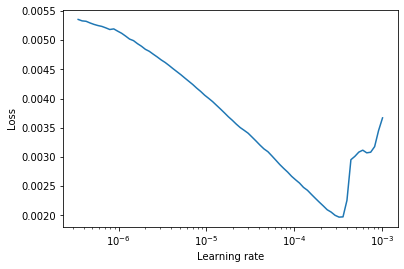

In [ ]:
if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
    model.return_z = False
    opt = create_opt(1e-7,model)
    find_lr(model,opt,L,device,trainDataLoader)
    model.return_z = True

In [ ]:
max_lr = .0001
start_lr = 5*max_lr/10
#opt = create_opt(max_lr,model)
#lr_scheduler = create_one_cycle(opt,max_lr,epochs,trainDataLoader)
opt = torch.optim.Adam(model.parameters(),lr=max_lr,betas=(.5,.999))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [ ]:
versionName = versionName + '_lr{}'.format(str(max_lr))

## Train

In [ ]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, p_loss, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    running_ploss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # gpu
        #X,p = sampleBatch[0],sampleBatch[1]
        X = sampleBatch[0]
        X = X.to(device)
        #p = p.to(device)

        # zero the parameter gradients
        opt.zero_grad()

        X_hat, z = model(X)
        #pl = p_loss(z,p)
        ll = loss(X_hat,X,device)
        combined_loss = ll #pl + ll
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss
        
        #batch_ploss = pl.item()
        #running_ploss += batch_ploss

        # --- Metrics Recording ---

        # metrics
        r = metric(X_hat, X)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)
        #lr_scheduler.step()

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            #avg_running_ploss = running_ploss/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            #tensorboard_writer.add_scalar(tag="p_loss", scalar_value=avg_running_ploss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0
            #running_ploss = 0.0

    return total_loss, tensorboard_recorder_step, total_steps

In [ ]:
# EXPORT
def validEpoch(myDataLoader, tensorboard_writer, model, p_loss, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        #X,p = sampleBatch[0],sampleBatch[1]
        X = sampleBatch[0]
        X = X.to(device)
        #p = p.to(device)
        
        perc = len(X)/len(myDataLoader.dataset)

        # forward, no gradient calculations
        with torch.no_grad():
            X_hat, z = model(X)

        # loss
        #combined_loss = p_loss(z,p) + loss(X_hat,X,device)
        combined_loss = loss(X_hat,X,device)
        
        running_loss += perc*(combined_loss.item())

        # metrics
        r = metric(X_hat, X)
        running_rmse += perc*r

    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return running_loss

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [ ]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [ ]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    model.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, model, opt, p_loss, loss,
                                                                   rmse, lr_scheduler, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#     if trainLoss < bestLoss:
#         bestLoss = trainLoss
#         writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#         torch.save(model.state_dict(), os.path.join(cps,versionName))
        
    model.eval()
    valLoss = validEpoch(testDataLoader, test_writer, model, p_loss, loss, rmse, device, tensorboard_recorder_step)
    writeMessage("valLoss: {:.4e}".format(valLoss),versionName)
    
    # checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(model.state_dict(), os.path.join(cps,versionName))

    lr_scheduler.step(trainLoss)
    
    if opt.param_groups[0]['lr'] < 5e-8:
        break
writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---
trainLoss: 3.9286e-01
LR: 1.0000e-04
valLoss: 1.7531e-02
Better valLoss: 1.7531e-02, Saving models...


  0%|          | 1/1000 [00:02<37:42,  2.27s/it]

--- Epoch 2/1000 ---
trainLoss: 2.1952e-01
LR: 1.0000e-04
valLoss: 1.5702e-02
Better valLoss: 1.5702e-02, Saving models...


  0%|          | 2/1000 [00:04<37:40,  2.26s/it]

--- Epoch 3/1000 ---
trainLoss: 1.7878e-01
LR: 1.0000e-04


  0%|          | 3/1000 [00:06<36:08,  2.17s/it]

valLoss: 1.6179e-02
--- Epoch 4/1000 ---
trainLoss: 1.5591e-01
LR: 1.0000e-04
valLoss: 1.4993e-02
Better valLoss: 1.4993e-02, Saving models...


  0%|          | 4/1000 [00:08<36:28,  2.20s/it]

--- Epoch 5/1000 ---
trainLoss: 1.2689e-01
LR: 1.0000e-04


  0%|          | 5/1000 [00:10<35:15,  2.13s/it]

valLoss: 1.5412e-02
--- Epoch 6/1000 ---
trainLoss: 1.0311e-01
LR: 1.0000e-04
valLoss: 1.3683e-02
Better valLoss: 1.3683e-02, Saving models...


  1%|          | 6/1000 [00:12<35:51,  2.16s/it]

--- Epoch 7/1000 ---
trainLoss: 9.2419e-02
LR: 1.0000e-04


  1%|          | 7/1000 [00:14<34:49,  2.10s/it]

valLoss: 1.5006e-02
--- Epoch 8/1000 ---
trainLoss: 1.1281e-01
LR: 1.0000e-04


  1%|          | 8/1000 [00:16<34:06,  2.06s/it]

valLoss: 1.3812e-02
--- Epoch 9/1000 ---
trainLoss: 1.1498e-01
LR: 1.0000e-04


  1%|          | 9/1000 [00:18<33:37,  2.04s/it]

valLoss: 1.5685e-02
--- Epoch 10/1000 ---
trainLoss: 8.9997e-02
LR: 1.0000e-04
valLoss: 1.3618e-02
Better valLoss: 1.3618e-02, Saving models...


  1%|          | 10/1000 [00:21<34:43,  2.11s/it]

--- Epoch 11/1000 ---
trainLoss: 1.2324e-01
LR: 1.0000e-04
valLoss: 1.2707e-02
Better valLoss: 1.2707e-02, Saving models...


  1%|          | 11/1000 [00:23<35:28,  2.15s/it]

--- Epoch 12/1000 ---
trainLoss: 8.8442e-02
LR: 1.0000e-04


  1%|          | 12/1000 [00:25<34:32,  2.10s/it]

valLoss: 1.3531e-02
--- Epoch 13/1000 ---
trainLoss: 9.2777e-02
LR: 1.0000e-04


  1%|▏         | 13/1000 [00:27<33:53,  2.06s/it]

valLoss: 1.3624e-02
--- Epoch 14/1000 ---
trainLoss: 9.3572e-02
LR: 1.0000e-04
valLoss: 1.0548e-02
Better valLoss: 1.0548e-02, Saving models...


  1%|▏         | 14/1000 [00:29<34:51,  2.12s/it]

--- Epoch 15/1000 ---
trainLoss: 8.3612e-02
LR: 1.0000e-04


  2%|▏         | 15/1000 [00:31<34:09,  2.08s/it]

valLoss: 1.3519e-02
--- Epoch 16/1000 ---
trainLoss: 7.3952e-02
LR: 1.0000e-04


  2%|▏         | 16/1000 [00:33<33:36,  2.05s/it]

valLoss: 1.3600e-02
--- Epoch 17/1000 ---
trainLoss: 7.7143e-02
LR: 1.0000e-04


  2%|▏         | 17/1000 [00:35<33:12,  2.03s/it]

valLoss: 1.3679e-02
--- Epoch 18/1000 ---
trainLoss: 7.9711e-02
LR: 1.0000e-04


  2%|▏         | 18/1000 [00:37<32:58,  2.01s/it]

valLoss: 1.2139e-02
--- Epoch 19/1000 ---
trainLoss: 8.4992e-02
LR: 1.0000e-04


  2%|▏         | 19/1000 [00:39<32:46,  2.00s/it]

valLoss: 1.2354e-02
--- Epoch 20/1000 ---
trainLoss: 6.2765e-02
LR: 1.0000e-05
valLoss: 9.2561e-03
Better valLoss: 9.2561e-03, Saving models...


  2%|▏         | 20/1000 [00:41<34:04,  2.09s/it]

--- Epoch 21/1000 ---
trainLoss: 5.5765e-02
LR: 1.0000e-05


  2%|▏         | 21/1000 [00:43<33:34,  2.06s/it]

valLoss: 9.7375e-03
--- Epoch 22/1000 ---
trainLoss: 5.1118e-02
LR: 1.0000e-05
valLoss: 8.7560e-03
Better valLoss: 8.7560e-03, Saving models...


  2%|▏         | 22/1000 [00:46<34:36,  2.12s/it]

--- Epoch 23/1000 ---
trainLoss: 5.4080e-02
LR: 1.0000e-05


  2%|▏         | 23/1000 [00:48<33:54,  2.08s/it]

valLoss: 9.4084e-03
--- Epoch 24/1000 ---
trainLoss: 5.3197e-02
LR: 1.0000e-05


  2%|▏         | 24/1000 [00:50<33:21,  2.05s/it]

valLoss: 9.6185e-03
--- Epoch 25/1000 ---
trainLoss: 5.2485e-02
LR: 1.0000e-05


  2%|▎         | 25/1000 [00:51<32:58,  2.03s/it]

valLoss: 9.8986e-03
--- Epoch 26/1000 ---
trainLoss: 5.1546e-02
LR: 1.0000e-06


  3%|▎         | 26/1000 [00:53<32:44,  2.02s/it]

valLoss: 9.7055e-03
--- Epoch 27/1000 ---
trainLoss: 4.9861e-02
LR: 1.0000e-06


  3%|▎         | 27/1000 [00:55<32:34,  2.01s/it]

valLoss: 9.1136e-03
--- Epoch 28/1000 ---
trainLoss: 5.0738e-02
LR: 1.0000e-06


  3%|▎         | 28/1000 [00:57<32:25,  2.00s/it]

valLoss: 9.0895e-03
--- Epoch 29/1000 ---
trainLoss: 5.0462e-02
LR: 1.0000e-06


  3%|▎         | 29/1000 [00:59<32:17,  2.00s/it]

valLoss: 9.3001e-03
--- Epoch 30/1000 ---
trainLoss: 5.1279e-02
LR: 1.0000e-06


  3%|▎         | 30/1000 [01:01<32:13,  1.99s/it]

valLoss: 9.2086e-03
--- Epoch 31/1000 ---
trainLoss: 5.0272e-02
LR: 1.0000e-07


  3%|▎         | 31/1000 [01:03<32:09,  1.99s/it]

valLoss: 8.9774e-03
--- Epoch 32/1000 ---
trainLoss: 5.1126e-02
LR: 1.0000e-07


  3%|▎         | 32/1000 [01:05<32:07,  1.99s/it]

valLoss: 9.1110e-03
--- Epoch 33/1000 ---
trainLoss: 4.9037e-02
LR: 1.0000e-07
valLoss: 8.6545e-03
Better valLoss: 8.6545e-03, Saving models...


  3%|▎         | 33/1000 [01:08<33:28,  2.08s/it]

--- Epoch 34/1000 ---
trainLoss: 5.0661e-02
LR: 1.0000e-07


  3%|▎         | 34/1000 [01:10<33:02,  2.05s/it]

valLoss: 9.0044e-03
--- Epoch 35/1000 ---
trainLoss: 5.1596e-02
LR: 1.0000e-07


  4%|▎         | 35/1000 [01:12<32:42,  2.03s/it]

valLoss: 9.1232e-03
--- Epoch 36/1000 ---
trainLoss: 5.2000e-02
LR: 1.0000e-07


  4%|▎         | 36/1000 [01:14<32:28,  2.02s/it]

valLoss: 9.6903e-03
--- Epoch 37/1000 ---
trainLoss: 5.0354e-02
LR: 1.0000e-08


  4%|▎         | 37/1000 [01:16<32:19,  2.01s/it]

valLoss: 9.2255e-03
--- Epoch 38/1000 ---
trainLoss: 5.0366e-02
LR: 1.0000e-08


  4%|▍         | 38/1000 [01:18<32:10,  2.01s/it]

valLoss: 8.9423e-03
--- Epoch 39/1000 ---
trainLoss: 5.0805e-02
LR: 1.0000e-08


  4%|▍         | 39/1000 [01:20<32:03,  2.00s/it]

valLoss: 9.3841e-03
--- Epoch 40/1000 ---
trainLoss: 5.0862e-02
LR: 1.0000e-08


  4%|▍         | 40/1000 [01:22<31:58,  2.00s/it]

valLoss: 9.0213e-03
--- Epoch 41/1000 ---
trainLoss: 5.0538e-02
LR: 1.0000e-08


  4%|▍         | 41/1000 [01:24<31:55,  2.00s/it]

valLoss: 8.8138e-03
--- Epoch 42/1000 ---
trainLoss: 5.1110e-02
LR: 1.0000e-08


  4%|▍         | 42/1000 [01:26<31:52,  2.00s/it]

valLoss: 8.9209e-03
--- Epoch 43/1000 ---
trainLoss: 4.9917e-02
LR: 1.0000e-08


  4%|▍         | 43/1000 [01:28<31:50,  2.00s/it]

valLoss: 8.9987e-03
--- Epoch 44/1000 ---
trainLoss: 5.0096e-02
LR: 1.0000e-08


  4%|▍         | 44/1000 [01:30<31:48,  2.00s/it]

valLoss: 9.0888e-03
--- Epoch 45/1000 ---
trainLoss: 5.0605e-02
LR: 1.0000e-08


  4%|▍         | 45/1000 [01:32<31:46,  2.00s/it]

valLoss: 9.0785e-03
--- Epoch 46/1000 ---
trainLoss: 5.0029e-02
LR: 1.0000e-08
valLoss: 8.6443e-03
Better valLoss: 8.6443e-03, Saving models...


  5%|▍         | 46/1000 [01:34<33:18,  2.09s/it]

--- Epoch 47/1000 ---
trainLoss: 5.0217e-02
LR: 1.0000e-08
valLoss: 8.6277e-03
Better valLoss: 8.6277e-03, Saving models...


  5%|▍         | 47/1000 [01:37<38:49,  2.44s/it]

--- Epoch 48/1000 ---
trainLoss: 5.0979e-02
LR: 1.0000e-08


  5%|▍         | 48/1000 [01:39<36:41,  2.31s/it]

valLoss: 9.1498e-03
--- Epoch 49/1000 ---
trainLoss: 5.1218e-02
LR: 1.0000e-08


  5%|▍         | 49/1000 [01:41<35:09,  2.22s/it]

valLoss: 8.9646e-03
--- Epoch 50/1000 ---
trainLoss: 5.2727e-02
LR: 1.0000e-08


  5%|▌         | 50/1000 [01:43<34:01,  2.15s/it]

valLoss: 9.6100e-03
--- Epoch 51/1000 ---
trainLoss: 5.0515e-02
LR: 1.0000e-08


  5%|▌         | 51/1000 [01:45<33:15,  2.10s/it]

valLoss: 8.9148e-03
--- Epoch 52/1000 ---
trainLoss: 5.0630e-02
LR: 1.0000e-08


  5%|▌         | 52/1000 [01:47<32:43,  2.07s/it]

valLoss: 8.6783e-03
--- Epoch 53/1000 ---
trainLoss: 4.9695e-02
LR: 1.0000e-08
valLoss: 8.5145e-03
Better valLoss: 8.5145e-03, Saving models...


  5%|▌         | 53/1000 [01:50<38:27,  2.44s/it]

--- Epoch 54/1000 ---
trainLoss: 5.1699e-02
LR: 1.0000e-08


  5%|▌         | 54/1000 [01:52<36:20,  2.30s/it]

valLoss: 8.9481e-03
--- Epoch 55/1000 ---
trainLoss: 5.6151e-02
LR: 1.0000e-08


  6%|▌         | 55/1000 [01:54<34:52,  2.21s/it]

valLoss: 9.7039e-03
--- Epoch 56/1000 ---
trainLoss: 4.9318e-02
LR: 1.0000e-08


  6%|▌         | 56/1000 [01:56<33:54,  2.15s/it]

valLoss: 8.8459e-03
--- Epoch 57/1000 ---
trainLoss: 5.0005e-02
LR: 1.0000e-08


  6%|▌         | 57/1000 [01:58<33:07,  2.11s/it]

valLoss: 8.7824e-03
--- Epoch 58/1000 ---
trainLoss: 5.0441e-02
LR: 1.0000e-08


  6%|▌         | 58/1000 [02:00<32:34,  2.07s/it]

valLoss: 8.6512e-03
--- Epoch 59/1000 ---
trainLoss: 5.0367e-02
LR: 1.0000e-08


  6%|▌         | 59/1000 [02:05<43:05,  2.75s/it]

valLoss: 8.7475e-03
--- Epoch 60/1000 ---
trainLoss: 5.2004e-02
LR: 1.0000e-08


  6%|▌         | 60/1000 [02:07<39:31,  2.52s/it]

valLoss: 9.1194e-03
--- Epoch 61/1000 ---
trainLoss: 5.0028e-02
LR: 1.0000e-08


  6%|▌         | 61/1000 [02:09<36:59,  2.36s/it]

valLoss: 8.6663e-03
--- Epoch 62/1000 ---
trainLoss: 5.2005e-02
LR: 1.0000e-08


  6%|▌         | 62/1000 [02:11<35:13,  2.25s/it]

valLoss: 9.0607e-03
--- Epoch 63/1000 ---
trainLoss: 5.0684e-02
LR: 1.0000e-08


  6%|▋         | 63/1000 [02:13<33:58,  2.18s/it]

valLoss: 8.9426e-03
--- Epoch 64/1000 ---
trainLoss: 5.0168e-02
LR: 1.0000e-08


  6%|▋         | 64/1000 [02:15<33:04,  2.12s/it]

valLoss: 8.8571e-03
--- Epoch 65/1000 ---
trainLoss: 4.9874e-02
LR: 1.0000e-08


  6%|▋         | 65/1000 [02:17<32:29,  2.08s/it]

valLoss: 8.9304e-03
--- Epoch 66/1000 ---
trainLoss: 4.8933e-02
LR: 1.0000e-08


  7%|▋         | 66/1000 [02:19<32:02,  2.06s/it]

valLoss: 8.7431e-03
--- Epoch 67/1000 ---
trainLoss: 5.0658e-02
LR: 1.0000e-08


  7%|▋         | 67/1000 [02:21<31:43,  2.04s/it]

valLoss: 8.9292e-03
--- Epoch 68/1000 ---
trainLoss: 4.9628e-02
LR: 1.0000e-08
valLoss: 8.5023e-03
Better valLoss: 8.5023e-03, Saving models...


  7%|▋         | 68/1000 [02:23<33:00,  2.13s/it]

--- Epoch 69/1000 ---
trainLoss: 5.0529e-02
LR: 1.0000e-08


  7%|▋         | 69/1000 [02:25<34:17,  2.21s/it]

valLoss: 8.8342e-03
--- Epoch 70/1000 ---
trainLoss: 4.9907e-02
LR: 1.0000e-08


  7%|▋         | 70/1000 [02:27<33:16,  2.15s/it]

valLoss: 8.7389e-03
--- Epoch 71/1000 ---
trainLoss: 5.2217e-02
LR: 1.0000e-08


  7%|▋         | 71/1000 [02:29<32:32,  2.10s/it]

valLoss: 9.4436e-03
--- Epoch 72/1000 ---
trainLoss: 5.0772e-02
LR: 1.0000e-08


  7%|▋         | 72/1000 [02:31<32:01,  2.07s/it]

valLoss: 9.0397e-03
--- Epoch 73/1000 ---
trainLoss: 5.1835e-02
LR: 1.0000e-08


  7%|▋         | 73/1000 [02:33<31:39,  2.05s/it]

valLoss: 9.1613e-03
--- Epoch 74/1000 ---
trainLoss: 5.1026e-02
LR: 1.0000e-08


  7%|▋         | 74/1000 [02:35<31:22,  2.03s/it]

valLoss: 9.4705e-03
--- Epoch 75/1000 ---
trainLoss: 5.1133e-02
LR: 1.0000e-08


  8%|▊         | 75/1000 [02:37<31:11,  2.02s/it]

valLoss: 9.8618e-03
--- Epoch 76/1000 ---
trainLoss: 4.9823e-02
LR: 1.0000e-08


  8%|▊         | 76/1000 [02:39<31:02,  2.02s/it]

valLoss: 9.7648e-03
--- Epoch 77/1000 ---
trainLoss: 5.0054e-02
LR: 1.0000e-08


  8%|▊         | 77/1000 [02:41<30:57,  2.01s/it]

valLoss: 8.9814e-03
--- Epoch 78/1000 ---
trainLoss: 5.0814e-02
LR: 1.0000e-08


  8%|▊         | 78/1000 [02:43<30:51,  2.01s/it]

valLoss: 9.0773e-03
--- Epoch 79/1000 ---
trainLoss: 5.1161e-02
LR: 1.0000e-08


  8%|▊         | 79/1000 [02:45<30:47,  2.01s/it]

valLoss: 9.0004e-03
--- Epoch 80/1000 ---
trainLoss: 5.0615e-02
LR: 1.0000e-08


  8%|▊         | 80/1000 [02:47<30:44,  2.00s/it]

valLoss: 9.3225e-03
--- Epoch 81/1000 ---
trainLoss: 4.8993e-02
LR: 1.0000e-08


  8%|▊         | 81/1000 [02:49<30:42,  2.01s/it]

valLoss: 8.8151e-03
--- Epoch 82/1000 ---
trainLoss: 4.9833e-02
LR: 1.0000e-08


  8%|▊         | 82/1000 [02:51<30:39,  2.00s/it]

valLoss: 8.9173e-03
--- Epoch 83/1000 ---
trainLoss: 5.0018e-02
LR: 1.0000e-08


  8%|▊         | 83/1000 [02:54<31:10,  2.04s/it]

valLoss: 8.7848e-03
--- Epoch 84/1000 ---
trainLoss: 5.1164e-02
LR: 1.0000e-08


  8%|▊         | 84/1000 [02:56<31:00,  2.03s/it]

valLoss: 9.2566e-03
--- Epoch 85/1000 ---
trainLoss: 5.0475e-02
LR: 1.0000e-08


  8%|▊         | 85/1000 [02:58<30:54,  2.03s/it]

valLoss: 8.9238e-03
--- Epoch 86/1000 ---
trainLoss: 5.0211e-02
LR: 1.0000e-08


  9%|▊         | 86/1000 [03:00<31:59,  2.10s/it]

valLoss: 8.5795e-03
--- Epoch 87/1000 ---
trainLoss: 5.0704e-02
LR: 1.0000e-08


  9%|▊         | 87/1000 [03:02<31:29,  2.07s/it]

valLoss: 8.5312e-03
--- Epoch 88/1000 ---
trainLoss: 5.0579e-02
LR: 1.0000e-08


  9%|▉         | 88/1000 [03:04<31:10,  2.05s/it]

valLoss: 8.5637e-03
--- Epoch 89/1000 ---
trainLoss: 5.0042e-02
LR: 1.0000e-08
valLoss: 8.4441e-03
Better valLoss: 8.4441e-03, Saving models...


  9%|▉         | 89/1000 [03:08<39:43,  2.62s/it]

--- Epoch 90/1000 ---
trainLoss: 4.9718e-02
LR: 1.0000e-08


  9%|▉         | 90/1000 [03:10<36:51,  2.43s/it]

valLoss: 8.5282e-03
--- Epoch 91/1000 ---
trainLoss: 5.0667e-02
LR: 1.0000e-08


  9%|▉         | 91/1000 [03:12<34:50,  2.30s/it]

valLoss: 8.7589e-03
--- Epoch 92/1000 ---
trainLoss: 4.9676e-02
LR: 1.0000e-08
valLoss: 8.4122e-03
Better valLoss: 8.4122e-03, Saving models...


  9%|▉         | 92/1000 [03:14<34:43,  2.29s/it]

--- Epoch 93/1000 ---
trainLoss: 5.0106e-02
LR: 1.0000e-08
valLoss: 8.3591e-03
Better valLoss: 8.3591e-03, Saving models...


  9%|▉         | 93/1000 [03:17<38:45,  2.56s/it]

--- Epoch 94/1000 ---
trainLoss: 4.9055e-02
LR: 1.0000e-08
valLoss: 8.2448e-03
Better valLoss: 8.2448e-03, Saving models...


  9%|▉         | 94/1000 [03:20<37:33,  2.49s/it]

--- Epoch 95/1000 ---
trainLoss: 4.9668e-02
LR: 1.0000e-08


 10%|▉         | 95/1000 [03:22<36:59,  2.45s/it]

valLoss: 8.2770e-03
--- Epoch 96/1000 ---
trainLoss: 5.1568e-02
LR: 1.0000e-08


 10%|▉         | 96/1000 [03:24<34:55,  2.32s/it]

valLoss: 8.7945e-03
--- Epoch 97/1000 ---
trainLoss: 5.0909e-02
LR: 1.0000e-08


 10%|▉         | 97/1000 [03:26<33:27,  2.22s/it]

valLoss: 9.3088e-03
--- Epoch 98/1000 ---
trainLoss: 5.0815e-02
LR: 1.0000e-08


 10%|▉         | 98/1000 [03:28<32:26,  2.16s/it]

valLoss: 9.6647e-03
--- Epoch 99/1000 ---
trainLoss: 5.0302e-02
LR: 1.0000e-08


 10%|▉         | 99/1000 [03:30<31:41,  2.11s/it]

valLoss: 9.1551e-03
--- Epoch 100/1000 ---
trainLoss: 5.0640e-02
LR: 1.0000e-08


 10%|█         | 100/1000 [03:32<31:09,  2.08s/it]

valLoss: 8.8705e-03
--- Epoch 101/1000 ---
trainLoss: 5.0218e-02
LR: 1.0000e-08


 10%|█         | 101/1000 [03:34<30:45,  2.05s/it]

valLoss: 8.7447e-03
--- Epoch 102/1000 ---
trainLoss: 5.2400e-02
LR: 1.0000e-08


 10%|█         | 102/1000 [03:36<30:29,  2.04s/it]

valLoss: 9.1894e-03
--- Epoch 103/1000 ---
trainLoss: 5.1006e-02
LR: 1.0000e-08


 10%|█         | 103/1000 [03:38<30:18,  2.03s/it]

valLoss: 9.0268e-03
--- Epoch 104/1000 ---
trainLoss: 5.1332e-02
LR: 1.0000e-08


 10%|█         | 104/1000 [03:40<30:09,  2.02s/it]

valLoss: 9.4219e-03
--- Epoch 105/1000 ---
trainLoss: 5.0860e-02
LR: 1.0000e-08


 10%|█         | 105/1000 [03:42<30:02,  2.01s/it]

valLoss: 9.2089e-03
--- Epoch 106/1000 ---
trainLoss: 5.0818e-02
LR: 1.0000e-08


 11%|█         | 106/1000 [03:44<29:58,  2.01s/it]

valLoss: 8.8650e-03
--- Epoch 107/1000 ---
trainLoss: 5.2127e-02
LR: 1.0000e-08


 11%|█         | 107/1000 [03:46<29:53,  2.01s/it]

valLoss: 9.1820e-03
--- Epoch 108/1000 ---
trainLoss: 5.2029e-02
LR: 1.0000e-08


 11%|█         | 108/1000 [03:48<29:50,  2.01s/it]

valLoss: 9.3783e-03
--- Epoch 109/1000 ---
trainLoss: 4.9139e-02
LR: 1.0000e-08


 11%|█         | 109/1000 [03:50<29:47,  2.01s/it]

valLoss: 8.5947e-03
--- Epoch 110/1000 ---
trainLoss: 4.9402e-02
LR: 1.0000e-08


 11%|█         | 110/1000 [03:52<29:44,  2.01s/it]

valLoss: 8.4526e-03
--- Epoch 111/1000 ---
trainLoss: 5.1108e-02
LR: 1.0000e-08


 11%|█         | 111/1000 [03:54<29:41,  2.00s/it]

valLoss: 8.8917e-03
--- Epoch 112/1000 ---
trainLoss: 5.0435e-02
LR: 1.0000e-08


 11%|█         | 112/1000 [03:56<29:39,  2.00s/it]

valLoss: 8.6264e-03
--- Epoch 113/1000 ---
trainLoss: 4.9933e-02
LR: 1.0000e-08


 11%|█▏        | 113/1000 [03:58<29:37,  2.00s/it]

valLoss: 8.6863e-03
--- Epoch 114/1000 ---
trainLoss: 5.0004e-02
LR: 1.0000e-08


 11%|█▏        | 114/1000 [04:00<29:35,  2.00s/it]

valLoss: 8.4168e-03
--- Epoch 115/1000 ---
trainLoss: 4.9463e-02
LR: 1.0000e-08


 12%|█▏        | 115/1000 [04:02<29:33,  2.00s/it]

valLoss: 8.2790e-03
--- Epoch 116/1000 ---
trainLoss: 5.0405e-02
LR: 1.0000e-08


 12%|█▏        | 116/1000 [04:04<29:30,  2.00s/it]

valLoss: 8.5002e-03
--- Epoch 117/1000 ---
trainLoss: 5.0564e-02
LR: 1.0000e-08


 12%|█▏        | 117/1000 [04:06<29:28,  2.00s/it]

valLoss: 8.6143e-03
--- Epoch 118/1000 ---
trainLoss: 4.9494e-02
LR: 1.0000e-08


 12%|█▏        | 118/1000 [04:08<29:26,  2.00s/it]

valLoss: 8.5731e-03
--- Epoch 119/1000 ---
trainLoss: 5.2675e-02
LR: 1.0000e-08


 12%|█▏        | 119/1000 [04:10<29:24,  2.00s/it]

valLoss: 9.1246e-03
--- Epoch 120/1000 ---
trainLoss: 5.0842e-02
LR: 1.0000e-08


 12%|█▏        | 120/1000 [04:12<29:23,  2.00s/it]

valLoss: 8.8337e-03
--- Epoch 121/1000 ---
trainLoss: 4.9857e-02
LR: 1.0000e-08


 12%|█▏        | 121/1000 [04:14<29:22,  2.01s/it]

valLoss: 8.6641e-03
--- Epoch 122/1000 ---
trainLoss: 5.0254e-02
LR: 1.0000e-08


 12%|█▏        | 122/1000 [04:16<29:20,  2.01s/it]

valLoss: 8.5076e-03
--- Epoch 123/1000 ---
trainLoss: 4.9244e-02
LR: 1.0000e-08


 12%|█▏        | 123/1000 [04:18<29:18,  2.01s/it]

valLoss: 8.3566e-03
--- Epoch 124/1000 ---
trainLoss: 5.0718e-02
LR: 1.0000e-08


 12%|█▏        | 124/1000 [04:20<29:15,  2.00s/it]

valLoss: 8.7219e-03
--- Epoch 125/1000 ---
trainLoss: 5.0932e-02
LR: 1.0000e-08


 12%|█▎        | 125/1000 [04:22<29:14,  2.00s/it]

valLoss: 9.3759e-03
--- Epoch 126/1000 ---
trainLoss: 5.0678e-02
LR: 1.0000e-08


 13%|█▎        | 126/1000 [04:24<29:11,  2.00s/it]

valLoss: 9.0725e-03
--- Epoch 127/1000 ---
trainLoss: 5.1275e-02
LR: 1.0000e-08


 13%|█▎        | 127/1000 [04:26<29:09,  2.00s/it]

valLoss: 8.9399e-03
--- Epoch 128/1000 ---
trainLoss: 5.0667e-02
LR: 1.0000e-08


 13%|█▎        | 128/1000 [04:28<29:08,  2.00s/it]

valLoss: 9.1791e-03
--- Epoch 129/1000 ---
trainLoss: 5.1434e-02
LR: 1.0000e-08


 13%|█▎        | 129/1000 [04:30<29:06,  2.01s/it]

valLoss: 9.3857e-03
--- Epoch 130/1000 ---
trainLoss: 5.0156e-02
LR: 1.0000e-08


 13%|█▎        | 130/1000 [04:32<29:04,  2.00s/it]

valLoss: 8.9067e-03
--- Epoch 131/1000 ---
trainLoss: 5.1934e-02
LR: 1.0000e-08


 13%|█▎        | 131/1000 [04:34<29:00,  2.00s/it]

valLoss: 8.9762e-03
--- Epoch 132/1000 ---
trainLoss: 5.0574e-02
LR: 1.0000e-08


 13%|█▎        | 132/1000 [04:36<28:58,  2.00s/it]

valLoss: 8.8932e-03
--- Epoch 133/1000 ---
trainLoss: 5.0664e-02
LR: 1.0000e-08


 13%|█▎        | 133/1000 [04:38<28:56,  2.00s/it]

valLoss: 8.7856e-03
--- Epoch 134/1000 ---
trainLoss: 5.0008e-02
LR: 1.0000e-08


 13%|█▎        | 134/1000 [04:40<28:54,  2.00s/it]

valLoss: 8.6020e-03
--- Epoch 135/1000 ---
trainLoss: 5.0550e-02
LR: 1.0000e-08


 14%|█▎        | 135/1000 [04:42<28:52,  2.00s/it]

valLoss: 8.6479e-03
--- Epoch 136/1000 ---
trainLoss: 4.9856e-02
LR: 1.0000e-08


 14%|█▎        | 136/1000 [04:44<28:50,  2.00s/it]

valLoss: 8.4565e-03
--- Epoch 137/1000 ---
trainLoss: 5.2094e-02
LR: 1.0000e-08


 14%|█▎        | 137/1000 [04:46<28:48,  2.00s/it]

valLoss: 9.4241e-03
--- Epoch 138/1000 ---
trainLoss: 5.0267e-02
LR: 1.0000e-08


 14%|█▍        | 138/1000 [04:48<28:47,  2.00s/it]

valLoss: 9.0686e-03
--- Epoch 139/1000 ---
trainLoss: 5.1029e-02
LR: 1.0000e-08


 14%|█▍        | 139/1000 [04:50<28:45,  2.00s/it]

valLoss: 9.2311e-03
--- Epoch 140/1000 ---
trainLoss: 4.9775e-02
LR: 1.0000e-08


 14%|█▍        | 140/1000 [04:52<28:43,  2.00s/it]

valLoss: 8.7896e-03
--- Epoch 141/1000 ---
trainLoss: 5.0873e-02
LR: 1.0000e-08


 14%|█▍        | 141/1000 [04:54<28:40,  2.00s/it]

valLoss: 8.8412e-03
--- Epoch 142/1000 ---
trainLoss: 5.0699e-02
LR: 1.0000e-08


 14%|█▍        | 142/1000 [04:56<28:39,  2.00s/it]

valLoss: 9.0125e-03
--- Epoch 143/1000 ---
trainLoss: 5.0237e-02
LR: 1.0000e-08


 14%|█▍        | 143/1000 [04:58<28:38,  2.00s/it]

valLoss: 8.9512e-03
--- Epoch 144/1000 ---
trainLoss: 5.2090e-02
LR: 1.0000e-08


 14%|█▍        | 144/1000 [05:00<28:36,  2.01s/it]

valLoss: 9.2001e-03
--- Epoch 145/1000 ---
trainLoss: 5.1689e-02
LR: 1.0000e-08


 14%|█▍        | 145/1000 [05:02<28:34,  2.01s/it]

valLoss: 9.5531e-03
--- Epoch 146/1000 ---
trainLoss: 5.0130e-02
LR: 1.0000e-08


 15%|█▍        | 146/1000 [05:04<28:32,  2.01s/it]

valLoss: 9.5215e-03
--- Epoch 147/1000 ---
trainLoss: 4.9011e-02
LR: 1.0000e-08


 15%|█▍        | 147/1000 [05:06<28:31,  2.01s/it]

valLoss: 8.5668e-03
--- Epoch 148/1000 ---
trainLoss: 5.0430e-02
LR: 1.0000e-08


 15%|█▍        | 148/1000 [05:08<28:30,  2.01s/it]

valLoss: 8.9537e-03
--- Epoch 149/1000 ---
trainLoss: 5.0720e-02
LR: 1.0000e-08


 15%|█▍        | 149/1000 [05:10<28:28,  2.01s/it]

valLoss: 8.7811e-03
--- Epoch 150/1000 ---
trainLoss: 5.0967e-02
LR: 1.0000e-08


 15%|█▌        | 150/1000 [05:12<28:25,  2.01s/it]

valLoss: 8.9307e-03
--- Epoch 151/1000 ---
trainLoss: 5.0178e-02
LR: 1.0000e-08


 15%|█▌        | 151/1000 [05:14<28:21,  2.00s/it]

valLoss: 8.7969e-03
--- Epoch 152/1000 ---
trainLoss: 5.1236e-02
LR: 1.0000e-08


 15%|█▌        | 152/1000 [05:16<28:20,  2.00s/it]

valLoss: 8.9732e-03
--- Epoch 153/1000 ---
trainLoss: 5.0036e-02
LR: 1.0000e-08


 15%|█▌        | 153/1000 [05:18<28:18,  2.01s/it]

valLoss: 8.7501e-03
--- Epoch 154/1000 ---
trainLoss: 5.1419e-02
LR: 1.0000e-08


 15%|█▌        | 154/1000 [05:20<28:17,  2.01s/it]

valLoss: 8.8544e-03
--- Epoch 155/1000 ---
trainLoss: 5.0483e-02
LR: 1.0000e-08


 16%|█▌        | 155/1000 [05:22<28:15,  2.01s/it]

valLoss: 8.7338e-03
--- Epoch 156/1000 ---
trainLoss: 5.0067e-02
LR: 1.0000e-08


 16%|█▌        | 156/1000 [05:24<28:13,  2.01s/it]

valLoss: 8.5423e-03
--- Epoch 157/1000 ---
trainLoss: 5.0005e-02
LR: 1.0000e-08


 16%|█▌        | 157/1000 [05:26<28:12,  2.01s/it]

valLoss: 8.5956e-03
--- Epoch 158/1000 ---
trainLoss: 4.9661e-02
LR: 1.0000e-08


 16%|█▌        | 158/1000 [05:28<28:10,  2.01s/it]

valLoss: 8.5610e-03
--- Epoch 159/1000 ---
trainLoss: 5.0176e-02
LR: 1.0000e-08


 16%|█▌        | 159/1000 [05:30<28:08,  2.01s/it]

valLoss: 8.4838e-03
--- Epoch 160/1000 ---
trainLoss: 5.1525e-02
LR: 1.0000e-08


 16%|█▌        | 160/1000 [05:32<28:06,  2.01s/it]

valLoss: 8.7935e-03
--- Epoch 161/1000 ---
trainLoss: 5.0537e-02
LR: 1.0000e-08


 16%|█▌        | 161/1000 [05:34<28:05,  2.01s/it]

valLoss: 9.0479e-03
--- Epoch 162/1000 ---
trainLoss: 4.9288e-02
LR: 1.0000e-08


 16%|█▌        | 162/1000 [05:36<28:02,  2.01s/it]

valLoss: 8.6489e-03
--- Epoch 163/1000 ---
trainLoss: 4.9731e-02
LR: 1.0000e-08


 16%|█▋        | 163/1000 [05:38<28:00,  2.01s/it]

valLoss: 8.7872e-03
--- Epoch 164/1000 ---
trainLoss: 5.0345e-02
LR: 1.0000e-08


 16%|█▋        | 164/1000 [05:40<27:57,  2.01s/it]

valLoss: 8.8029e-03
--- Epoch 165/1000 ---
trainLoss: 5.1765e-02
LR: 1.0000e-08


 16%|█▋        | 165/1000 [05:42<27:55,  2.01s/it]

valLoss: 9.1861e-03
--- Epoch 166/1000 ---
trainLoss: 5.1364e-02
LR: 1.0000e-08


 17%|█▋        | 166/1000 [05:44<27:53,  2.01s/it]

valLoss: 9.1238e-03
--- Epoch 167/1000 ---
trainLoss: 4.9232e-02
LR: 1.0000e-08


 17%|█▋        | 167/1000 [05:46<27:51,  2.01s/it]

valLoss: 8.6205e-03
--- Epoch 168/1000 ---
trainLoss: 4.9619e-02
LR: 1.0000e-08


 17%|█▋        | 168/1000 [05:48<27:49,  2.01s/it]

valLoss: 8.6351e-03
--- Epoch 169/1000 ---
trainLoss: 5.0071e-02
LR: 1.0000e-08


 17%|█▋        | 169/1000 [05:50<27:47,  2.01s/it]

valLoss: 8.7791e-03
--- Epoch 170/1000 ---
trainLoss: 4.9839e-02
LR: 1.0000e-08


 17%|█▋        | 170/1000 [05:52<27:45,  2.01s/it]

valLoss: 8.5892e-03
--- Epoch 171/1000 ---
trainLoss: 4.9957e-02
LR: 1.0000e-08


 17%|█▋        | 171/1000 [05:54<27:44,  2.01s/it]

valLoss: 8.5491e-03
--- Epoch 172/1000 ---
trainLoss: 5.0249e-02
LR: 1.0000e-08


 17%|█▋        | 172/1000 [05:56<27:42,  2.01s/it]

valLoss: 8.7940e-03
--- Epoch 173/1000 ---
trainLoss: 4.9062e-02
LR: 1.0000e-08


 17%|█▋        | 173/1000 [05:58<27:39,  2.01s/it]

valLoss: 8.5321e-03
--- Epoch 174/1000 ---
trainLoss: 5.0996e-02
LR: 1.0000e-08


 17%|█▋        | 174/1000 [06:00<27:36,  2.01s/it]

valLoss: 8.8592e-03
--- Epoch 175/1000 ---
trainLoss: 5.0311e-02
LR: 1.0000e-08


 18%|█▊        | 175/1000 [06:02<27:34,  2.00s/it]

valLoss: 8.7337e-03
--- Epoch 176/1000 ---
trainLoss: 5.2124e-02
LR: 1.0000e-08


 18%|█▊        | 176/1000 [06:04<27:32,  2.01s/it]

valLoss: 9.4139e-03
--- Epoch 177/1000 ---
trainLoss: 5.0374e-02
LR: 1.0000e-08


 18%|█▊        | 177/1000 [06:06<27:30,  2.01s/it]

valLoss: 9.1895e-03
--- Epoch 178/1000 ---
trainLoss: 5.4710e-02
LR: 1.0000e-08


 18%|█▊        | 178/1000 [06:08<27:28,  2.01s/it]

valLoss: 9.5057e-03
--- Epoch 179/1000 ---
trainLoss: 5.0820e-02
LR: 1.0000e-08


 18%|█▊        | 179/1000 [06:10<27:26,  2.01s/it]

valLoss: 9.1960e-03
--- Epoch 180/1000 ---
trainLoss: 5.0411e-02
LR: 1.0000e-08


 18%|█▊        | 180/1000 [06:12<27:26,  2.01s/it]

valLoss: 9.1300e-03
--- Epoch 181/1000 ---
trainLoss: 5.5696e-02
LR: 1.0000e-08


 18%|█▊        | 181/1000 [06:14<27:24,  2.01s/it]

valLoss: 9.1051e-03
--- Epoch 182/1000 ---
trainLoss: 4.9523e-02
LR: 1.0000e-08


 18%|█▊        | 182/1000 [06:16<27:22,  2.01s/it]

valLoss: 8.5476e-03
--- Epoch 183/1000 ---
trainLoss: 4.9285e-02
LR: 1.0000e-08


 18%|█▊        | 183/1000 [06:18<27:19,  2.01s/it]

valLoss: 8.5684e-03
--- Epoch 184/1000 ---
trainLoss: 4.9610e-02
LR: 1.0000e-08


 18%|█▊        | 184/1000 [06:20<27:18,  2.01s/it]

valLoss: 8.4567e-03
--- Epoch 185/1000 ---
trainLoss: 4.9682e-02
LR: 1.0000e-08


 18%|█▊        | 185/1000 [06:22<27:16,  2.01s/it]

valLoss: 8.3697e-03
--- Epoch 186/1000 ---
trainLoss: 5.0089e-02
LR: 1.0000e-08


 19%|█▊        | 186/1000 [06:24<27:14,  2.01s/it]

valLoss: 8.4404e-03
--- Epoch 187/1000 ---
trainLoss: 4.9845e-02
LR: 1.0000e-08


 19%|█▊        | 187/1000 [06:26<27:12,  2.01s/it]

valLoss: 8.4128e-03
--- Epoch 188/1000 ---
trainLoss: 4.9698e-02
LR: 1.0000e-08


 19%|█▉        | 188/1000 [06:28<27:11,  2.01s/it]

valLoss: 8.3170e-03
--- Epoch 189/1000 ---
trainLoss: 5.2021e-02
LR: 1.0000e-08


 19%|█▉        | 189/1000 [06:30<27:09,  2.01s/it]

valLoss: 8.8823e-03
--- Epoch 190/1000 ---
trainLoss: 4.9849e-02
LR: 1.0000e-08


 19%|█▉        | 190/1000 [06:32<27:07,  2.01s/it]

valLoss: 8.6245e-03
--- Epoch 191/1000 ---
trainLoss: 5.0906e-02
LR: 1.0000e-08


 19%|█▉        | 191/1000 [06:34<27:05,  2.01s/it]

valLoss: 9.1276e-03
--- Epoch 192/1000 ---
trainLoss: 5.0093e-02
LR: 1.0000e-08


 19%|█▉        | 192/1000 [06:37<27:03,  2.01s/it]

valLoss: 8.8238e-03
--- Epoch 193/1000 ---
trainLoss: 4.9752e-02
LR: 1.0000e-08


 19%|█▉        | 193/1000 [06:39<27:00,  2.01s/it]

valLoss: 8.7671e-03
--- Epoch 194/1000 ---
trainLoss: 4.9975e-02
LR: 1.0000e-08


 19%|█▉        | 194/1000 [06:41<26:58,  2.01s/it]

valLoss: 8.6395e-03
--- Epoch 195/1000 ---
trainLoss: 4.9748e-02
LR: 1.0000e-08


 20%|█▉        | 195/1000 [06:43<26:56,  2.01s/it]

valLoss: 8.4666e-03
--- Epoch 196/1000 ---
trainLoss: 4.9467e-02
LR: 1.0000e-08


 20%|█▉        | 196/1000 [06:45<26:52,  2.01s/it]

valLoss: 8.3766e-03
--- Epoch 197/1000 ---
trainLoss: 5.0709e-02
LR: 1.0000e-08


 20%|█▉        | 197/1000 [06:47<26:50,  2.01s/it]

valLoss: 8.3929e-03
--- Epoch 198/1000 ---
trainLoss: 5.0171e-02
LR: 1.0000e-08


 20%|█▉        | 198/1000 [06:49<26:47,  2.00s/it]

valLoss: 8.8755e-03
--- Epoch 199/1000 ---
trainLoss: 5.1279e-02
LR: 1.0000e-08


 20%|█▉        | 199/1000 [06:51<26:46,  2.01s/it]

valLoss: 9.3215e-03
--- Epoch 200/1000 ---
trainLoss: 5.0392e-02
LR: 1.0000e-08


 20%|██        | 200/1000 [06:53<26:43,  2.00s/it]

valLoss: 9.1476e-03
--- Epoch 201/1000 ---
trainLoss: 4.9851e-02
LR: 1.0000e-08


 20%|██        | 201/1000 [06:55<26:42,  2.01s/it]

valLoss: 8.8024e-03
--- Epoch 202/1000 ---
trainLoss: 5.0718e-02
LR: 1.0000e-08


 20%|██        | 202/1000 [06:57<26:41,  2.01s/it]

valLoss: 8.8658e-03
--- Epoch 203/1000 ---
trainLoss: 5.0737e-02
LR: 1.0000e-08


 20%|██        | 203/1000 [06:59<26:40,  2.01s/it]

valLoss: 9.0789e-03
--- Epoch 204/1000 ---
trainLoss: 4.9929e-02
LR: 1.0000e-08


 20%|██        | 204/1000 [07:01<26:39,  2.01s/it]

valLoss: 8.9077e-03
--- Epoch 205/1000 ---
trainLoss: 5.0384e-02
LR: 1.0000e-08


 20%|██        | 205/1000 [07:03<26:37,  2.01s/it]

valLoss: 8.6974e-03
--- Epoch 206/1000 ---
trainLoss: 5.1147e-02
LR: 1.0000e-08


 21%|██        | 206/1000 [07:05<26:36,  2.01s/it]

valLoss: 9.0716e-03
--- Epoch 207/1000 ---
trainLoss: 5.1448e-02
LR: 1.0000e-08


 21%|██        | 207/1000 [07:07<26:33,  2.01s/it]

valLoss: 8.8402e-03
--- Epoch 208/1000 ---
trainLoss: 4.9667e-02
LR: 1.0000e-08


 21%|██        | 208/1000 [07:09<26:31,  2.01s/it]

valLoss: 8.8287e-03
--- Epoch 209/1000 ---
trainLoss: 4.9626e-02
LR: 1.0000e-08


 21%|██        | 209/1000 [07:11<26:28,  2.01s/it]

valLoss: 8.5439e-03
--- Epoch 210/1000 ---
trainLoss: 5.0777e-02
LR: 1.0000e-08


 21%|██        | 210/1000 [07:13<26:26,  2.01s/it]

valLoss: 8.8767e-03
--- Epoch 211/1000 ---
trainLoss: 5.1219e-02
LR: 1.0000e-08


 21%|██        | 211/1000 [07:15<26:24,  2.01s/it]

valLoss: 8.9555e-03
--- Epoch 212/1000 ---
trainLoss: 4.9491e-02
LR: 1.0000e-08


 21%|██        | 212/1000 [07:17<26:22,  2.01s/it]

valLoss: 8.5581e-03
--- Epoch 213/1000 ---
trainLoss: 4.9586e-02
LR: 1.0000e-08


 21%|██▏       | 213/1000 [07:19<26:21,  2.01s/it]

valLoss: 8.3410e-03
--- Epoch 214/1000 ---
trainLoss: 5.1035e-02
LR: 1.0000e-08


 21%|██▏       | 214/1000 [07:21<26:20,  2.01s/it]

valLoss: 8.6563e-03
--- Epoch 215/1000 ---
trainLoss: 5.0125e-02
LR: 1.0000e-08


 22%|██▏       | 215/1000 [07:23<26:18,  2.01s/it]

valLoss: 8.8649e-03
--- Epoch 216/1000 ---
trainLoss: 5.1035e-02
LR: 1.0000e-08


 22%|██▏       | 216/1000 [07:25<26:16,  2.01s/it]

valLoss: 8.7914e-03
--- Epoch 217/1000 ---
trainLoss: 5.0996e-02
LR: 1.0000e-08


 22%|██▏       | 217/1000 [07:27<26:14,  2.01s/it]

valLoss: 9.1656e-03
--- Epoch 218/1000 ---
trainLoss: 5.0133e-02
LR: 1.0000e-08


 22%|██▏       | 218/1000 [07:29<26:12,  2.01s/it]

valLoss: 9.4087e-03
--- Epoch 219/1000 ---
trainLoss: 4.9758e-02
LR: 1.0000e-08


 22%|██▏       | 219/1000 [07:31<26:09,  2.01s/it]

valLoss: 8.7629e-03
--- Epoch 220/1000 ---
trainLoss: 5.1818e-02
LR: 1.0000e-08


 22%|██▏       | 220/1000 [07:33<26:07,  2.01s/it]

valLoss: 9.7639e-03
--- Epoch 221/1000 ---
trainLoss: 4.9856e-02
LR: 1.0000e-08


 22%|██▏       | 221/1000 [07:35<26:06,  2.01s/it]

valLoss: 9.0692e-03
--- Epoch 222/1000 ---
trainLoss: 5.1151e-02
LR: 1.0000e-08


 22%|██▏       | 222/1000 [07:37<26:03,  2.01s/it]

valLoss: 9.3650e-03
--- Epoch 223/1000 ---
trainLoss: 5.0224e-02
LR: 1.0000e-08


 22%|██▏       | 223/1000 [07:39<26:01,  2.01s/it]

valLoss: 9.2703e-03
--- Epoch 224/1000 ---
trainLoss: 5.0581e-02
LR: 1.0000e-08


 22%|██▏       | 224/1000 [07:41<25:59,  2.01s/it]

valLoss: 9.0334e-03
--- Epoch 225/1000 ---
trainLoss: 4.9837e-02
LR: 1.0000e-08


 22%|██▎       | 225/1000 [07:43<25:58,  2.01s/it]

valLoss: 8.8493e-03
--- Epoch 226/1000 ---
trainLoss: 4.9748e-02
LR: 1.0000e-08


 23%|██▎       | 226/1000 [07:45<25:55,  2.01s/it]

valLoss: 8.7228e-03
--- Epoch 227/1000 ---
trainLoss: 4.9032e-02
LR: 1.0000e-08


 23%|██▎       | 227/1000 [07:47<25:52,  2.01s/it]

valLoss: 8.6413e-03
--- Epoch 228/1000 ---
trainLoss: 5.0827e-02
LR: 1.0000e-08


 23%|██▎       | 228/1000 [07:49<25:49,  2.01s/it]

valLoss: 9.0180e-03
--- Epoch 229/1000 ---
trainLoss: 4.9910e-02
LR: 1.0000e-08


 23%|██▎       | 229/1000 [07:51<25:47,  2.01s/it]

valLoss: 8.8051e-03
--- Epoch 230/1000 ---
trainLoss: 4.9731e-02
LR: 1.0000e-08


 23%|██▎       | 230/1000 [07:53<25:44,  2.01s/it]

valLoss: 8.6696e-03
--- Epoch 231/1000 ---
trainLoss: 4.9717e-02
LR: 1.0000e-08


 23%|██▎       | 231/1000 [07:55<25:42,  2.01s/it]

valLoss: 8.5528e-03
--- Epoch 232/1000 ---
trainLoss: 4.9591e-02
LR: 1.0000e-08


 23%|██▎       | 232/1000 [07:57<25:40,  2.01s/it]

valLoss: 8.4325e-03
--- Epoch 233/1000 ---
trainLoss: 4.9812e-02
LR: 1.0000e-08


 23%|██▎       | 233/1000 [07:59<25:40,  2.01s/it]

valLoss: 8.3513e-03
--- Epoch 234/1000 ---
trainLoss: 5.0079e-02
LR: 1.0000e-08


 23%|██▎       | 234/1000 [08:01<25:40,  2.01s/it]

valLoss: 8.4073e-03
--- Epoch 235/1000 ---
trainLoss: 5.1396e-02
LR: 1.0000e-08


 24%|██▎       | 235/1000 [08:03<25:38,  2.01s/it]

valLoss: 8.5379e-03
--- Epoch 236/1000 ---
trainLoss: 4.9064e-02
LR: 1.0000e-08


 24%|██▎       | 236/1000 [08:05<25:36,  2.01s/it]

valLoss: 8.3357e-03
--- Epoch 237/1000 ---
trainLoss: 5.1088e-02
LR: 1.0000e-08


 24%|██▎       | 237/1000 [08:07<25:34,  2.01s/it]

valLoss: 8.6915e-03
--- Epoch 238/1000 ---
trainLoss: 5.1207e-02
LR: 1.0000e-08


 24%|██▍       | 238/1000 [08:09<25:32,  2.01s/it]

valLoss: 8.8846e-03
--- Epoch 239/1000 ---
trainLoss: 4.9868e-02
LR: 1.0000e-08


 24%|██▍       | 239/1000 [08:11<25:30,  2.01s/it]

valLoss: 8.8778e-03
--- Epoch 240/1000 ---
trainLoss: 5.0728e-02
LR: 1.0000e-08


 24%|██▍       | 240/1000 [08:13<25:27,  2.01s/it]

valLoss: 8.9527e-03
--- Epoch 241/1000 ---
trainLoss: 4.9749e-02
LR: 1.0000e-08


 24%|██▍       | 241/1000 [08:15<25:26,  2.01s/it]

valLoss: 8.9992e-03
--- Epoch 242/1000 ---
trainLoss: 4.9969e-02
LR: 1.0000e-08


 24%|██▍       | 242/1000 [08:17<25:24,  2.01s/it]

valLoss: 8.9925e-03
--- Epoch 243/1000 ---
trainLoss: 5.0121e-02
LR: 1.0000e-08


 24%|██▍       | 243/1000 [08:19<25:22,  2.01s/it]

valLoss: 8.7336e-03
--- Epoch 244/1000 ---
trainLoss: 5.2021e-02
LR: 1.0000e-08


 24%|██▍       | 244/1000 [08:21<25:20,  2.01s/it]

valLoss: 8.7992e-03
--- Epoch 245/1000 ---
trainLoss: 5.0395e-02
LR: 1.0000e-08


 24%|██▍       | 245/1000 [08:23<25:18,  2.01s/it]

valLoss: 8.7441e-03
--- Epoch 246/1000 ---
trainLoss: 4.9939e-02
LR: 1.0000e-08


 25%|██▍       | 246/1000 [08:25<25:15,  2.01s/it]

valLoss: 8.8222e-03
--- Epoch 247/1000 ---
trainLoss: 5.0234e-02
LR: 1.0000e-08


 25%|██▍       | 247/1000 [08:27<25:13,  2.01s/it]

valLoss: 9.1659e-03
--- Epoch 248/1000 ---
trainLoss: 5.0324e-02
LR: 1.0000e-08


 25%|██▍       | 248/1000 [08:29<25:10,  2.01s/it]

valLoss: 8.7481e-03
--- Epoch 249/1000 ---
trainLoss: 5.0950e-02
LR: 1.0000e-08


 25%|██▍       | 249/1000 [08:31<25:08,  2.01s/it]

valLoss: 8.8290e-03
--- Epoch 250/1000 ---
trainLoss: 5.0110e-02
LR: 1.0000e-08


 25%|██▌       | 250/1000 [08:33<25:07,  2.01s/it]

valLoss: 8.7120e-03
--- Epoch 251/1000 ---
trainLoss: 5.0417e-02
LR: 1.0000e-08


 25%|██▌       | 251/1000 [08:35<25:05,  2.01s/it]

valLoss: 8.5215e-03
--- Epoch 252/1000 ---
trainLoss: 5.3465e-02
LR: 1.0000e-08


 25%|██▌       | 252/1000 [08:37<25:03,  2.01s/it]

valLoss: 9.1212e-03
--- Epoch 253/1000 ---
trainLoss: 4.9510e-02
LR: 1.0000e-08


 25%|██▌       | 253/1000 [08:39<25:01,  2.01s/it]

valLoss: 9.1855e-03
--- Epoch 254/1000 ---
trainLoss: 5.0418e-02
LR: 1.0000e-08


 25%|██▌       | 254/1000 [08:41<24:59,  2.01s/it]

valLoss: 9.0360e-03
--- Epoch 255/1000 ---
trainLoss: 5.0494e-02
LR: 1.0000e-08


 26%|██▌       | 255/1000 [08:43<24:58,  2.01s/it]

valLoss: 8.8240e-03
--- Epoch 256/1000 ---
trainLoss: 5.0355e-02
LR: 1.0000e-08


 26%|██▌       | 256/1000 [08:45<24:55,  2.01s/it]

valLoss: 8.8061e-03
--- Epoch 257/1000 ---
trainLoss: 4.9976e-02
LR: 1.0000e-08


 26%|██▌       | 257/1000 [08:47<24:53,  2.01s/it]

valLoss: 8.7018e-03
--- Epoch 258/1000 ---
trainLoss: 5.0180e-02
LR: 1.0000e-08


 26%|██▌       | 258/1000 [08:49<24:51,  2.01s/it]

valLoss: 8.5422e-03
--- Epoch 259/1000 ---
trainLoss: 4.9916e-02
LR: 1.0000e-08


 26%|██▌       | 259/1000 [08:51<24:48,  2.01s/it]

valLoss: 8.8911e-03
--- Epoch 260/1000 ---
trainLoss: 5.2078e-02
LR: 1.0000e-08


 26%|██▌       | 260/1000 [08:53<24:47,  2.01s/it]

valLoss: 9.1569e-03
--- Epoch 261/1000 ---
trainLoss: 4.9780e-02
LR: 1.0000e-08


 26%|██▌       | 261/1000 [08:55<24:45,  2.01s/it]

valLoss: 8.6805e-03
--- Epoch 262/1000 ---
trainLoss: 5.1729e-02
LR: 1.0000e-08


 26%|██▌       | 262/1000 [08:57<24:42,  2.01s/it]

valLoss: 9.2134e-03
--- Epoch 263/1000 ---
trainLoss: 4.9449e-02
LR: 1.0000e-08


 26%|██▋       | 263/1000 [08:59<24:40,  2.01s/it]

valLoss: 9.0131e-03
--- Epoch 264/1000 ---
trainLoss: 5.0193e-02
LR: 1.0000e-08


 26%|██▋       | 264/1000 [09:01<24:36,  2.01s/it]

valLoss: 8.7606e-03
--- Epoch 265/1000 ---
trainLoss: 4.9755e-02
LR: 1.0000e-08


 26%|██▋       | 265/1000 [09:03<24:34,  2.01s/it]

valLoss: 8.6012e-03
--- Epoch 266/1000 ---
trainLoss: 5.0106e-02
LR: 1.0000e-08


 27%|██▋       | 266/1000 [09:05<24:32,  2.01s/it]

valLoss: 8.5070e-03
--- Epoch 267/1000 ---
trainLoss: 4.9532e-02
LR: 1.0000e-08


 27%|██▋       | 267/1000 [09:07<24:30,  2.01s/it]

valLoss: 8.4083e-03
--- Epoch 268/1000 ---
trainLoss: 4.8923e-02
LR: 1.0000e-08


 27%|██▋       | 268/1000 [09:09<24:29,  2.01s/it]

valLoss: 8.7163e-03
--- Epoch 269/1000 ---
trainLoss: 5.0271e-02
LR: 1.0000e-08


 27%|██▋       | 269/1000 [09:11<24:27,  2.01s/it]

valLoss: 8.6901e-03
--- Epoch 270/1000 ---
trainLoss: 4.9687e-02
LR: 1.0000e-08


 27%|██▋       | 270/1000 [09:13<24:26,  2.01s/it]

valLoss: 8.3881e-03
--- Epoch 271/1000 ---
trainLoss: 5.1165e-02
LR: 1.0000e-08


 27%|██▋       | 271/1000 [09:15<24:25,  2.01s/it]

valLoss: 8.5886e-03
--- Epoch 272/1000 ---
trainLoss: 4.9111e-02
LR: 1.0000e-08


 27%|██▋       | 272/1000 [09:17<24:25,  2.01s/it]

valLoss: 8.4330e-03
--- Epoch 273/1000 ---
trainLoss: 5.0604e-02
LR: 1.0000e-08


 27%|██▋       | 273/1000 [09:19<24:23,  2.01s/it]

valLoss: 8.6731e-03
--- Epoch 274/1000 ---
trainLoss: 5.0089e-02
LR: 1.0000e-08


 27%|██▋       | 274/1000 [09:21<24:21,  2.01s/it]

valLoss: 8.6161e-03
--- Epoch 275/1000 ---
trainLoss: 4.8874e-02
LR: 1.0000e-08


 28%|██▊       | 275/1000 [09:23<24:18,  2.01s/it]

valLoss: 9.0680e-03
--- Epoch 276/1000 ---
trainLoss: 4.9704e-02
LR: 1.0000e-08


 28%|██▊       | 276/1000 [09:25<24:16,  2.01s/it]

valLoss: 8.6661e-03
--- Epoch 277/1000 ---
trainLoss: 4.9737e-02
LR: 1.0000e-08


 28%|██▊       | 277/1000 [09:27<24:15,  2.01s/it]

valLoss: 8.7272e-03
--- Epoch 278/1000 ---
trainLoss: 4.9893e-02
LR: 1.0000e-08


 28%|██▊       | 278/1000 [09:29<24:14,  2.01s/it]

valLoss: 8.7017e-03
--- Epoch 279/1000 ---
trainLoss: 5.0711e-02
LR: 1.0000e-08


 28%|██▊       | 279/1000 [09:31<24:11,  2.01s/it]

valLoss: 8.6738e-03
--- Epoch 280/1000 ---
trainLoss: 4.9357e-02
LR: 1.0000e-08


 28%|██▊       | 280/1000 [09:33<24:09,  2.01s/it]

valLoss: 8.7410e-03
--- Epoch 281/1000 ---
trainLoss: 4.9983e-02
LR: 1.0000e-08


 28%|██▊       | 281/1000 [09:35<24:05,  2.01s/it]

valLoss: 8.6344e-03
--- Epoch 282/1000 ---
trainLoss: 4.9178e-02
LR: 1.0000e-08


 28%|██▊       | 282/1000 [09:37<24:02,  2.01s/it]

valLoss: 8.4131e-03
--- Epoch 283/1000 ---
trainLoss: 4.9836e-02
LR: 1.0000e-08


 28%|██▊       | 283/1000 [09:39<24:01,  2.01s/it]

valLoss: 8.5077e-03
--- Epoch 284/1000 ---
trainLoss: 5.4015e-02
LR: 1.0000e-08


 28%|██▊       | 284/1000 [09:41<23:58,  2.01s/it]

valLoss: 9.0503e-03
--- Epoch 285/1000 ---
trainLoss: 5.0083e-02
LR: 1.0000e-08


 28%|██▊       | 285/1000 [09:43<23:56,  2.01s/it]

valLoss: 9.3344e-03
--- Epoch 286/1000 ---
trainLoss: 5.0353e-02
LR: 1.0000e-08


 29%|██▊       | 286/1000 [09:45<23:54,  2.01s/it]

valLoss: 9.0145e-03
--- Epoch 287/1000 ---
trainLoss: 5.1038e-02
LR: 1.0000e-08


 29%|██▊       | 287/1000 [09:47<23:52,  2.01s/it]

valLoss: 9.0906e-03
--- Epoch 288/1000 ---
trainLoss: 5.1593e-02
LR: 1.0000e-08


 29%|██▉       | 288/1000 [09:49<23:50,  2.01s/it]

valLoss: 9.4419e-03
--- Epoch 289/1000 ---
trainLoss: 5.1454e-02
LR: 1.0000e-08


 29%|██▉       | 289/1000 [09:51<23:49,  2.01s/it]

valLoss: 9.9642e-03
--- Epoch 290/1000 ---
trainLoss: 5.0699e-02
LR: 1.0000e-08


 29%|██▉       | 290/1000 [09:53<23:47,  2.01s/it]

valLoss: 9.4727e-03
--- Epoch 291/1000 ---
trainLoss: 5.0717e-02
LR: 1.0000e-08


 29%|██▉       | 291/1000 [09:55<23:45,  2.01s/it]

valLoss: 9.1080e-03
--- Epoch 292/1000 ---
trainLoss: 5.0242e-02
LR: 1.0000e-08


 29%|██▉       | 292/1000 [09:57<23:43,  2.01s/it]

valLoss: 8.9120e-03
--- Epoch 293/1000 ---
trainLoss: 5.0494e-02
LR: 1.0000e-08


 29%|██▉       | 293/1000 [09:59<23:41,  2.01s/it]

valLoss: 8.7755e-03
--- Epoch 294/1000 ---
trainLoss: 5.0335e-02
LR: 1.0000e-08


 29%|██▉       | 294/1000 [10:01<23:39,  2.01s/it]

valLoss: 8.4799e-03
--- Epoch 295/1000 ---
trainLoss: 5.1759e-02
LR: 1.0000e-08


 30%|██▉       | 295/1000 [10:03<23:36,  2.01s/it]

valLoss: 8.9001e-03
--- Epoch 296/1000 ---
trainLoss: 5.1167e-02
LR: 1.0000e-08


 30%|██▉       | 296/1000 [10:05<23:33,  2.01s/it]

valLoss: 9.1118e-03
--- Epoch 297/1000 ---
trainLoss: 5.1538e-02
LR: 1.0000e-08


 30%|██▉       | 297/1000 [10:07<23:32,  2.01s/it]

valLoss: 9.0835e-03
--- Epoch 298/1000 ---
trainLoss: 5.0153e-02
LR: 1.0000e-08


 30%|██▉       | 298/1000 [10:09<23:29,  2.01s/it]

valLoss: 8.8621e-03
--- Epoch 299/1000 ---
trainLoss: 5.0321e-02
LR: 1.0000e-08


 30%|██▉       | 299/1000 [10:12<23:27,  2.01s/it]

valLoss: 8.7627e-03
--- Epoch 300/1000 ---
trainLoss: 5.0026e-02
LR: 1.0000e-08


 30%|███       | 300/1000 [10:14<23:24,  2.01s/it]

valLoss: 8.8321e-03
--- Epoch 301/1000 ---
trainLoss: 5.0581e-02
LR: 1.0000e-08


 30%|███       | 301/1000 [10:16<23:22,  2.01s/it]

valLoss: 9.3167e-03
--- Epoch 302/1000 ---
trainLoss: 4.9908e-02
LR: 1.0000e-08


 30%|███       | 302/1000 [10:18<23:20,  2.01s/it]

valLoss: 8.8852e-03
--- Epoch 303/1000 ---
trainLoss: 5.0284e-02
LR: 1.0000e-08


 30%|███       | 303/1000 [10:20<23:18,  2.01s/it]

valLoss: 9.0033e-03
--- Epoch 304/1000 ---
trainLoss: 5.0020e-02
LR: 1.0000e-08


 30%|███       | 304/1000 [10:22<23:15,  2.01s/it]

valLoss: 9.3848e-03
--- Epoch 305/1000 ---
trainLoss: 5.2023e-02
LR: 1.0000e-08


 30%|███       | 305/1000 [10:24<23:14,  2.01s/it]

valLoss: 9.9920e-03
--- Epoch 306/1000 ---
trainLoss: 4.9424e-02
LR: 1.0000e-08


 31%|███       | 306/1000 [10:26<23:13,  2.01s/it]

valLoss: 8.8365e-03
--- Epoch 307/1000 ---
trainLoss: 5.1394e-02
LR: 1.0000e-08


 31%|███       | 307/1000 [10:28<23:12,  2.01s/it]

valLoss: 9.1702e-03
--- Epoch 308/1000 ---
trainLoss: 4.9966e-02
LR: 1.0000e-08


 31%|███       | 308/1000 [10:30<23:11,  2.01s/it]

valLoss: 9.1942e-03
--- Epoch 309/1000 ---
trainLoss: 5.0306e-02
LR: 1.0000e-08


 31%|███       | 309/1000 [10:32<23:08,  2.01s/it]

valLoss: 8.8851e-03
--- Epoch 310/1000 ---
trainLoss: 5.4189e-02
LR: 1.0000e-08


 31%|███       | 310/1000 [10:34<23:06,  2.01s/it]

valLoss: 1.0144e-02
--- Epoch 311/1000 ---
trainLoss: 5.0004e-02
LR: 1.0000e-08


 31%|███       | 311/1000 [10:36<23:05,  2.01s/it]

valLoss: 9.3108e-03
--- Epoch 312/1000 ---
trainLoss: 5.0448e-02
LR: 1.0000e-08


 31%|███       | 312/1000 [10:38<23:02,  2.01s/it]

valLoss: 9.2397e-03
--- Epoch 313/1000 ---
trainLoss: 5.1256e-02
LR: 1.0000e-08


 31%|███▏      | 313/1000 [10:40<23:01,  2.01s/it]

valLoss: 9.3130e-03
--- Epoch 314/1000 ---
trainLoss: 4.9852e-02
LR: 1.0000e-08


 31%|███▏      | 314/1000 [10:42<22:57,  2.01s/it]

valLoss: 8.9109e-03
--- Epoch 315/1000 ---
trainLoss: 5.1903e-02
LR: 1.0000e-08


 32%|███▏      | 315/1000 [10:44<22:57,  2.01s/it]

valLoss: 9.4530e-03
--- Epoch 316/1000 ---
trainLoss: 5.0557e-02
LR: 1.0000e-08


 32%|███▏      | 316/1000 [10:46<22:54,  2.01s/it]

valLoss: 9.3401e-03
--- Epoch 317/1000 ---
trainLoss: 5.0220e-02
LR: 1.0000e-08


 32%|███▏      | 317/1000 [10:48<22:52,  2.01s/it]

valLoss: 9.3912e-03
--- Epoch 318/1000 ---
trainLoss: 5.0304e-02
LR: 1.0000e-08


 32%|███▏      | 318/1000 [10:50<22:50,  2.01s/it]

valLoss: 9.1521e-03
--- Epoch 319/1000 ---
trainLoss: 5.0412e-02
LR: 1.0000e-08


 32%|███▏      | 319/1000 [10:52<22:48,  2.01s/it]

valLoss: 9.3542e-03
--- Epoch 320/1000 ---
trainLoss: 4.9525e-02
LR: 1.0000e-08


 32%|███▏      | 320/1000 [10:54<22:46,  2.01s/it]

valLoss: 8.7650e-03
--- Epoch 321/1000 ---
trainLoss: 5.0239e-02
LR: 1.0000e-08


 32%|███▏      | 321/1000 [10:56<22:44,  2.01s/it]

valLoss: 8.6986e-03
--- Epoch 322/1000 ---
trainLoss: 5.0407e-02
LR: 1.0000e-08


 32%|███▏      | 322/1000 [10:58<22:42,  2.01s/it]

valLoss: 9.2668e-03
--- Epoch 323/1000 ---
trainLoss: 5.1873e-02
LR: 1.0000e-08


 32%|███▏      | 323/1000 [11:00<22:40,  2.01s/it]

valLoss: 9.2564e-03
--- Epoch 324/1000 ---
trainLoss: 4.9995e-02
LR: 1.0000e-08


 32%|███▏      | 324/1000 [11:02<22:39,  2.01s/it]

valLoss: 8.8607e-03
--- Epoch 325/1000 ---
trainLoss: 4.9711e-02
LR: 1.0000e-08


 32%|███▎      | 325/1000 [11:04<22:37,  2.01s/it]

valLoss: 8.7004e-03
--- Epoch 326/1000 ---
trainLoss: 4.9914e-02
LR: 1.0000e-08


 33%|███▎      | 326/1000 [11:06<22:35,  2.01s/it]

valLoss: 8.4587e-03
--- Epoch 327/1000 ---
trainLoss: 5.1017e-02
LR: 1.0000e-08


 33%|███▎      | 327/1000 [11:08<22:33,  2.01s/it]

valLoss: 8.8879e-03
--- Epoch 328/1000 ---
trainLoss: 4.9936e-02
LR: 1.0000e-08


 33%|███▎      | 328/1000 [11:10<22:32,  2.01s/it]

valLoss: 8.8080e-03
--- Epoch 329/1000 ---
trainLoss: 4.9663e-02
LR: 1.0000e-08


 33%|███▎      | 329/1000 [11:12<22:30,  2.01s/it]

valLoss: 8.7548e-03
--- Epoch 330/1000 ---
trainLoss: 5.0171e-02
LR: 1.0000e-08


 33%|███▎      | 330/1000 [11:14<22:27,  2.01s/it]

valLoss: 8.4997e-03
--- Epoch 331/1000 ---
trainLoss: 5.1189e-02
LR: 1.0000e-08


 33%|███▎      | 331/1000 [11:16<22:26,  2.01s/it]

valLoss: 8.8979e-03
--- Epoch 332/1000 ---
trainLoss: 4.9426e-02
LR: 1.0000e-08


 33%|███▎      | 332/1000 [11:18<22:23,  2.01s/it]

valLoss: 8.4974e-03
--- Epoch 333/1000 ---
trainLoss: 4.8729e-02
LR: 1.0000e-08


 33%|███▎      | 333/1000 [11:20<22:21,  2.01s/it]

valLoss: 8.3999e-03
--- Epoch 334/1000 ---
trainLoss: 5.0179e-02
LR: 1.0000e-08


 33%|███▎      | 334/1000 [11:22<22:19,  2.01s/it]

valLoss: 8.5343e-03
--- Epoch 335/1000 ---
trainLoss: 5.0538e-02
LR: 1.0000e-08


 34%|███▎      | 335/1000 [11:24<22:17,  2.01s/it]

valLoss: 8.6222e-03
--- Epoch 336/1000 ---
trainLoss: 4.8981e-02
LR: 1.0000e-08


 34%|███▎      | 336/1000 [11:26<22:15,  2.01s/it]

valLoss: 8.6081e-03
--- Epoch 337/1000 ---
trainLoss: 4.9935e-02
LR: 1.0000e-08


 34%|███▎      | 337/1000 [11:28<22:12,  2.01s/it]

valLoss: 8.6165e-03
--- Epoch 338/1000 ---
trainLoss: 4.9842e-02
LR: 1.0000e-08


 34%|███▍      | 338/1000 [11:30<22:10,  2.01s/it]

valLoss: 8.4300e-03
--- Epoch 339/1000 ---
trainLoss: 4.9522e-02
LR: 1.0000e-08
valLoss: 8.2422e-03
Better valLoss: 8.2422e-03, Saving models...


 34%|███▍      | 339/1000 [11:32<23:04,  2.09s/it]

--- Epoch 340/1000 ---
trainLoss: 5.0679e-02
LR: 1.0000e-08


 34%|███▍      | 340/1000 [11:34<22:45,  2.07s/it]

valLoss: 8.5701e-03
--- Epoch 341/1000 ---
trainLoss: 4.9973e-02
LR: 1.0000e-08


 34%|███▍      | 341/1000 [11:36<22:31,  2.05s/it]

valLoss: 8.7162e-03
--- Epoch 342/1000 ---
trainLoss: 5.0450e-02
LR: 1.0000e-08


 34%|███▍      | 342/1000 [11:38<22:21,  2.04s/it]

valLoss: 8.6778e-03
--- Epoch 343/1000 ---
trainLoss: 4.9753e-02
LR: 1.0000e-08


 34%|███▍      | 343/1000 [11:40<22:13,  2.03s/it]

valLoss: 8.4893e-03
--- Epoch 344/1000 ---
trainLoss: 5.2251e-02
LR: 1.0000e-08


 34%|███▍      | 344/1000 [11:42<22:07,  2.02s/it]

valLoss: 9.1046e-03
--- Epoch 345/1000 ---
trainLoss: 4.9974e-02
LR: 1.0000e-08


 34%|███▍      | 345/1000 [11:44<22:02,  2.02s/it]

valLoss: 8.9251e-03
--- Epoch 346/1000 ---
trainLoss: 4.9686e-02
LR: 1.0000e-08


 35%|███▍      | 346/1000 [11:46<21:58,  2.02s/it]

valLoss: 9.0506e-03
--- Epoch 347/1000 ---
trainLoss: 5.0137e-02
LR: 1.0000e-08


 35%|███▍      | 347/1000 [11:48<21:54,  2.01s/it]

valLoss: 9.0605e-03
--- Epoch 348/1000 ---
trainLoss: 5.0333e-02
LR: 1.0000e-08


 35%|███▍      | 348/1000 [11:50<21:50,  2.01s/it]

valLoss: 9.0783e-03
--- Epoch 349/1000 ---
trainLoss: 4.9836e-02
LR: 1.0000e-08


 35%|███▍      | 349/1000 [11:52<21:48,  2.01s/it]

valLoss: 9.5874e-03
--- Epoch 350/1000 ---
trainLoss: 4.8993e-02
LR: 1.0000e-08


 35%|███▌      | 350/1000 [11:54<21:45,  2.01s/it]

valLoss: 8.6372e-03
--- Epoch 351/1000 ---
trainLoss: 5.0976e-02
LR: 1.0000e-08


 35%|███▌      | 351/1000 [11:56<21:44,  2.01s/it]

valLoss: 8.6651e-03
--- Epoch 352/1000 ---
trainLoss: 4.9101e-02
LR: 1.0000e-08


 35%|███▌      | 352/1000 [11:58<21:41,  2.01s/it]

valLoss: 8.8640e-03
--- Epoch 353/1000 ---
trainLoss: 4.8930e-02
LR: 1.0000e-08


 35%|███▌      | 353/1000 [12:00<21:41,  2.01s/it]

valLoss: 8.8912e-03
--- Epoch 354/1000 ---
trainLoss: 5.3781e-02
LR: 1.0000e-08


 35%|███▌      | 354/1000 [12:02<21:40,  2.01s/it]

valLoss: 9.6404e-03
--- Epoch 355/1000 ---
trainLoss: 5.0715e-02
LR: 1.0000e-08


 36%|███▌      | 355/1000 [12:04<21:38,  2.01s/it]

valLoss: 9.3707e-03
--- Epoch 356/1000 ---
trainLoss: 4.9486e-02
LR: 1.0000e-08


 36%|███▌      | 356/1000 [12:06<21:35,  2.01s/it]

valLoss: 9.0329e-03
--- Epoch 357/1000 ---
trainLoss: 4.9701e-02
LR: 1.0000e-08


 36%|███▌      | 357/1000 [12:08<21:32,  2.01s/it]

valLoss: 8.8738e-03
--- Epoch 358/1000 ---
trainLoss: 5.0260e-02
LR: 1.0000e-08


 36%|███▌      | 358/1000 [12:10<21:30,  2.01s/it]

valLoss: 8.8472e-03
--- Epoch 359/1000 ---
trainLoss: 4.9266e-02
LR: 1.0000e-08


 36%|███▌      | 359/1000 [12:12<21:28,  2.01s/it]

valLoss: 8.5554e-03
--- Epoch 360/1000 ---
trainLoss: 4.9463e-02
LR: 1.0000e-08


 36%|███▌      | 360/1000 [12:14<21:27,  2.01s/it]

valLoss: 8.3608e-03
--- Epoch 361/1000 ---
trainLoss: 4.9466e-02
LR: 1.0000e-08


 36%|███▌      | 361/1000 [12:16<21:24,  2.01s/it]

valLoss: 8.3516e-03
--- Epoch 362/1000 ---
trainLoss: 4.9836e-02
LR: 1.0000e-08


 36%|███▌      | 362/1000 [12:18<21:21,  2.01s/it]

valLoss: 8.3553e-03
--- Epoch 363/1000 ---
trainLoss: 4.9519e-02
LR: 1.0000e-08


 36%|███▋      | 363/1000 [12:20<21:19,  2.01s/it]

valLoss: 8.3073e-03
--- Epoch 364/1000 ---
trainLoss: 4.9021e-02
LR: 1.0000e-08


 36%|███▋      | 364/1000 [12:22<21:16,  2.01s/it]

valLoss: 8.4506e-03
--- Epoch 365/1000 ---
trainLoss: 4.9651e-02
LR: 1.0000e-08


 36%|███▋      | 365/1000 [12:24<21:15,  2.01s/it]

valLoss: 8.5073e-03
--- Epoch 366/1000 ---
trainLoss: 5.0495e-02
LR: 1.0000e-08


 37%|███▋      | 366/1000 [12:26<21:13,  2.01s/it]

valLoss: 8.6482e-03
--- Epoch 367/1000 ---
trainLoss: 4.9589e-02
LR: 1.0000e-08


 37%|███▋      | 367/1000 [12:28<21:11,  2.01s/it]

valLoss: 8.4914e-03
--- Epoch 368/1000 ---
trainLoss: 5.0127e-02
LR: 1.0000e-08


 37%|███▋      | 368/1000 [12:30<21:09,  2.01s/it]

valLoss: 8.6559e-03
--- Epoch 369/1000 ---
trainLoss: 5.0632e-02
LR: 1.0000e-08


 37%|███▋      | 369/1000 [12:32<21:06,  2.01s/it]

valLoss: 8.9407e-03
--- Epoch 370/1000 ---
trainLoss: 5.0411e-02
LR: 1.0000e-08


 37%|███▋      | 370/1000 [12:34<21:04,  2.01s/it]

valLoss: 8.7902e-03
--- Epoch 371/1000 ---
trainLoss: 5.0239e-02
LR: 1.0000e-08


 37%|███▋      | 371/1000 [12:36<21:02,  2.01s/it]

valLoss: 8.9789e-03
--- Epoch 372/1000 ---
trainLoss: 5.0140e-02
LR: 1.0000e-08


 37%|███▋      | 372/1000 [12:38<21:00,  2.01s/it]

valLoss: 8.8740e-03
--- Epoch 373/1000 ---
trainLoss: 5.0407e-02
LR: 1.0000e-08


 37%|███▋      | 373/1000 [12:40<20:58,  2.01s/it]

valLoss: 9.0227e-03
--- Epoch 374/1000 ---
trainLoss: 5.0170e-02
LR: 1.0000e-08


 37%|███▋      | 374/1000 [12:43<20:56,  2.01s/it]

valLoss: 8.9092e-03
--- Epoch 375/1000 ---
trainLoss: 5.1421e-02
LR: 1.0000e-08


 38%|███▊      | 375/1000 [12:45<20:54,  2.01s/it]

valLoss: 8.9314e-03
--- Epoch 376/1000 ---
trainLoss: 4.9929e-02
LR: 1.0000e-08


 38%|███▊      | 376/1000 [12:47<20:53,  2.01s/it]

valLoss: 8.7975e-03
--- Epoch 377/1000 ---
trainLoss: 4.8636e-02
LR: 1.0000e-08


 38%|███▊      | 377/1000 [12:49<20:51,  2.01s/it]

valLoss: 8.3664e-03
--- Epoch 378/1000 ---
trainLoss: 5.0941e-02
LR: 1.0000e-08


 38%|███▊      | 378/1000 [12:51<20:49,  2.01s/it]

valLoss: 8.5798e-03
--- Epoch 379/1000 ---
trainLoss: 4.9886e-02
LR: 1.0000e-08


 38%|███▊      | 379/1000 [12:53<20:47,  2.01s/it]

valLoss: 8.4843e-03
--- Epoch 380/1000 ---
trainLoss: 4.9499e-02
LR: 1.0000e-08


 38%|███▊      | 380/1000 [12:55<20:46,  2.01s/it]

valLoss: 9.0281e-03
--- Epoch 381/1000 ---
trainLoss: 5.2626e-02
LR: 1.0000e-08


 38%|███▊      | 381/1000 [12:57<20:43,  2.01s/it]

valLoss: 1.0193e-02
--- Epoch 382/1000 ---
trainLoss: 4.9807e-02
LR: 1.0000e-08


 38%|███▊      | 382/1000 [12:59<20:42,  2.01s/it]

valLoss: 9.3489e-03
--- Epoch 383/1000 ---
trainLoss: 5.0647e-02
LR: 1.0000e-08


 38%|███▊      | 383/1000 [13:01<20:40,  2.01s/it]

valLoss: 9.2744e-03
--- Epoch 384/1000 ---
trainLoss: 5.2687e-02
LR: 1.0000e-08


 38%|███▊      | 384/1000 [13:03<20:37,  2.01s/it]

valLoss: 1.0049e-02
--- Epoch 385/1000 ---
trainLoss: 5.0113e-02
LR: 1.0000e-08


 38%|███▊      | 385/1000 [13:05<20:35,  2.01s/it]

valLoss: 9.4436e-03
--- Epoch 386/1000 ---
trainLoss: 5.0609e-02
LR: 1.0000e-08


 39%|███▊      | 386/1000 [13:07<20:32,  2.01s/it]

valLoss: 9.2365e-03
--- Epoch 387/1000 ---
trainLoss: 4.9262e-02
LR: 1.0000e-08


 39%|███▊      | 387/1000 [13:09<20:31,  2.01s/it]

valLoss: 8.7474e-03
--- Epoch 388/1000 ---
trainLoss: 5.0065e-02
LR: 1.0000e-08


 39%|███▉      | 388/1000 [13:11<20:29,  2.01s/it]

valLoss: 8.8197e-03
--- Epoch 389/1000 ---
trainLoss: 5.0751e-02
LR: 1.0000e-08


 39%|███▉      | 389/1000 [13:13<20:27,  2.01s/it]

valLoss: 8.7161e-03
--- Epoch 390/1000 ---
trainLoss: 4.9882e-02
LR: 1.0000e-08


 39%|███▉      | 390/1000 [13:15<20:25,  2.01s/it]

valLoss: 8.5698e-03
--- Epoch 391/1000 ---
trainLoss: 4.9355e-02
LR: 1.0000e-08


 39%|███▉      | 391/1000 [13:17<20:24,  2.01s/it]

valLoss: 8.6843e-03
--- Epoch 392/1000 ---
trainLoss: 5.0079e-02
LR: 1.0000e-08


 39%|███▉      | 392/1000 [13:19<20:22,  2.01s/it]

valLoss: 8.7820e-03
--- Epoch 393/1000 ---
trainLoss: 5.0782e-02
LR: 1.0000e-08


 39%|███▉      | 393/1000 [13:21<20:20,  2.01s/it]

valLoss: 8.7785e-03
--- Epoch 394/1000 ---
trainLoss: 5.0611e-02
LR: 1.0000e-08


 39%|███▉      | 394/1000 [13:23<20:19,  2.01s/it]

valLoss: 8.8690e-03
--- Epoch 395/1000 ---
trainLoss: 5.0969e-02
LR: 1.0000e-08


 40%|███▉      | 395/1000 [13:25<20:16,  2.01s/it]

valLoss: 8.9248e-03
--- Epoch 396/1000 ---
trainLoss: 4.9964e-02
LR: 1.0000e-08


 40%|███▉      | 396/1000 [13:27<20:14,  2.01s/it]

valLoss: 9.2152e-03
--- Epoch 397/1000 ---
trainLoss: 4.9795e-02
LR: 1.0000e-08


 40%|███▉      | 397/1000 [13:29<20:11,  2.01s/it]

valLoss: 9.1040e-03
--- Epoch 398/1000 ---
trainLoss: 4.9593e-02
LR: 1.0000e-08


 40%|███▉      | 398/1000 [13:31<20:10,  2.01s/it]

valLoss: 8.7535e-03
--- Epoch 399/1000 ---
trainLoss: 5.0812e-02
LR: 1.0000e-08


 40%|███▉      | 399/1000 [13:33<20:08,  2.01s/it]

valLoss: 9.1402e-03
--- Epoch 400/1000 ---
trainLoss: 5.0961e-02
LR: 1.0000e-08


 40%|████      | 400/1000 [13:35<20:06,  2.01s/it]

valLoss: 9.3190e-03
--- Epoch 401/1000 ---
trainLoss: 5.0109e-02
LR: 1.0000e-08


 40%|████      | 401/1000 [13:37<20:04,  2.01s/it]

valLoss: 9.1541e-03
--- Epoch 402/1000 ---
trainLoss: 4.8735e-02
LR: 1.0000e-08


 40%|████      | 402/1000 [13:39<20:01,  2.01s/it]

valLoss: 9.3049e-03
--- Epoch 403/1000 ---
trainLoss: 5.0882e-02
LR: 1.0000e-08


 40%|████      | 403/1000 [13:41<19:59,  2.01s/it]

valLoss: 9.4563e-03
--- Epoch 404/1000 ---
trainLoss: 5.3515e-02
LR: 1.0000e-08


 40%|████      | 404/1000 [13:43<19:57,  2.01s/it]

valLoss: 9.5204e-03
--- Epoch 405/1000 ---
trainLoss: 4.9395e-02
LR: 1.0000e-08


 40%|████      | 405/1000 [13:45<19:54,  2.01s/it]

valLoss: 8.9698e-03
--- Epoch 406/1000 ---
trainLoss: 5.0202e-02
LR: 1.0000e-08


 41%|████      | 406/1000 [13:47<19:52,  2.01s/it]

valLoss: 8.8207e-03
--- Epoch 407/1000 ---
trainLoss: 5.0244e-02
LR: 1.0000e-08


 41%|████      | 407/1000 [13:49<19:50,  2.01s/it]

valLoss: 8.6509e-03
--- Epoch 408/1000 ---
trainLoss: 5.1363e-02
LR: 1.0000e-08


 41%|████      | 408/1000 [13:51<19:47,  2.01s/it]

valLoss: 8.9759e-03
--- Epoch 409/1000 ---
trainLoss: 5.1274e-02
LR: 1.0000e-08


 41%|████      | 409/1000 [13:53<19:45,  2.01s/it]

valLoss: 9.0500e-03
--- Epoch 410/1000 ---
trainLoss: 5.1100e-02
LR: 1.0000e-08


 41%|████      | 410/1000 [13:55<19:43,  2.01s/it]

valLoss: 9.3189e-03
--- Epoch 411/1000 ---
trainLoss: 5.1458e-02
LR: 1.0000e-08


 41%|████      | 411/1000 [13:57<19:42,  2.01s/it]

valLoss: 9.3469e-03
--- Epoch 412/1000 ---
trainLoss: 4.8979e-02
LR: 1.0000e-08


 41%|████      | 412/1000 [13:59<19:40,  2.01s/it]

valLoss: 8.5751e-03
--- Epoch 413/1000 ---
trainLoss: 4.8764e-02
LR: 1.0000e-08


 41%|████▏     | 413/1000 [14:01<19:38,  2.01s/it]

valLoss: 8.5455e-03
--- Epoch 414/1000 ---
trainLoss: 4.8666e-02
LR: 1.0000e-08


 41%|████▏     | 414/1000 [14:03<19:36,  2.01s/it]

valLoss: 8.4783e-03
--- Epoch 415/1000 ---
trainLoss: 4.9705e-02
LR: 1.0000e-08


 42%|████▏     | 415/1000 [14:05<19:34,  2.01s/it]

valLoss: 8.4123e-03
--- Epoch 416/1000 ---
trainLoss: 4.9671e-02
LR: 1.0000e-08


 42%|████▏     | 416/1000 [14:07<19:32,  2.01s/it]

valLoss: 8.4362e-03
--- Epoch 417/1000 ---
trainLoss: 5.0328e-02
LR: 1.0000e-08


 42%|████▏     | 417/1000 [14:09<19:31,  2.01s/it]

valLoss: 8.6488e-03
--- Epoch 418/1000 ---
trainLoss: 4.9060e-02
LR: 1.0000e-08


 42%|████▏     | 418/1000 [14:11<19:31,  2.01s/it]

valLoss: 8.3319e-03
--- Epoch 419/1000 ---
trainLoss: 5.0190e-02
LR: 1.0000e-08


 42%|████▏     | 419/1000 [14:13<19:30,  2.01s/it]

valLoss: 8.6345e-03
--- Epoch 420/1000 ---
trainLoss: 5.1584e-02
LR: 1.0000e-08


 42%|████▏     | 420/1000 [14:15<19:27,  2.01s/it]

valLoss: 8.9593e-03
--- Epoch 421/1000 ---
trainLoss: 4.9631e-02
LR: 1.0000e-08


 42%|████▏     | 421/1000 [14:17<19:26,  2.01s/it]

valLoss: 8.7880e-03
--- Epoch 422/1000 ---
trainLoss: 4.9556e-02
LR: 1.0000e-08


 42%|████▏     | 422/1000 [14:19<19:24,  2.01s/it]

valLoss: 8.4222e-03
--- Epoch 423/1000 ---
trainLoss: 5.0133e-02
LR: 1.0000e-08


 42%|████▏     | 423/1000 [14:21<19:21,  2.01s/it]

valLoss: 8.6236e-03
--- Epoch 424/1000 ---
trainLoss: 5.0268e-02
LR: 1.0000e-08


 42%|████▏     | 424/1000 [14:23<19:20,  2.02s/it]

valLoss: 8.5632e-03
--- Epoch 425/1000 ---
trainLoss: 4.9440e-02
LR: 1.0000e-08


 42%|████▎     | 425/1000 [14:25<19:18,  2.01s/it]

valLoss: 8.3758e-03
--- Epoch 426/1000 ---
trainLoss: 5.0831e-02
LR: 1.0000e-08


 43%|████▎     | 426/1000 [14:27<19:16,  2.01s/it]

valLoss: 8.6187e-03
--- Epoch 427/1000 ---
trainLoss: 4.9774e-02
LR: 1.0000e-08


 43%|████▎     | 427/1000 [14:29<19:15,  2.02s/it]

valLoss: 8.7256e-03
--- Epoch 428/1000 ---
trainLoss: 4.9184e-02
LR: 1.0000e-08


 43%|████▎     | 428/1000 [14:31<19:13,  2.02s/it]

valLoss: 8.6052e-03
--- Epoch 429/1000 ---
trainLoss: 4.9968e-02
LR: 1.0000e-08


 43%|████▎     | 429/1000 [14:33<19:10,  2.02s/it]

valLoss: 8.7558e-03
--- Epoch 430/1000 ---
trainLoss: 5.0561e-02
LR: 1.0000e-08


 43%|████▎     | 430/1000 [14:35<19:07,  2.01s/it]

valLoss: 9.1027e-03
--- Epoch 431/1000 ---
trainLoss: 4.9632e-02
LR: 1.0000e-08


 43%|████▎     | 431/1000 [14:37<19:05,  2.01s/it]

valLoss: 9.0237e-03
--- Epoch 432/1000 ---
trainLoss: 5.0642e-02
LR: 1.0000e-08


 43%|████▎     | 432/1000 [14:39<19:03,  2.01s/it]

valLoss: 8.9280e-03
--- Epoch 433/1000 ---
trainLoss: 5.1275e-02
LR: 1.0000e-08


 43%|████▎     | 433/1000 [14:41<19:01,  2.01s/it]

valLoss: 9.1462e-03
--- Epoch 434/1000 ---
trainLoss: 4.9910e-02
LR: 1.0000e-08


 43%|████▎     | 434/1000 [14:43<18:59,  2.01s/it]

valLoss: 8.9138e-03
--- Epoch 435/1000 ---
trainLoss: 5.1971e-02
LR: 1.0000e-08


 44%|████▎     | 435/1000 [14:45<18:57,  2.01s/it]

valLoss: 9.4862e-03
--- Epoch 436/1000 ---
trainLoss: 4.9072e-02
LR: 1.0000e-08


 44%|████▎     | 436/1000 [14:47<18:54,  2.01s/it]

valLoss: 8.7837e-03
--- Epoch 437/1000 ---
trainLoss: 4.9125e-02
LR: 1.0000e-08


 44%|████▎     | 437/1000 [14:49<18:52,  2.01s/it]

valLoss: 8.4632e-03
--- Epoch 438/1000 ---
trainLoss: 4.9230e-02
LR: 1.0000e-08


 44%|████▍     | 438/1000 [14:51<18:51,  2.01s/it]

valLoss: 8.2775e-03
--- Epoch 439/1000 ---
trainLoss: 5.1662e-02
LR: 1.0000e-08


 44%|████▍     | 439/1000 [14:53<18:49,  2.01s/it]

valLoss: 8.9864e-03
--- Epoch 440/1000 ---
trainLoss: 5.2694e-02
LR: 1.0000e-08


 44%|████▍     | 440/1000 [14:55<18:47,  2.01s/it]

valLoss: 9.8108e-03
--- Epoch 441/1000 ---
trainLoss: 4.9125e-02
LR: 1.0000e-08


 44%|████▍     | 441/1000 [14:57<18:44,  2.01s/it]

valLoss: 9.1863e-03
--- Epoch 442/1000 ---
trainLoss: 4.8809e-02
LR: 1.0000e-08


 44%|████▍     | 442/1000 [14:59<18:41,  2.01s/it]

valLoss: 8.8851e-03
--- Epoch 443/1000 ---
trainLoss: 5.1283e-02
LR: 1.0000e-08


 44%|████▍     | 443/1000 [15:01<18:39,  2.01s/it]

valLoss: 8.8369e-03
--- Epoch 444/1000 ---
trainLoss: 4.8676e-02
LR: 1.0000e-08


 44%|████▍     | 444/1000 [15:03<18:37,  2.01s/it]

valLoss: 8.6877e-03
--- Epoch 445/1000 ---
trainLoss: 4.9688e-02
LR: 1.0000e-08


 44%|████▍     | 445/1000 [15:05<18:34,  2.01s/it]

valLoss: 8.4624e-03
--- Epoch 446/1000 ---
trainLoss: 4.9852e-02
LR: 1.0000e-08


 45%|████▍     | 446/1000 [15:07<18:32,  2.01s/it]

valLoss: 8.4782e-03
--- Epoch 447/1000 ---
trainLoss: 4.8961e-02
LR: 1.0000e-08
valLoss: 8.2326e-03
Better valLoss: 8.2326e-03, Saving models...


 45%|████▍     | 447/1000 [15:10<19:20,  2.10s/it]

--- Epoch 448/1000 ---
trainLoss: 4.8048e-02
LR: 1.0000e-08


 45%|████▍     | 448/1000 [15:12<19:04,  2.07s/it]

valLoss: 8.2484e-03
--- Epoch 449/1000 ---
trainLoss: 5.0116e-02
LR: 1.0000e-08


 45%|████▍     | 449/1000 [15:14<18:51,  2.05s/it]

valLoss: 8.4436e-03
--- Epoch 450/1000 ---
trainLoss: 5.1442e-02
LR: 1.0000e-08


 45%|████▌     | 450/1000 [15:16<18:41,  2.04s/it]

valLoss: 8.8199e-03
--- Epoch 451/1000 ---
trainLoss: 5.0724e-02
LR: 1.0000e-08


 45%|████▌     | 451/1000 [15:18<18:34,  2.03s/it]

valLoss: 8.9431e-03
--- Epoch 452/1000 ---
trainLoss: 5.1038e-02
LR: 1.0000e-08


 45%|████▌     | 452/1000 [15:20<18:28,  2.02s/it]

valLoss: 9.1884e-03
--- Epoch 453/1000 ---
trainLoss: 5.0385e-02
LR: 1.0000e-08


 45%|████▌     | 453/1000 [15:22<18:24,  2.02s/it]

valLoss: 8.8527e-03
--- Epoch 454/1000 ---
trainLoss: 4.9696e-02
LR: 1.0000e-08


 45%|████▌     | 454/1000 [15:24<18:20,  2.01s/it]

valLoss: 8.7929e-03
--- Epoch 455/1000 ---
trainLoss: 5.0557e-02
LR: 1.0000e-08


 46%|████▌     | 455/1000 [15:26<18:16,  2.01s/it]

valLoss: 8.8348e-03
--- Epoch 456/1000 ---
trainLoss: 5.2489e-02
LR: 1.0000e-08


 46%|████▌     | 456/1000 [15:28<18:14,  2.01s/it]

valLoss: 9.6836e-03
--- Epoch 457/1000 ---
trainLoss: 4.9717e-02
LR: 1.0000e-08


 46%|████▌     | 457/1000 [15:30<18:10,  2.01s/it]

valLoss: 9.0290e-03
--- Epoch 458/1000 ---
trainLoss: 4.9823e-02
LR: 1.0000e-08


 46%|████▌     | 458/1000 [15:32<18:07,  2.01s/it]

valLoss: 9.0260e-03
--- Epoch 459/1000 ---
trainLoss: 4.9540e-02
LR: 1.0000e-08


 46%|████▌     | 459/1000 [15:34<18:06,  2.01s/it]

valLoss: 8.6406e-03
--- Epoch 460/1000 ---
trainLoss: 4.9122e-02
LR: 1.0000e-08


 46%|████▌     | 460/1000 [15:36<18:04,  2.01s/it]

valLoss: 8.7340e-03
--- Epoch 461/1000 ---
trainLoss: 4.9216e-02
LR: 1.0000e-08


 46%|████▌     | 461/1000 [15:38<18:02,  2.01s/it]

valLoss: 8.6106e-03
--- Epoch 462/1000 ---
trainLoss: 4.9203e-02
LR: 1.0000e-08


 46%|████▌     | 462/1000 [15:40<18:01,  2.01s/it]

valLoss: 8.3816e-03
--- Epoch 463/1000 ---
trainLoss: 4.9227e-02
LR: 1.0000e-08


 46%|████▋     | 463/1000 [15:42<17:59,  2.01s/it]

valLoss: 8.3620e-03
--- Epoch 464/1000 ---
trainLoss: 4.9793e-02
LR: 1.0000e-08


 46%|████▋     | 464/1000 [15:44<17:57,  2.01s/it]

valLoss: 8.5256e-03
--- Epoch 465/1000 ---
trainLoss: 5.1028e-02
LR: 1.0000e-08


 46%|████▋     | 465/1000 [15:46<17:55,  2.01s/it]

valLoss: 8.8653e-03
--- Epoch 466/1000 ---
trainLoss: 4.9374e-02
LR: 1.0000e-08


 47%|████▋     | 466/1000 [15:48<17:52,  2.01s/it]

valLoss: 8.5452e-03
--- Epoch 467/1000 ---
trainLoss: 5.0523e-02
LR: 1.0000e-08


 47%|████▋     | 467/1000 [15:50<17:51,  2.01s/it]

valLoss: 8.5970e-03
--- Epoch 468/1000 ---
trainLoss: 5.1013e-02
LR: 1.0000e-08


 47%|████▋     | 468/1000 [15:52<17:48,  2.01s/it]

valLoss: 8.9288e-03
--- Epoch 469/1000 ---
trainLoss: 5.1147e-02
LR: 1.0000e-08


 47%|████▋     | 469/1000 [15:54<17:46,  2.01s/it]

valLoss: 9.0879e-03
--- Epoch 470/1000 ---
trainLoss: 4.9780e-02
LR: 1.0000e-08


 47%|████▋     | 470/1000 [15:56<17:45,  2.01s/it]

valLoss: 8.8381e-03
--- Epoch 471/1000 ---
trainLoss: 5.0103e-02
LR: 1.0000e-08


 47%|████▋     | 471/1000 [15:58<17:43,  2.01s/it]

valLoss: 8.8114e-03
--- Epoch 472/1000 ---
trainLoss: 4.9812e-02
LR: 1.0000e-08


 47%|████▋     | 472/1000 [16:00<17:41,  2.01s/it]

valLoss: 8.6240e-03
--- Epoch 473/1000 ---
trainLoss: 5.0190e-02
LR: 1.0000e-08


 47%|████▋     | 473/1000 [16:02<17:41,  2.01s/it]

valLoss: 8.7391e-03
--- Epoch 474/1000 ---
trainLoss: 5.0600e-02
LR: 1.0000e-08


 47%|████▋     | 474/1000 [16:04<17:38,  2.01s/it]

valLoss: 8.8256e-03
--- Epoch 475/1000 ---
trainLoss: 4.8783e-02
LR: 1.0000e-08


 48%|████▊     | 475/1000 [16:06<17:37,  2.01s/it]

valLoss: 8.4324e-03
--- Epoch 476/1000 ---
trainLoss: 5.0847e-02
LR: 1.0000e-08


 48%|████▊     | 476/1000 [16:08<17:34,  2.01s/it]

valLoss: 8.7643e-03
--- Epoch 477/1000 ---
trainLoss: 5.0170e-02
LR: 1.0000e-08


 48%|████▊     | 477/1000 [16:10<17:32,  2.01s/it]

valLoss: 8.6261e-03
--- Epoch 478/1000 ---
trainLoss: 4.9335e-02
LR: 1.0000e-08


 48%|████▊     | 478/1000 [16:12<17:30,  2.01s/it]

valLoss: 8.5964e-03
--- Epoch 479/1000 ---
trainLoss: 5.1082e-02
LR: 1.0000e-08


 48%|████▊     | 479/1000 [16:14<17:28,  2.01s/it]

valLoss: 9.0858e-03
--- Epoch 480/1000 ---
trainLoss: 4.9652e-02
LR: 1.0000e-08


 48%|████▊     | 480/1000 [16:16<17:25,  2.01s/it]

valLoss: 9.1837e-03
--- Epoch 481/1000 ---
trainLoss: 5.0553e-02
LR: 1.0000e-08


 48%|████▊     | 481/1000 [16:18<17:23,  2.01s/it]

valLoss: 8.9362e-03
--- Epoch 482/1000 ---
trainLoss: 5.1105e-02
LR: 1.0000e-08


 48%|████▊     | 482/1000 [16:20<17:21,  2.01s/it]

valLoss: 9.0448e-03
--- Epoch 483/1000 ---
trainLoss: 5.0063e-02
LR: 1.0000e-08


 48%|████▊     | 483/1000 [16:22<17:19,  2.01s/it]

valLoss: 8.7199e-03
--- Epoch 484/1000 ---
trainLoss: 4.9282e-02
LR: 1.0000e-08


 48%|████▊     | 484/1000 [16:24<17:17,  2.01s/it]

valLoss: 8.9497e-03
--- Epoch 485/1000 ---
trainLoss: 5.0526e-02
LR: 1.0000e-08


 48%|████▊     | 485/1000 [16:26<17:16,  2.01s/it]

valLoss: 9.0462e-03
--- Epoch 486/1000 ---
trainLoss: 5.0900e-02
LR: 1.0000e-08


 49%|████▊     | 486/1000 [16:28<17:14,  2.01s/it]

valLoss: 9.0111e-03
--- Epoch 487/1000 ---
trainLoss: 5.0233e-02
LR: 1.0000e-08


 49%|████▊     | 487/1000 [16:30<17:12,  2.01s/it]

valLoss: 8.8612e-03
--- Epoch 488/1000 ---
trainLoss: 5.0088e-02
LR: 1.0000e-08


 49%|████▉     | 488/1000 [16:32<17:09,  2.01s/it]

valLoss: 8.6116e-03
--- Epoch 489/1000 ---
trainLoss: 4.9710e-02
LR: 1.0000e-08


 49%|████▉     | 489/1000 [16:34<17:07,  2.01s/it]

valLoss: 8.6531e-03
--- Epoch 490/1000 ---
trainLoss: 5.0203e-02
LR: 1.0000e-08


 49%|████▉     | 490/1000 [16:36<17:06,  2.01s/it]

valLoss: 8.8472e-03
--- Epoch 491/1000 ---
trainLoss: 5.0796e-02
LR: 1.0000e-08


 49%|████▉     | 491/1000 [16:38<17:04,  2.01s/it]

valLoss: 8.9123e-03
--- Epoch 492/1000 ---
trainLoss: 4.9717e-02
LR: 1.0000e-08


 49%|████▉     | 492/1000 [16:40<17:01,  2.01s/it]

valLoss: 9.0822e-03
--- Epoch 493/1000 ---
trainLoss: 5.0038e-02
LR: 1.0000e-08


 49%|████▉     | 493/1000 [16:42<16:59,  2.01s/it]

valLoss: 9.3929e-03
--- Epoch 494/1000 ---
trainLoss: 5.0220e-02
LR: 1.0000e-08


 49%|████▉     | 494/1000 [16:44<16:56,  2.01s/it]

valLoss: 9.1936e-03
--- Epoch 495/1000 ---
trainLoss: 4.9357e-02
LR: 1.0000e-08


 50%|████▉     | 495/1000 [16:46<16:54,  2.01s/it]

valLoss: 8.8181e-03
--- Epoch 496/1000 ---
trainLoss: 4.9557e-02
LR: 1.0000e-08


 50%|████▉     | 496/1000 [16:48<16:53,  2.01s/it]

valLoss: 8.4335e-03
--- Epoch 497/1000 ---
trainLoss: 5.0175e-02
LR: 1.0000e-08


 50%|████▉     | 497/1000 [16:50<16:51,  2.01s/it]

valLoss: 8.5655e-03
--- Epoch 498/1000 ---
trainLoss: 4.9420e-02
LR: 1.0000e-08


 50%|████▉     | 498/1000 [16:52<16:48,  2.01s/it]

valLoss: 8.4558e-03
--- Epoch 499/1000 ---
trainLoss: 5.0120e-02
LR: 1.0000e-08


 50%|████▉     | 499/1000 [16:54<16:45,  2.01s/it]

valLoss: 8.6761e-03
--- Epoch 500/1000 ---
trainLoss: 4.9524e-02
LR: 1.0000e-08


 50%|█████     | 500/1000 [16:56<16:43,  2.01s/it]

valLoss: 8.6413e-03
--- Epoch 501/1000 ---
trainLoss: 5.0080e-02
LR: 1.0000e-08


 50%|█████     | 501/1000 [16:58<16:41,  2.01s/it]

valLoss: 8.8069e-03
--- Epoch 502/1000 ---
trainLoss: 5.2842e-02
LR: 1.0000e-08


 50%|█████     | 502/1000 [17:00<16:39,  2.01s/it]

valLoss: 9.3181e-03
--- Epoch 503/1000 ---
trainLoss: 4.9853e-02
LR: 1.0000e-08


 50%|█████     | 503/1000 [17:02<16:37,  2.01s/it]

valLoss: 9.1752e-03
--- Epoch 504/1000 ---
trainLoss: 5.1330e-02
LR: 1.0000e-08


 50%|█████     | 504/1000 [17:04<16:35,  2.01s/it]

valLoss: 9.6026e-03
--- Epoch 505/1000 ---
trainLoss: 5.0064e-02
LR: 1.0000e-08


 50%|█████     | 505/1000 [17:06<16:34,  2.01s/it]

valLoss: 9.5484e-03
--- Epoch 506/1000 ---
trainLoss: 4.9620e-02
LR: 1.0000e-08


 51%|█████     | 506/1000 [17:08<16:33,  2.01s/it]

valLoss: 8.8836e-03
--- Epoch 507/1000 ---
trainLoss: 4.9346e-02
LR: 1.0000e-08


 51%|█████     | 507/1000 [17:10<16:31,  2.01s/it]

valLoss: 8.8402e-03
--- Epoch 508/1000 ---
trainLoss: 4.9429e-02
LR: 1.0000e-08


 51%|█████     | 508/1000 [17:12<16:29,  2.01s/it]

valLoss: 8.7395e-03
--- Epoch 509/1000 ---
trainLoss: 5.0858e-02
LR: 1.0000e-08


 51%|█████     | 509/1000 [17:14<16:27,  2.01s/it]

valLoss: 9.0035e-03
--- Epoch 510/1000 ---
trainLoss: 5.0498e-02
LR: 1.0000e-08


 51%|█████     | 510/1000 [17:16<16:26,  2.01s/it]

valLoss: 8.8155e-03
--- Epoch 511/1000 ---
trainLoss: 5.2873e-02
LR: 1.0000e-08


 51%|█████     | 511/1000 [17:18<16:23,  2.01s/it]

valLoss: 8.9841e-03
--- Epoch 512/1000 ---
trainLoss: 4.9667e-02
LR: 1.0000e-08


 51%|█████     | 512/1000 [17:20<16:22,  2.01s/it]

valLoss: 8.9394e-03
--- Epoch 513/1000 ---
trainLoss: 5.1043e-02
LR: 1.0000e-08


 51%|█████▏    | 513/1000 [17:22<16:20,  2.01s/it]

valLoss: 9.2198e-03
--- Epoch 514/1000 ---
trainLoss: 4.9517e-02
LR: 1.0000e-08


 51%|█████▏    | 514/1000 [17:24<16:18,  2.01s/it]

valLoss: 8.6706e-03
--- Epoch 515/1000 ---
trainLoss: 4.9613e-02
LR: 1.0000e-08


 52%|█████▏    | 515/1000 [17:26<16:16,  2.01s/it]

valLoss: 8.7017e-03
--- Epoch 516/1000 ---
trainLoss: 4.8427e-02
LR: 1.0000e-08


 52%|█████▏    | 516/1000 [17:28<16:13,  2.01s/it]

valLoss: 8.4333e-03
--- Epoch 517/1000 ---
trainLoss: 4.9280e-02
LR: 1.0000e-08


 52%|█████▏    | 517/1000 [17:30<16:11,  2.01s/it]

valLoss: 8.2925e-03
--- Epoch 518/1000 ---
trainLoss: 4.9096e-02
LR: 1.0000e-08
valLoss: 8.1900e-03
Better valLoss: 8.1900e-03, Saving models...


 52%|█████▏    | 518/1000 [17:33<16:51,  2.10s/it]

--- Epoch 519/1000 ---
trainLoss: 4.9735e-02
LR: 1.0000e-08


 52%|█████▏    | 519/1000 [17:35<16:36,  2.07s/it]

valLoss: 8.4040e-03
--- Epoch 520/1000 ---
trainLoss: 4.9230e-02
LR: 1.0000e-08


 52%|█████▏    | 520/1000 [17:37<16:26,  2.05s/it]

valLoss: 8.3056e-03
--- Epoch 521/1000 ---
trainLoss: 4.8929e-02
LR: 1.0000e-08


 52%|█████▏    | 521/1000 [17:39<16:19,  2.04s/it]

valLoss: 8.5361e-03
--- Epoch 522/1000 ---
trainLoss: 5.0561e-02
LR: 1.0000e-08


 52%|█████▏    | 522/1000 [17:41<16:12,  2.04s/it]

valLoss: 8.8046e-03
--- Epoch 523/1000 ---
trainLoss: 4.9568e-02
LR: 1.0000e-08


 52%|█████▏    | 523/1000 [17:43<16:07,  2.03s/it]

valLoss: 8.7060e-03
--- Epoch 524/1000 ---
trainLoss: 5.0097e-02
LR: 1.0000e-08


 52%|█████▏    | 524/1000 [17:45<16:05,  2.03s/it]

valLoss: 8.6824e-03
--- Epoch 525/1000 ---
trainLoss: 5.1774e-02
LR: 1.0000e-08


 52%|█████▎    | 525/1000 [17:47<16:02,  2.03s/it]

valLoss: 9.2053e-03
--- Epoch 526/1000 ---
trainLoss: 4.9405e-02
LR: 1.0000e-08


 53%|█████▎    | 526/1000 [17:49<15:58,  2.02s/it]

valLoss: 8.8083e-03
--- Epoch 527/1000 ---
trainLoss: 5.0334e-02
LR: 1.0000e-08


 53%|█████▎    | 527/1000 [17:51<15:55,  2.02s/it]

valLoss: 8.9422e-03
--- Epoch 528/1000 ---
trainLoss: 5.1081e-02
LR: 1.0000e-08


 53%|█████▎    | 528/1000 [17:53<15:51,  2.02s/it]

valLoss: 8.7645e-03
--- Epoch 529/1000 ---
trainLoss: 5.0174e-02
LR: 1.0000e-08


 53%|█████▎    | 529/1000 [17:55<15:49,  2.02s/it]

valLoss: 9.0483e-03
--- Epoch 530/1000 ---
trainLoss: 4.9708e-02
LR: 1.0000e-08


 53%|█████▎    | 530/1000 [17:57<15:46,  2.01s/it]

valLoss: 8.6633e-03
--- Epoch 531/1000 ---
trainLoss: 5.1634e-02
LR: 1.0000e-08


 53%|█████▎    | 531/1000 [17:59<15:44,  2.01s/it]

valLoss: 9.0213e-03
--- Epoch 532/1000 ---
trainLoss: 4.9966e-02
LR: 1.0000e-08


 53%|█████▎    | 532/1000 [18:01<15:42,  2.01s/it]

valLoss: 9.0110e-03
--- Epoch 533/1000 ---
trainLoss: 4.9192e-02
LR: 1.0000e-08


 53%|█████▎    | 533/1000 [18:03<15:40,  2.01s/it]

valLoss: 9.2464e-03
--- Epoch 534/1000 ---
trainLoss: 5.0985e-02
LR: 1.0000e-08


 53%|█████▎    | 534/1000 [18:05<15:37,  2.01s/it]

valLoss: 9.2845e-03
--- Epoch 535/1000 ---
trainLoss: 4.9890e-02
LR: 1.0000e-08


 54%|█████▎    | 535/1000 [18:07<15:35,  2.01s/it]

valLoss: 8.8833e-03
--- Epoch 536/1000 ---
trainLoss: 5.0096e-02
LR: 1.0000e-08


 54%|█████▎    | 536/1000 [18:09<15:33,  2.01s/it]

valLoss: 9.1707e-03
--- Epoch 537/1000 ---
trainLoss: 5.0635e-02
LR: 1.0000e-08


 54%|█████▎    | 537/1000 [18:11<15:31,  2.01s/it]

valLoss: 9.0406e-03
--- Epoch 538/1000 ---
trainLoss: 4.9922e-02
LR: 1.0000e-08


 54%|█████▍    | 538/1000 [18:13<15:29,  2.01s/it]

valLoss: 8.7138e-03
--- Epoch 539/1000 ---
trainLoss: 4.9086e-02
LR: 1.0000e-08


 54%|█████▍    | 539/1000 [18:15<15:27,  2.01s/it]

valLoss: 8.6793e-03
--- Epoch 540/1000 ---
trainLoss: 5.1332e-02
LR: 1.0000e-08


 54%|█████▍    | 540/1000 [18:17<15:25,  2.01s/it]

valLoss: 8.8005e-03
--- Epoch 541/1000 ---
trainLoss: 4.9123e-02
LR: 1.0000e-08


 54%|█████▍    | 541/1000 [18:19<15:23,  2.01s/it]

valLoss: 8.7922e-03
--- Epoch 542/1000 ---
trainLoss: 4.9229e-02
LR: 1.0000e-08


 54%|█████▍    | 542/1000 [18:21<15:21,  2.01s/it]

valLoss: 8.4647e-03
--- Epoch 543/1000 ---
trainLoss: 5.0166e-02
LR: 1.0000e-08


 54%|█████▍    | 543/1000 [18:23<15:19,  2.01s/it]

valLoss: 8.5226e-03
--- Epoch 544/1000 ---
trainLoss: 5.0529e-02
LR: 1.0000e-08


 54%|█████▍    | 544/1000 [18:25<15:17,  2.01s/it]

valLoss: 8.6588e-03
--- Epoch 545/1000 ---
trainLoss: 4.8995e-02
LR: 1.0000e-08


 55%|█████▍    | 545/1000 [18:27<15:15,  2.01s/it]

valLoss: 8.8153e-03
--- Epoch 546/1000 ---
trainLoss: 4.9822e-02
LR: 1.0000e-08


 55%|█████▍    | 546/1000 [18:29<15:13,  2.01s/it]

valLoss: 8.7878e-03
--- Epoch 547/1000 ---
trainLoss: 4.9600e-02
LR: 1.0000e-08


 55%|█████▍    | 547/1000 [18:31<15:11,  2.01s/it]

valLoss: 8.7458e-03
--- Epoch 548/1000 ---
trainLoss: 5.1968e-02
LR: 1.0000e-08


 55%|█████▍    | 548/1000 [18:33<15:09,  2.01s/it]

valLoss: 9.1874e-03
--- Epoch 549/1000 ---
trainLoss: 5.0512e-02
LR: 1.0000e-08


 55%|█████▍    | 549/1000 [18:35<15:06,  2.01s/it]

valLoss: 9.0634e-03
--- Epoch 550/1000 ---
trainLoss: 4.9376e-02
LR: 1.0000e-08


 55%|█████▌    | 550/1000 [18:37<15:04,  2.01s/it]

valLoss: 8.6172e-03
--- Epoch 551/1000 ---
trainLoss: 5.0031e-02
LR: 1.0000e-08


 55%|█████▌    | 551/1000 [18:39<15:02,  2.01s/it]

valLoss: 8.5713e-03
--- Epoch 552/1000 ---
trainLoss: 5.0294e-02
LR: 1.0000e-08


 55%|█████▌    | 552/1000 [18:41<15:00,  2.01s/it]

valLoss: 8.7124e-03
--- Epoch 553/1000 ---
trainLoss: 4.9177e-02
LR: 1.0000e-08


 55%|█████▌    | 553/1000 [18:43<14:58,  2.01s/it]

valLoss: 8.3453e-03
--- Epoch 554/1000 ---
trainLoss: 4.9541e-02
LR: 1.0000e-08


 55%|█████▌    | 554/1000 [18:45<14:56,  2.01s/it]

valLoss: 8.6088e-03
--- Epoch 555/1000 ---
trainLoss: 5.2186e-02
LR: 1.0000e-08


 56%|█████▌    | 555/1000 [18:47<14:54,  2.01s/it]

valLoss: 9.1891e-03
--- Epoch 556/1000 ---
trainLoss: 4.8112e-02
LR: 1.0000e-08


 56%|█████▌    | 556/1000 [18:49<14:51,  2.01s/it]

valLoss: 8.6158e-03
--- Epoch 557/1000 ---
trainLoss: 5.7917e-02
LR: 1.0000e-08


 56%|█████▌    | 557/1000 [18:51<14:49,  2.01s/it]

valLoss: 8.8204e-03
--- Epoch 558/1000 ---
trainLoss: 4.9806e-02
LR: 1.0000e-08


 56%|█████▌    | 558/1000 [18:53<14:47,  2.01s/it]

valLoss: 8.6099e-03
--- Epoch 559/1000 ---
trainLoss: 4.9509e-02
LR: 1.0000e-08


 56%|█████▌    | 559/1000 [18:55<14:45,  2.01s/it]

valLoss: 8.5189e-03
--- Epoch 560/1000 ---
trainLoss: 4.9798e-02
LR: 1.0000e-08


 56%|█████▌    | 560/1000 [18:57<14:43,  2.01s/it]

valLoss: 8.3984e-03
--- Epoch 561/1000 ---
trainLoss: 5.0746e-02
LR: 1.0000e-08


 56%|█████▌    | 561/1000 [18:59<14:41,  2.01s/it]

valLoss: 8.6323e-03
--- Epoch 562/1000 ---
trainLoss: 5.0939e-02
LR: 1.0000e-08


 56%|█████▌    | 562/1000 [19:01<14:40,  2.01s/it]

valLoss: 8.8735e-03
--- Epoch 563/1000 ---
trainLoss: 5.0026e-02
LR: 1.0000e-08


 56%|█████▋    | 563/1000 [19:03<14:38,  2.01s/it]

valLoss: 8.6657e-03
--- Epoch 564/1000 ---
trainLoss: 5.0438e-02
LR: 1.0000e-08


 56%|█████▋    | 564/1000 [19:05<14:36,  2.01s/it]

valLoss: 8.6380e-03
--- Epoch 565/1000 ---
trainLoss: 4.8379e-02
LR: 1.0000e-08


 56%|█████▋    | 565/1000 [19:07<14:34,  2.01s/it]

valLoss: 8.2960e-03
--- Epoch 566/1000 ---
trainLoss: 4.9680e-02
LR: 1.0000e-08


 57%|█████▋    | 566/1000 [19:09<14:33,  2.01s/it]

valLoss: 8.2997e-03
--- Epoch 567/1000 ---
trainLoss: 5.0276e-02
LR: 1.0000e-08


 57%|█████▋    | 567/1000 [19:11<14:31,  2.01s/it]

valLoss: 8.5620e-03
--- Epoch 568/1000 ---
trainLoss: 4.9710e-02
LR: 1.0000e-08


 57%|█████▋    | 568/1000 [19:13<14:29,  2.01s/it]

valLoss: 8.4702e-03
--- Epoch 569/1000 ---
trainLoss: 4.8846e-02
LR: 1.0000e-08


 57%|█████▋    | 569/1000 [19:15<14:27,  2.01s/it]

valLoss: 8.5865e-03
--- Epoch 570/1000 ---
trainLoss: 5.0225e-02
LR: 1.0000e-08


 57%|█████▋    | 570/1000 [19:17<14:25,  2.01s/it]

valLoss: 8.8279e-03
--- Epoch 571/1000 ---
trainLoss: 4.8983e-02
LR: 1.0000e-08


 57%|█████▋    | 571/1000 [19:19<14:23,  2.01s/it]

valLoss: 8.4951e-03
--- Epoch 572/1000 ---
trainLoss: 4.9371e-02
LR: 1.0000e-08


 57%|█████▋    | 572/1000 [19:21<14:21,  2.01s/it]

valLoss: 8.4610e-03
--- Epoch 573/1000 ---
trainLoss: 5.6684e-02
LR: 1.0000e-08


 57%|█████▋    | 573/1000 [19:23<14:19,  2.01s/it]

valLoss: 9.7217e-03
--- Epoch 574/1000 ---
trainLoss: 4.9416e-02
LR: 1.0000e-08


 57%|█████▋    | 574/1000 [19:25<14:17,  2.01s/it]

valLoss: 9.6210e-03
--- Epoch 575/1000 ---
trainLoss: 5.1315e-02
LR: 1.0000e-08


 57%|█████▊    | 575/1000 [19:27<14:15,  2.01s/it]

valLoss: 9.5403e-03
--- Epoch 576/1000 ---
trainLoss: 4.9359e-02
LR: 1.0000e-08


 58%|█████▊    | 576/1000 [19:29<14:13,  2.01s/it]

valLoss: 8.7396e-03
--- Epoch 577/1000 ---
trainLoss: 4.8883e-02
LR: 1.0000e-08


 58%|█████▊    | 577/1000 [19:31<14:11,  2.01s/it]

valLoss: 8.7005e-03
--- Epoch 578/1000 ---
trainLoss: 5.0006e-02
LR: 1.0000e-08


 58%|█████▊    | 578/1000 [19:33<14:08,  2.01s/it]

valLoss: 8.6222e-03
--- Epoch 579/1000 ---
trainLoss: 4.9807e-02
LR: 1.0000e-08


 58%|█████▊    | 579/1000 [19:35<14:06,  2.01s/it]

valLoss: 8.5815e-03
--- Epoch 580/1000 ---
trainLoss: 5.1289e-02
LR: 1.0000e-08


 58%|█████▊    | 580/1000 [19:37<14:04,  2.01s/it]

valLoss: 8.9322e-03
--- Epoch 581/1000 ---
trainLoss: 5.1255e-02
LR: 1.0000e-08


 58%|█████▊    | 581/1000 [19:39<14:02,  2.01s/it]

valLoss: 8.8892e-03
--- Epoch 582/1000 ---
trainLoss: 5.2256e-02
LR: 1.0000e-08


 58%|█████▊    | 582/1000 [19:41<14:00,  2.01s/it]

valLoss: 9.3725e-03
--- Epoch 583/1000 ---
trainLoss: 4.9228e-02
LR: 1.0000e-08


 58%|█████▊    | 583/1000 [19:43<13:58,  2.01s/it]

valLoss: 9.0051e-03
--- Epoch 584/1000 ---
trainLoss: 4.8751e-02
LR: 1.0000e-08


 58%|█████▊    | 584/1000 [19:45<13:56,  2.01s/it]

valLoss: 8.4410e-03
--- Epoch 585/1000 ---
trainLoss: 4.9256e-02
LR: 1.0000e-08


 58%|█████▊    | 585/1000 [19:47<13:53,  2.01s/it]

valLoss: 8.3487e-03
--- Epoch 586/1000 ---
trainLoss: 4.9362e-02
LR: 1.0000e-08


 59%|█████▊    | 586/1000 [19:49<13:52,  2.01s/it]

valLoss: 8.4246e-03
--- Epoch 587/1000 ---
trainLoss: 4.9722e-02
LR: 1.0000e-08


 59%|█████▊    | 587/1000 [19:51<13:50,  2.01s/it]

valLoss: 8.5720e-03
--- Epoch 588/1000 ---
trainLoss: 4.8982e-02
LR: 1.0000e-08


 59%|█████▉    | 588/1000 [19:53<13:47,  2.01s/it]

valLoss: 8.5465e-03
--- Epoch 589/1000 ---
trainLoss: 5.1139e-02
LR: 1.0000e-08


 59%|█████▉    | 589/1000 [19:55<13:45,  2.01s/it]

valLoss: 9.4060e-03
--- Epoch 590/1000 ---
trainLoss: 4.9284e-02
LR: 1.0000e-08


 59%|█████▉    | 590/1000 [19:57<13:43,  2.01s/it]

valLoss: 8.7087e-03
--- Epoch 591/1000 ---
trainLoss: 4.9077e-02
LR: 1.0000e-08


 59%|█████▉    | 591/1000 [19:59<13:42,  2.01s/it]

valLoss: 8.5014e-03
--- Epoch 592/1000 ---
trainLoss: 5.0847e-02
LR: 1.0000e-08


 59%|█████▉    | 592/1000 [20:01<13:40,  2.01s/it]

valLoss: 8.8162e-03
--- Epoch 593/1000 ---
trainLoss: 4.9682e-02
LR: 1.0000e-08


 59%|█████▉    | 593/1000 [20:03<13:38,  2.01s/it]

valLoss: 8.4768e-03
--- Epoch 594/1000 ---
trainLoss: 4.9379e-02
LR: 1.0000e-08


 59%|█████▉    | 594/1000 [20:05<13:36,  2.01s/it]

valLoss: 8.3927e-03
--- Epoch 595/1000 ---
trainLoss: 4.8841e-02
LR: 1.0000e-08


 60%|█████▉    | 595/1000 [20:07<13:34,  2.01s/it]

valLoss: 8.2489e-03
--- Epoch 596/1000 ---
trainLoss: 4.8921e-02
LR: 1.0000e-08


 60%|█████▉    | 596/1000 [20:10<13:32,  2.01s/it]

valLoss: 8.1909e-03
--- Epoch 597/1000 ---
trainLoss: 4.9127e-02
LR: 1.0000e-08


 60%|█████▉    | 597/1000 [20:12<13:30,  2.01s/it]

valLoss: 8.2793e-03
--- Epoch 598/1000 ---
trainLoss: 4.9160e-02
LR: 1.0000e-08


 60%|█████▉    | 598/1000 [20:14<13:30,  2.02s/it]

valLoss: 8.2626e-03
--- Epoch 599/1000 ---
trainLoss: 4.9258e-02
LR: 1.0000e-08


 60%|█████▉    | 599/1000 [20:16<13:28,  2.02s/it]

valLoss: 8.3308e-03
--- Epoch 600/1000 ---
trainLoss: 4.9968e-02
LR: 1.0000e-08


 60%|██████    | 600/1000 [20:18<13:26,  2.02s/it]

valLoss: 8.3095e-03
--- Epoch 601/1000 ---
trainLoss: 4.9787e-02
LR: 1.0000e-08


 60%|██████    | 601/1000 [20:20<13:24,  2.02s/it]

valLoss: 8.4645e-03
--- Epoch 602/1000 ---
trainLoss: 5.0351e-02
LR: 1.0000e-08


 60%|██████    | 602/1000 [20:22<13:21,  2.01s/it]

valLoss: 8.7693e-03
--- Epoch 603/1000 ---
trainLoss: 4.9524e-02
LR: 1.0000e-08


 60%|██████    | 603/1000 [20:24<13:19,  2.01s/it]

valLoss: 8.5496e-03
--- Epoch 604/1000 ---
trainLoss: 4.8959e-02
LR: 1.0000e-08


 60%|██████    | 604/1000 [20:26<13:16,  2.01s/it]

valLoss: 8.7476e-03
--- Epoch 605/1000 ---
trainLoss: 4.9058e-02
LR: 1.0000e-08


 60%|██████    | 605/1000 [20:28<13:14,  2.01s/it]

valLoss: 8.7552e-03
--- Epoch 606/1000 ---
trainLoss: 4.9652e-02
LR: 1.0000e-08


 61%|██████    | 606/1000 [20:30<13:13,  2.01s/it]

valLoss: 8.6216e-03
--- Epoch 607/1000 ---
trainLoss: 5.6041e-02
LR: 1.0000e-08


 61%|██████    | 607/1000 [20:32<13:11,  2.01s/it]

valLoss: 9.4607e-03
--- Epoch 608/1000 ---
trainLoss: 5.2250e-02
LR: 1.0000e-08


 61%|██████    | 608/1000 [20:34<13:09,  2.01s/it]

valLoss: 9.2997e-03
--- Epoch 609/1000 ---
trainLoss: 5.0112e-02
LR: 1.0000e-08


 61%|██████    | 609/1000 [20:36<13:07,  2.01s/it]

valLoss: 8.7709e-03
--- Epoch 610/1000 ---
trainLoss: 5.0662e-02
LR: 1.0000e-08


 61%|██████    | 610/1000 [20:38<13:04,  2.01s/it]

valLoss: 8.9275e-03
--- Epoch 611/1000 ---
trainLoss: 4.9684e-02
LR: 1.0000e-08


 61%|██████    | 611/1000 [20:40<13:02,  2.01s/it]

valLoss: 9.1441e-03
--- Epoch 612/1000 ---
trainLoss: 4.9777e-02
LR: 1.0000e-08


 61%|██████    | 612/1000 [20:42<13:01,  2.01s/it]

valLoss: 8.7755e-03
--- Epoch 613/1000 ---
trainLoss: 5.0317e-02
LR: 1.0000e-08


 61%|██████▏   | 613/1000 [20:44<13:00,  2.02s/it]

valLoss: 8.9318e-03
--- Epoch 614/1000 ---
trainLoss: 4.9704e-02
LR: 1.0000e-08


 61%|██████▏   | 614/1000 [20:46<12:57,  2.01s/it]

valLoss: 8.9287e-03
--- Epoch 615/1000 ---
trainLoss: 5.0478e-02
LR: 1.0000e-08


 62%|██████▏   | 615/1000 [20:48<12:55,  2.01s/it]

valLoss: 9.0457e-03
--- Epoch 616/1000 ---
trainLoss: 4.9729e-02
LR: 1.0000e-08


 62%|██████▏   | 616/1000 [20:50<12:52,  2.01s/it]

valLoss: 8.8631e-03
--- Epoch 617/1000 ---
trainLoss: 4.8667e-02
LR: 1.0000e-08


 62%|██████▏   | 617/1000 [20:52<12:51,  2.01s/it]

valLoss: 8.5270e-03
--- Epoch 618/1000 ---
trainLoss: 5.1695e-02
LR: 1.0000e-08


 62%|██████▏   | 618/1000 [20:54<12:48,  2.01s/it]

valLoss: 8.7552e-03
--- Epoch 619/1000 ---
trainLoss: 4.9964e-02
LR: 1.0000e-08


 62%|██████▏   | 619/1000 [20:56<12:46,  2.01s/it]

valLoss: 8.5574e-03
--- Epoch 620/1000 ---
trainLoss: 4.9125e-02
LR: 1.0000e-08


 62%|██████▏   | 620/1000 [20:58<12:44,  2.01s/it]

valLoss: 8.7786e-03
--- Epoch 621/1000 ---
trainLoss: 4.9845e-02
LR: 1.0000e-08


 62%|██████▏   | 621/1000 [21:00<12:42,  2.01s/it]

valLoss: 8.8932e-03
--- Epoch 622/1000 ---
trainLoss: 4.9483e-02
LR: 1.0000e-08


 62%|██████▏   | 622/1000 [21:02<12:40,  2.01s/it]

valLoss: 9.2909e-03
--- Epoch 623/1000 ---
trainLoss: 5.0305e-02
LR: 1.0000e-08


 62%|██████▏   | 623/1000 [21:04<12:38,  2.01s/it]

valLoss: 9.6844e-03
--- Epoch 624/1000 ---
trainLoss: 5.0377e-02
LR: 1.0000e-08


 62%|██████▏   | 624/1000 [21:06<12:35,  2.01s/it]

valLoss: 9.5821e-03
--- Epoch 625/1000 ---
trainLoss: 5.0250e-02
LR: 1.0000e-08


 62%|██████▎   | 625/1000 [21:08<12:34,  2.01s/it]

valLoss: 9.2979e-03
--- Epoch 626/1000 ---
trainLoss: 4.8578e-02
LR: 1.0000e-08


 63%|██████▎   | 626/1000 [21:10<12:32,  2.01s/it]

valLoss: 8.4926e-03
--- Epoch 627/1000 ---
trainLoss: 5.0520e-02
LR: 1.0000e-08


 63%|██████▎   | 627/1000 [21:12<12:30,  2.01s/it]

valLoss: 8.5343e-03
--- Epoch 628/1000 ---
trainLoss: 4.8973e-02
LR: 1.0000e-08


 63%|██████▎   | 628/1000 [21:14<12:29,  2.01s/it]

valLoss: 8.5860e-03
--- Epoch 629/1000 ---
trainLoss: 5.0709e-02
LR: 1.0000e-08


 63%|██████▎   | 629/1000 [21:16<12:26,  2.01s/it]

valLoss: 8.5171e-03
--- Epoch 630/1000 ---
trainLoss: 4.9198e-02
LR: 1.0000e-08


 63%|██████▎   | 630/1000 [21:18<12:25,  2.01s/it]

valLoss: 8.6851e-03
--- Epoch 631/1000 ---
trainLoss: 5.4165e-02
LR: 1.0000e-08


 63%|██████▎   | 631/1000 [21:20<12:23,  2.01s/it]

valLoss: 9.3185e-03
--- Epoch 632/1000 ---
trainLoss: 5.1444e-02
LR: 1.0000e-08


 63%|██████▎   | 632/1000 [21:22<12:21,  2.01s/it]

valLoss: 9.0454e-03
--- Epoch 633/1000 ---
trainLoss: 4.9824e-02
LR: 1.0000e-08


 63%|██████▎   | 633/1000 [21:24<12:18,  2.01s/it]

valLoss: 8.8207e-03
--- Epoch 634/1000 ---
trainLoss: 5.1669e-02
LR: 1.0000e-08


 63%|██████▎   | 634/1000 [21:26<12:16,  2.01s/it]

valLoss: 9.0581e-03
--- Epoch 635/1000 ---
trainLoss: 4.9886e-02
LR: 1.0000e-08


 64%|██████▎   | 635/1000 [21:28<12:14,  2.01s/it]

valLoss: 8.9688e-03
--- Epoch 636/1000 ---
trainLoss: 4.9924e-02
LR: 1.0000e-08


 64%|██████▎   | 636/1000 [21:30<12:12,  2.01s/it]

valLoss: 8.6316e-03
--- Epoch 637/1000 ---
trainLoss: 4.9554e-02
LR: 1.0000e-08


 64%|██████▎   | 637/1000 [21:32<12:10,  2.01s/it]

valLoss: 8.6638e-03
--- Epoch 638/1000 ---
trainLoss: 5.0693e-02
LR: 1.0000e-08


 64%|██████▍   | 638/1000 [21:34<12:08,  2.01s/it]

valLoss: 9.5254e-03
--- Epoch 639/1000 ---
trainLoss: 5.0122e-02
LR: 1.0000e-08


 64%|██████▍   | 639/1000 [21:36<12:06,  2.01s/it]

valLoss: 9.1162e-03
--- Epoch 640/1000 ---
trainLoss: 4.8843e-02
LR: 1.0000e-08


 64%|██████▍   | 640/1000 [21:38<12:03,  2.01s/it]

valLoss: 8.6118e-03
--- Epoch 641/1000 ---
trainLoss: 5.0276e-02
LR: 1.0000e-08


 64%|██████▍   | 641/1000 [21:40<12:01,  2.01s/it]

valLoss: 8.7427e-03
--- Epoch 642/1000 ---
trainLoss: 5.4417e-02
LR: 1.0000e-08


 64%|██████▍   | 642/1000 [21:42<11:58,  2.01s/it]

valLoss: 9.7185e-03
--- Epoch 643/1000 ---
trainLoss: 5.1363e-02
LR: 1.0000e-08


 64%|██████▍   | 643/1000 [21:44<11:56,  2.01s/it]

valLoss: 9.9397e-03
--- Epoch 644/1000 ---
trainLoss: 4.9263e-02
LR: 1.0000e-08


 64%|██████▍   | 644/1000 [21:46<11:54,  2.01s/it]

valLoss: 9.1753e-03
--- Epoch 645/1000 ---
trainLoss: 4.9825e-02
LR: 1.0000e-08


 64%|██████▍   | 645/1000 [21:48<11:52,  2.01s/it]

valLoss: 9.1047e-03
--- Epoch 646/1000 ---
trainLoss: 4.9315e-02
LR: 1.0000e-08


 65%|██████▍   | 646/1000 [21:50<11:50,  2.01s/it]

valLoss: 8.7058e-03
--- Epoch 647/1000 ---
trainLoss: 5.2184e-02
LR: 1.0000e-08


 65%|██████▍   | 647/1000 [21:52<11:48,  2.01s/it]

valLoss: 9.7190e-03
--- Epoch 648/1000 ---
trainLoss: 5.0590e-02
LR: 1.0000e-08


 65%|██████▍   | 648/1000 [21:54<11:46,  2.01s/it]

valLoss: 9.5793e-03
--- Epoch 649/1000 ---
trainLoss: 4.8540e-02
LR: 1.0000e-08


 65%|██████▍   | 649/1000 [21:56<11:44,  2.01s/it]

valLoss: 9.3287e-03
--- Epoch 650/1000 ---
trainLoss: 4.9325e-02
LR: 1.0000e-08


 65%|██████▌   | 650/1000 [21:58<11:43,  2.01s/it]

valLoss: 8.8418e-03
--- Epoch 651/1000 ---
trainLoss: 4.9831e-02
LR: 1.0000e-08


 65%|██████▌   | 651/1000 [22:00<11:41,  2.01s/it]

valLoss: 8.7728e-03
--- Epoch 652/1000 ---
trainLoss: 4.9256e-02
LR: 1.0000e-08


 65%|██████▌   | 652/1000 [22:02<11:39,  2.01s/it]

valLoss: 9.0081e-03
--- Epoch 653/1000 ---
trainLoss: 4.9767e-02
LR: 1.0000e-08


 65%|██████▌   | 653/1000 [22:04<11:37,  2.01s/it]

valLoss: 8.7728e-03
--- Epoch 654/1000 ---
trainLoss: 5.0680e-02
LR: 1.0000e-08


 65%|██████▌   | 654/1000 [22:06<11:35,  2.01s/it]

valLoss: 8.9474e-03
--- Epoch 655/1000 ---
trainLoss: 5.1992e-02
LR: 1.0000e-08


 66%|██████▌   | 655/1000 [22:08<11:34,  2.01s/it]

valLoss: 8.8716e-03
--- Epoch 656/1000 ---
trainLoss: 4.9455e-02
LR: 1.0000e-08


 66%|██████▌   | 656/1000 [22:10<11:32,  2.01s/it]

valLoss: 8.7010e-03
--- Epoch 657/1000 ---
trainLoss: 5.1553e-02
LR: 1.0000e-08


 66%|██████▌   | 657/1000 [22:12<11:29,  2.01s/it]

valLoss: 8.8789e-03
--- Epoch 658/1000 ---
trainLoss: 4.8529e-02
LR: 1.0000e-08


 66%|██████▌   | 658/1000 [22:14<11:27,  2.01s/it]

valLoss: 8.8766e-03
--- Epoch 659/1000 ---
trainLoss: 4.9648e-02
LR: 1.0000e-08


 66%|██████▌   | 659/1000 [22:16<11:26,  2.01s/it]

valLoss: 8.8615e-03
--- Epoch 660/1000 ---
trainLoss: 4.9293e-02
LR: 1.0000e-08


 66%|██████▌   | 660/1000 [22:18<11:24,  2.01s/it]

valLoss: 8.5528e-03
--- Epoch 661/1000 ---
trainLoss: 4.9722e-02
LR: 1.0000e-08


 66%|██████▌   | 661/1000 [22:20<11:22,  2.01s/it]

valLoss: 8.6536e-03
--- Epoch 662/1000 ---
trainLoss: 5.0710e-02
LR: 1.0000e-08


 66%|██████▌   | 662/1000 [22:22<11:21,  2.01s/it]

valLoss: 8.8615e-03
--- Epoch 663/1000 ---
trainLoss: 4.9778e-02
LR: 1.0000e-08


 66%|██████▋   | 663/1000 [22:24<11:19,  2.02s/it]

valLoss: 8.6506e-03
--- Epoch 664/1000 ---
trainLoss: 4.9945e-02
LR: 1.0000e-08


 66%|██████▋   | 664/1000 [22:26<11:16,  2.01s/it]

valLoss: 8.5291e-03
--- Epoch 665/1000 ---
trainLoss: 5.0601e-02
LR: 1.0000e-08


 66%|██████▋   | 665/1000 [22:28<11:14,  2.01s/it]

valLoss: 8.6526e-03
--- Epoch 666/1000 ---
trainLoss: 4.9665e-02
LR: 1.0000e-08


 67%|██████▋   | 666/1000 [22:30<11:12,  2.01s/it]

valLoss: 8.7088e-03
--- Epoch 667/1000 ---
trainLoss: 5.2072e-02
LR: 1.0000e-08


 67%|██████▋   | 667/1000 [22:32<11:10,  2.01s/it]

valLoss: 9.4850e-03
--- Epoch 668/1000 ---
trainLoss: 4.9742e-02
LR: 1.0000e-08


 67%|██████▋   | 668/1000 [22:34<11:08,  2.01s/it]

valLoss: 8.9134e-03
--- Epoch 669/1000 ---
trainLoss: 4.8466e-02
LR: 1.0000e-08


 67%|██████▋   | 669/1000 [22:36<11:06,  2.01s/it]

valLoss: 8.3728e-03
--- Epoch 670/1000 ---
trainLoss: 5.0746e-02
LR: 1.0000e-08


 67%|██████▋   | 670/1000 [22:38<11:04,  2.01s/it]

valLoss: 9.0290e-03
--- Epoch 671/1000 ---
trainLoss: 5.0244e-02
LR: 1.0000e-08


 67%|██████▋   | 671/1000 [22:40<11:01,  2.01s/it]

valLoss: 8.6464e-03
--- Epoch 672/1000 ---
trainLoss: 4.9413e-02
LR: 1.0000e-08


 67%|██████▋   | 672/1000 [22:42<10:59,  2.01s/it]

valLoss: 8.4969e-03
--- Epoch 673/1000 ---
trainLoss: 5.0437e-02
LR: 1.0000e-08


 67%|██████▋   | 673/1000 [22:44<10:57,  2.01s/it]

valLoss: 8.7781e-03
--- Epoch 674/1000 ---
trainLoss: 4.8958e-02
LR: 1.0000e-08


 67%|██████▋   | 674/1000 [22:46<10:55,  2.01s/it]

valLoss: 8.6643e-03
--- Epoch 675/1000 ---
trainLoss: 4.9213e-02
LR: 1.0000e-08


 68%|██████▊   | 675/1000 [22:48<10:52,  2.01s/it]

valLoss: 8.6812e-03
--- Epoch 676/1000 ---
trainLoss: 4.7915e-02
LR: 1.0000e-08


 68%|██████▊   | 676/1000 [22:50<10:50,  2.01s/it]

valLoss: 8.5185e-03
--- Epoch 677/1000 ---
trainLoss: 4.9618e-02
LR: 1.0000e-08


 68%|██████▊   | 677/1000 [22:52<10:49,  2.01s/it]

valLoss: 8.4713e-03
--- Epoch 678/1000 ---
trainLoss: 4.9125e-02
LR: 1.0000e-08


 68%|██████▊   | 678/1000 [22:54<10:47,  2.01s/it]

valLoss: 8.2743e-03
--- Epoch 679/1000 ---
trainLoss: 4.9391e-02
LR: 1.0000e-08


 68%|██████▊   | 679/1000 [22:57<10:45,  2.01s/it]

valLoss: 8.5199e-03
--- Epoch 680/1000 ---
trainLoss: 5.0079e-02
LR: 1.0000e-08


 68%|██████▊   | 680/1000 [22:59<10:43,  2.01s/it]

valLoss: 8.6647e-03
--- Epoch 681/1000 ---
trainLoss: 4.9161e-02
LR: 1.0000e-08


 68%|██████▊   | 681/1000 [23:01<10:41,  2.01s/it]

valLoss: 8.6818e-03
--- Epoch 682/1000 ---
trainLoss: 4.9378e-02
LR: 1.0000e-08


 68%|██████▊   | 682/1000 [23:03<10:39,  2.01s/it]

valLoss: 8.7124e-03
--- Epoch 683/1000 ---
trainLoss: 4.9900e-02
LR: 1.0000e-08


 68%|██████▊   | 683/1000 [23:05<10:37,  2.01s/it]

valLoss: 8.8008e-03
--- Epoch 684/1000 ---
trainLoss: 5.0117e-02
LR: 1.0000e-08


 68%|██████▊   | 684/1000 [23:07<10:35,  2.01s/it]

valLoss: 8.9956e-03
--- Epoch 685/1000 ---
trainLoss: 5.0310e-02
LR: 1.0000e-08


 68%|██████▊   | 685/1000 [23:09<10:33,  2.01s/it]

valLoss: 8.9925e-03
--- Epoch 686/1000 ---
trainLoss: 4.8989e-02
LR: 1.0000e-08


 69%|██████▊   | 686/1000 [23:11<10:31,  2.01s/it]

valLoss: 8.6535e-03
--- Epoch 687/1000 ---
trainLoss: 5.1247e-02
LR: 1.0000e-08


 69%|██████▊   | 687/1000 [23:13<10:29,  2.01s/it]

valLoss: 9.1257e-03
--- Epoch 688/1000 ---
trainLoss: 5.0063e-02
LR: 1.0000e-08


 69%|██████▉   | 688/1000 [23:15<10:27,  2.01s/it]

valLoss: 8.9867e-03
--- Epoch 689/1000 ---
trainLoss: 4.9734e-02
LR: 1.0000e-08


 69%|██████▉   | 689/1000 [23:17<10:25,  2.01s/it]

valLoss: 8.6168e-03
--- Epoch 690/1000 ---
trainLoss: 5.0240e-02
LR: 1.0000e-08


 69%|██████▉   | 690/1000 [23:19<10:23,  2.01s/it]

valLoss: 8.5386e-03
--- Epoch 691/1000 ---
trainLoss: 4.9836e-02
LR: 1.0000e-08


 69%|██████▉   | 691/1000 [23:21<10:21,  2.01s/it]

valLoss: 8.6827e-03
--- Epoch 692/1000 ---
trainLoss: 4.9107e-02
LR: 1.0000e-08


 69%|██████▉   | 692/1000 [23:23<10:18,  2.01s/it]

valLoss: 8.5115e-03
--- Epoch 693/1000 ---
trainLoss: 4.9718e-02
LR: 1.0000e-08


 69%|██████▉   | 693/1000 [23:25<10:16,  2.01s/it]

valLoss: 8.6686e-03
--- Epoch 694/1000 ---
trainLoss: 4.8866e-02
LR: 1.0000e-08


 69%|██████▉   | 694/1000 [23:27<10:13,  2.01s/it]

valLoss: 8.4406e-03
--- Epoch 695/1000 ---
trainLoss: 4.9720e-02
LR: 1.0000e-08


 70%|██████▉   | 695/1000 [23:29<10:11,  2.01s/it]

valLoss: 8.4077e-03
--- Epoch 696/1000 ---
trainLoss: 4.8584e-02
LR: 1.0000e-08


 70%|██████▉   | 696/1000 [23:31<10:10,  2.01s/it]

valLoss: 8.2825e-03
--- Epoch 697/1000 ---
trainLoss: 4.8647e-02
LR: 1.0000e-08


 70%|██████▉   | 697/1000 [23:33<10:08,  2.01s/it]

valLoss: 8.4234e-03
--- Epoch 698/1000 ---
trainLoss: 4.9520e-02
LR: 1.0000e-08


 70%|██████▉   | 698/1000 [23:35<10:06,  2.01s/it]

valLoss: 8.4819e-03
--- Epoch 699/1000 ---
trainLoss: 5.0735e-02
LR: 1.0000e-08


 70%|██████▉   | 699/1000 [23:37<10:04,  2.01s/it]

valLoss: 9.2267e-03
--- Epoch 700/1000 ---
trainLoss: 4.8584e-02
LR: 1.0000e-08


 70%|███████   | 700/1000 [23:39<10:02,  2.01s/it]

valLoss: 8.8265e-03
--- Epoch 701/1000 ---
trainLoss: 4.8325e-02
LR: 1.0000e-08


 70%|███████   | 701/1000 [23:41<10:00,  2.01s/it]

valLoss: 8.5055e-03
--- Epoch 702/1000 ---
trainLoss: 4.7956e-02
LR: 1.0000e-08


 70%|███████   | 702/1000 [23:43<09:58,  2.01s/it]

valLoss: 9.1020e-03
--- Epoch 703/1000 ---
trainLoss: 4.9676e-02
LR: 1.0000e-08


 70%|███████   | 703/1000 [23:45<09:56,  2.01s/it]

valLoss: 8.8594e-03
--- Epoch 704/1000 ---
trainLoss: 5.3153e-02
LR: 1.0000e-08


 70%|███████   | 704/1000 [23:47<09:55,  2.01s/it]

valLoss: 9.4668e-03
--- Epoch 705/1000 ---
trainLoss: 5.1838e-02
LR: 1.0000e-08


 70%|███████   | 705/1000 [23:49<09:53,  2.01s/it]

valLoss: 9.9629e-03
--- Epoch 706/1000 ---
trainLoss: 5.1585e-02
LR: 1.0000e-08


 71%|███████   | 706/1000 [23:51<09:51,  2.01s/it]

valLoss: 9.5560e-03
--- Epoch 707/1000 ---
trainLoss: 5.0276e-02
LR: 1.0000e-08


 71%|███████   | 707/1000 [23:53<09:49,  2.01s/it]

valLoss: 8.7436e-03
--- Epoch 708/1000 ---
trainLoss: 5.9106e-02
LR: 1.0000e-08


 71%|███████   | 708/1000 [23:55<09:47,  2.01s/it]

valLoss: 9.5693e-03
--- Epoch 709/1000 ---
trainLoss: 4.9275e-02
LR: 1.0000e-08


 71%|███████   | 709/1000 [23:57<09:45,  2.01s/it]

valLoss: 8.9222e-03
--- Epoch 710/1000 ---
trainLoss: 5.0565e-02
LR: 1.0000e-08


 71%|███████   | 710/1000 [23:59<09:44,  2.01s/it]

valLoss: 8.9492e-03
--- Epoch 711/1000 ---
trainLoss: 4.9833e-02
LR: 1.0000e-08


 71%|███████   | 711/1000 [24:01<09:41,  2.01s/it]

valLoss: 8.8882e-03
--- Epoch 712/1000 ---
trainLoss: 5.0223e-02
LR: 1.0000e-08


 71%|███████   | 712/1000 [24:03<09:39,  2.01s/it]

valLoss: 9.2962e-03
--- Epoch 713/1000 ---
trainLoss: 4.8439e-02
LR: 1.0000e-08


 71%|███████▏  | 713/1000 [24:05<09:37,  2.01s/it]

valLoss: 8.6466e-03
--- Epoch 714/1000 ---
trainLoss: 4.8799e-02
LR: 1.0000e-08


 71%|███████▏  | 714/1000 [24:07<09:35,  2.01s/it]

valLoss: 8.5762e-03
--- Epoch 715/1000 ---
trainLoss: 4.9603e-02
LR: 1.0000e-08


 72%|███████▏  | 715/1000 [24:09<09:33,  2.01s/it]

valLoss: 8.4730e-03
--- Epoch 716/1000 ---
trainLoss: 4.7995e-02
LR: 1.0000e-08


 72%|███████▏  | 716/1000 [24:11<09:31,  2.01s/it]

valLoss: 8.5042e-03
--- Epoch 717/1000 ---
trainLoss: 5.0979e-02
LR: 1.0000e-08


 72%|███████▏  | 717/1000 [24:13<09:29,  2.01s/it]

valLoss: 8.6769e-03
--- Epoch 718/1000 ---
trainLoss: 4.9519e-02
LR: 1.0000e-08


 72%|███████▏  | 718/1000 [24:15<09:27,  2.01s/it]

valLoss: 8.5293e-03
--- Epoch 719/1000 ---
trainLoss: 4.9951e-02
LR: 1.0000e-08


 72%|███████▏  | 719/1000 [24:17<09:25,  2.01s/it]

valLoss: 8.8570e-03
--- Epoch 720/1000 ---
trainLoss: 5.0527e-02
LR: 1.0000e-08


 72%|███████▏  | 720/1000 [24:19<09:23,  2.01s/it]

valLoss: 9.1147e-03
--- Epoch 721/1000 ---
trainLoss: 4.9186e-02
LR: 1.0000e-08


 72%|███████▏  | 721/1000 [24:21<09:21,  2.01s/it]

valLoss: 9.0565e-03
--- Epoch 722/1000 ---
trainLoss: 5.1692e-02
LR: 1.0000e-08


 72%|███████▏  | 722/1000 [24:23<09:19,  2.01s/it]

valLoss: 1.0164e-02
--- Epoch 723/1000 ---
trainLoss: 4.9691e-02
LR: 1.0000e-08


 72%|███████▏  | 723/1000 [24:25<09:17,  2.01s/it]

valLoss: 9.7122e-03
--- Epoch 724/1000 ---
trainLoss: 5.0069e-02
LR: 1.0000e-08


 72%|███████▏  | 724/1000 [24:27<09:14,  2.01s/it]

valLoss: 9.5434e-03
--- Epoch 725/1000 ---
trainLoss: 4.9997e-02
LR: 1.0000e-08


 72%|███████▎  | 725/1000 [24:29<09:12,  2.01s/it]

valLoss: 9.2482e-03
--- Epoch 726/1000 ---
trainLoss: 5.0347e-02
LR: 1.0000e-08


 73%|███████▎  | 726/1000 [24:31<09:10,  2.01s/it]

valLoss: 9.1944e-03
--- Epoch 727/1000 ---
trainLoss: 4.9947e-02
LR: 1.0000e-08


 73%|███████▎  | 727/1000 [24:33<09:08,  2.01s/it]

valLoss: 9.3744e-03
--- Epoch 728/1000 ---
trainLoss: 5.0108e-02
LR: 1.0000e-08


 73%|███████▎  | 728/1000 [24:35<09:06,  2.01s/it]

valLoss: 8.8259e-03
--- Epoch 729/1000 ---
trainLoss: 4.8435e-02
LR: 1.0000e-08


 73%|███████▎  | 729/1000 [24:37<09:04,  2.01s/it]

valLoss: 8.3715e-03
--- Epoch 730/1000 ---
trainLoss: 4.8926e-02
LR: 1.0000e-08


 73%|███████▎  | 730/1000 [24:39<09:02,  2.01s/it]

valLoss: 8.2640e-03
--- Epoch 731/1000 ---
trainLoss: 4.9042e-02
LR: 1.0000e-08
valLoss: 8.1723e-03
Better valLoss: 8.1723e-03, Saving models...


 73%|███████▎  | 731/1000 [24:41<09:23,  2.10s/it]

--- Epoch 732/1000 ---
trainLoss: 5.0877e-02
LR: 1.0000e-08


 73%|███████▎  | 732/1000 [24:43<09:15,  2.07s/it]

valLoss: 8.5225e-03
--- Epoch 733/1000 ---
trainLoss: 5.0452e-02
LR: 1.0000e-08


 73%|███████▎  | 733/1000 [24:45<09:08,  2.06s/it]

valLoss: 8.7910e-03
--- Epoch 734/1000 ---
trainLoss: 4.8572e-02
LR: 1.0000e-08


 73%|███████▎  | 734/1000 [24:47<09:03,  2.04s/it]

valLoss: 8.4367e-03
--- Epoch 735/1000 ---
trainLoss: 5.0587e-02
LR: 1.0000e-08


 74%|███████▎  | 735/1000 [24:49<08:58,  2.03s/it]

valLoss: 8.6884e-03
--- Epoch 736/1000 ---
trainLoss: 4.9958e-02
LR: 1.0000e-08


 74%|███████▎  | 736/1000 [24:51<08:54,  2.02s/it]

valLoss: 9.1842e-03
--- Epoch 737/1000 ---
trainLoss: 5.0094e-02
LR: 1.0000e-08


 74%|███████▎  | 737/1000 [24:53<08:50,  2.02s/it]

valLoss: 8.9913e-03
--- Epoch 738/1000 ---
trainLoss: 5.0661e-02
LR: 1.0000e-08


 74%|███████▍  | 738/1000 [24:55<08:48,  2.02s/it]

valLoss: 9.1880e-03
--- Epoch 739/1000 ---
trainLoss: 4.9112e-02
LR: 1.0000e-08


 74%|███████▍  | 739/1000 [24:57<08:46,  2.02s/it]

valLoss: 9.6928e-03
--- Epoch 740/1000 ---
trainLoss: 4.9908e-02
LR: 1.0000e-08


 74%|███████▍  | 740/1000 [24:59<08:43,  2.01s/it]

valLoss: 9.3139e-03
--- Epoch 741/1000 ---
trainLoss: 4.8783e-02
LR: 1.0000e-08


 74%|███████▍  | 741/1000 [25:01<08:41,  2.01s/it]

valLoss: 8.9025e-03
--- Epoch 742/1000 ---
trainLoss: 4.9444e-02
LR: 1.0000e-08


 74%|███████▍  | 742/1000 [25:03<08:39,  2.01s/it]

valLoss: 8.7822e-03
--- Epoch 743/1000 ---
trainLoss: 5.1040e-02
LR: 1.0000e-08


 74%|███████▍  | 743/1000 [25:05<08:36,  2.01s/it]

valLoss: 9.1077e-03
--- Epoch 744/1000 ---
trainLoss: 4.8617e-02
LR: 1.0000e-08


 74%|███████▍  | 744/1000 [25:07<08:34,  2.01s/it]

valLoss: 8.6302e-03
--- Epoch 745/1000 ---
trainLoss: 4.8747e-02
LR: 1.0000e-08


 74%|███████▍  | 745/1000 [25:10<08:32,  2.01s/it]

valLoss: 8.4102e-03
--- Epoch 746/1000 ---
trainLoss: 4.9215e-02
LR: 1.0000e-08


 75%|███████▍  | 746/1000 [25:12<08:31,  2.01s/it]

valLoss: 8.5725e-03
--- Epoch 747/1000 ---
trainLoss: 5.0878e-02
LR: 1.0000e-08


 75%|███████▍  | 747/1000 [25:14<08:29,  2.01s/it]

valLoss: 8.8301e-03
--- Epoch 748/1000 ---
trainLoss: 5.2002e-02
LR: 1.0000e-08


 75%|███████▍  | 748/1000 [25:16<08:27,  2.01s/it]

valLoss: 9.4916e-03
--- Epoch 749/1000 ---
trainLoss: 4.9220e-02
LR: 1.0000e-08


 75%|███████▍  | 749/1000 [25:18<08:25,  2.01s/it]

valLoss: 8.7207e-03
--- Epoch 750/1000 ---
trainLoss: 4.9954e-02
LR: 1.0000e-08


 75%|███████▌  | 750/1000 [25:20<08:23,  2.01s/it]

valLoss: 9.2400e-03
--- Epoch 751/1000 ---
trainLoss: 4.9482e-02
LR: 1.0000e-08


 75%|███████▌  | 751/1000 [25:22<08:20,  2.01s/it]

valLoss: 9.0852e-03
--- Epoch 752/1000 ---
trainLoss: 5.0360e-02
LR: 1.0000e-08


 75%|███████▌  | 752/1000 [25:24<08:19,  2.01s/it]

valLoss: 9.3950e-03
--- Epoch 753/1000 ---
trainLoss: 4.9857e-02
LR: 1.0000e-08


 75%|███████▌  | 753/1000 [25:26<08:17,  2.01s/it]

valLoss: 9.2224e-03
--- Epoch 754/1000 ---
trainLoss: 4.9905e-02
LR: 1.0000e-08


 75%|███████▌  | 754/1000 [25:28<08:15,  2.01s/it]

valLoss: 8.7046e-03
--- Epoch 755/1000 ---
trainLoss: 5.1217e-02
LR: 1.0000e-08


 76%|███████▌  | 755/1000 [25:30<08:13,  2.01s/it]

valLoss: 9.0516e-03
--- Epoch 756/1000 ---
trainLoss: 5.0330e-02
LR: 1.0000e-08


 76%|███████▌  | 756/1000 [25:32<08:11,  2.01s/it]

valLoss: 8.8359e-03
--- Epoch 757/1000 ---
trainLoss: 5.0089e-02
LR: 1.0000e-08


 76%|███████▌  | 757/1000 [25:34<08:09,  2.01s/it]

valLoss: 9.1410e-03
--- Epoch 758/1000 ---
trainLoss: 5.0057e-02
LR: 1.0000e-08


 76%|███████▌  | 758/1000 [25:36<08:07,  2.01s/it]

valLoss: 9.4895e-03
--- Epoch 759/1000 ---
trainLoss: 4.9500e-02
LR: 1.0000e-08


 76%|███████▌  | 759/1000 [25:38<08:05,  2.01s/it]

valLoss: 8.9849e-03
--- Epoch 760/1000 ---
trainLoss: 5.0718e-02
LR: 1.0000e-08


 76%|███████▌  | 760/1000 [25:40<08:03,  2.01s/it]

valLoss: 9.1730e-03
--- Epoch 761/1000 ---
trainLoss: 5.0324e-02
LR: 1.0000e-08


 76%|███████▌  | 761/1000 [25:42<08:01,  2.01s/it]

valLoss: 9.9272e-03
--- Epoch 762/1000 ---
trainLoss: 4.9567e-02
LR: 1.0000e-08


 76%|███████▌  | 762/1000 [25:44<07:59,  2.01s/it]

valLoss: 9.0387e-03
--- Epoch 763/1000 ---
trainLoss: 4.9434e-02
LR: 1.0000e-08


 76%|███████▋  | 763/1000 [25:46<07:57,  2.01s/it]

valLoss: 8.6364e-03
--- Epoch 764/1000 ---
trainLoss: 4.9864e-02
LR: 1.0000e-08


 76%|███████▋  | 764/1000 [25:48<07:55,  2.02s/it]

valLoss: 8.6545e-03
--- Epoch 765/1000 ---
trainLoss: 4.8653e-02
LR: 1.0000e-08


 76%|███████▋  | 765/1000 [25:50<07:53,  2.01s/it]

valLoss: 8.6560e-03
--- Epoch 766/1000 ---
trainLoss: 4.9327e-02
LR: 1.0000e-08


 77%|███████▋  | 766/1000 [25:52<07:50,  2.01s/it]

valLoss: 8.5581e-03
--- Epoch 767/1000 ---
trainLoss: 4.9182e-02
LR: 1.0000e-08


 77%|███████▋  | 767/1000 [25:54<07:48,  2.01s/it]

valLoss: 8.8921e-03
--- Epoch 768/1000 ---
trainLoss: 4.9972e-02
LR: 1.0000e-08


 77%|███████▋  | 768/1000 [25:56<07:46,  2.01s/it]

valLoss: 8.7501e-03
--- Epoch 769/1000 ---
trainLoss: 5.0235e-02
LR: 1.0000e-08


 77%|███████▋  | 769/1000 [25:58<07:44,  2.01s/it]

valLoss: 9.1693e-03
--- Epoch 770/1000 ---
trainLoss: 4.8893e-02
LR: 1.0000e-08


 77%|███████▋  | 770/1000 [26:00<07:42,  2.01s/it]

valLoss: 8.6458e-03
--- Epoch 771/1000 ---
trainLoss: 4.8991e-02
LR: 1.0000e-08


 77%|███████▋  | 771/1000 [26:02<07:40,  2.01s/it]

valLoss: 8.8252e-03
--- Epoch 772/1000 ---
trainLoss: 4.9506e-02
LR: 1.0000e-08


 77%|███████▋  | 772/1000 [26:04<07:38,  2.01s/it]

valLoss: 8.6388e-03
--- Epoch 773/1000 ---
trainLoss: 4.8830e-02
LR: 1.0000e-08


 77%|███████▋  | 773/1000 [26:06<07:36,  2.01s/it]

valLoss: 8.3280e-03
--- Epoch 774/1000 ---
trainLoss: 5.0685e-02
LR: 1.0000e-08


 77%|███████▋  | 774/1000 [26:08<07:34,  2.01s/it]

valLoss: 8.3070e-03
--- Epoch 775/1000 ---
trainLoss: 4.9325e-02
LR: 1.0000e-08


 78%|███████▊  | 775/1000 [26:10<07:32,  2.01s/it]

valLoss: 8.4179e-03
--- Epoch 776/1000 ---
trainLoss: 5.0977e-02
LR: 1.0000e-08


 78%|███████▊  | 776/1000 [26:12<07:30,  2.01s/it]

valLoss: 8.7306e-03
--- Epoch 777/1000 ---
trainLoss: 4.9005e-02
LR: 1.0000e-08


 78%|███████▊  | 777/1000 [26:14<07:28,  2.01s/it]

valLoss: 8.3772e-03
--- Epoch 778/1000 ---
trainLoss: 5.1078e-02
LR: 1.0000e-08


 78%|███████▊  | 778/1000 [26:16<07:26,  2.01s/it]

valLoss: 8.9197e-03
--- Epoch 779/1000 ---
trainLoss: 4.9606e-02
LR: 1.0000e-08


 78%|███████▊  | 779/1000 [26:18<07:24,  2.01s/it]

valLoss: 8.5592e-03
--- Epoch 780/1000 ---
trainLoss: 4.9626e-02
LR: 1.0000e-08


 78%|███████▊  | 780/1000 [26:20<07:22,  2.01s/it]

valLoss: 8.5696e-03
--- Epoch 781/1000 ---
trainLoss: 4.8918e-02
LR: 1.0000e-08


 78%|███████▊  | 781/1000 [26:22<07:20,  2.01s/it]

valLoss: 8.6019e-03
--- Epoch 782/1000 ---
trainLoss: 5.0208e-02
LR: 1.0000e-08


 78%|███████▊  | 782/1000 [26:24<07:18,  2.01s/it]

valLoss: 8.9789e-03
--- Epoch 783/1000 ---
trainLoss: 4.9198e-02
LR: 1.0000e-08


 78%|███████▊  | 783/1000 [26:26<07:16,  2.01s/it]

valLoss: 8.7652e-03
--- Epoch 784/1000 ---
trainLoss: 5.0410e-02
LR: 1.0000e-08


 78%|███████▊  | 784/1000 [26:28<07:14,  2.01s/it]

valLoss: 8.7293e-03
--- Epoch 785/1000 ---
trainLoss: 5.1065e-02
LR: 1.0000e-08


 78%|███████▊  | 785/1000 [26:30<07:13,  2.01s/it]

valLoss: 8.9117e-03
--- Epoch 786/1000 ---
trainLoss: 5.1705e-02
LR: 1.0000e-08


 79%|███████▊  | 786/1000 [26:32<07:11,  2.01s/it]

valLoss: 9.1382e-03
--- Epoch 787/1000 ---
trainLoss: 4.9707e-02
LR: 1.0000e-08


 79%|███████▊  | 787/1000 [26:34<07:08,  2.01s/it]

valLoss: 8.8748e-03
--- Epoch 788/1000 ---
trainLoss: 5.0822e-02
LR: 1.0000e-08


 79%|███████▉  | 788/1000 [26:36<07:06,  2.01s/it]

valLoss: 9.0148e-03
--- Epoch 789/1000 ---
trainLoss: 4.9644e-02
LR: 1.0000e-08


 79%|███████▉  | 789/1000 [26:38<07:04,  2.01s/it]

valLoss: 8.9151e-03
--- Epoch 790/1000 ---
trainLoss: 4.9656e-02
LR: 1.0000e-08


 79%|███████▉  | 790/1000 [26:40<07:02,  2.01s/it]

valLoss: 8.7043e-03
--- Epoch 791/1000 ---
trainLoss: 4.7802e-02
LR: 1.0000e-08


 79%|███████▉  | 791/1000 [26:42<07:00,  2.01s/it]

valLoss: 8.2531e-03
--- Epoch 792/1000 ---
trainLoss: 5.1072e-02
LR: 1.0000e-08


 79%|███████▉  | 792/1000 [26:44<06:58,  2.01s/it]

valLoss: 8.6640e-03
--- Epoch 793/1000 ---
trainLoss: 5.0503e-02
LR: 1.0000e-08


 79%|███████▉  | 793/1000 [26:46<06:56,  2.01s/it]

valLoss: 9.2212e-03
--- Epoch 794/1000 ---
trainLoss: 4.9515e-02
LR: 1.0000e-08


 79%|███████▉  | 794/1000 [26:48<06:54,  2.01s/it]

valLoss: 8.8062e-03
--- Epoch 795/1000 ---
trainLoss: 4.8791e-02
LR: 1.0000e-08


 80%|███████▉  | 795/1000 [26:50<06:53,  2.01s/it]

valLoss: 8.8311e-03
--- Epoch 796/1000 ---
trainLoss: 4.8922e-02
LR: 1.0000e-08


 80%|███████▉  | 796/1000 [26:52<06:50,  2.01s/it]

valLoss: 8.4496e-03
--- Epoch 797/1000 ---
trainLoss: 4.9063e-02
LR: 1.0000e-08


 80%|███████▉  | 797/1000 [26:54<06:48,  2.01s/it]

valLoss: 8.4516e-03
--- Epoch 798/1000 ---
trainLoss: 5.0158e-02
LR: 1.0000e-08


 80%|███████▉  | 798/1000 [26:56<06:46,  2.01s/it]

valLoss: 8.4510e-03
--- Epoch 799/1000 ---
trainLoss: 5.3022e-02
LR: 1.0000e-08


 80%|███████▉  | 799/1000 [26:58<06:44,  2.01s/it]

valLoss: 9.4317e-03
--- Epoch 800/1000 ---
trainLoss: 5.0131e-02
LR: 1.0000e-08


 80%|████████  | 800/1000 [27:00<06:42,  2.01s/it]

valLoss: 9.3875e-03
--- Epoch 801/1000 ---
trainLoss: 4.9164e-02
LR: 1.0000e-08


 80%|████████  | 801/1000 [27:02<06:40,  2.01s/it]

valLoss: 8.7906e-03
--- Epoch 802/1000 ---
trainLoss: 4.8767e-02
LR: 1.0000e-08


 80%|████████  | 802/1000 [27:04<06:38,  2.01s/it]

valLoss: 8.4568e-03
--- Epoch 803/1000 ---
trainLoss: 4.8276e-02
LR: 1.0000e-08


 80%|████████  | 803/1000 [27:06<06:36,  2.01s/it]

valLoss: 8.3951e-03
--- Epoch 804/1000 ---
trainLoss: 4.8835e-02
LR: 1.0000e-08


 80%|████████  | 804/1000 [27:08<06:34,  2.01s/it]

valLoss: 8.6517e-03
--- Epoch 805/1000 ---
trainLoss: 4.8752e-02
LR: 1.0000e-08


 80%|████████  | 805/1000 [27:10<06:32,  2.01s/it]

valLoss: 8.4899e-03
--- Epoch 806/1000 ---
trainLoss: 4.9108e-02
LR: 1.0000e-08


 81%|████████  | 806/1000 [27:12<06:30,  2.01s/it]

valLoss: 8.8915e-03
--- Epoch 807/1000 ---
trainLoss: 5.0978e-02
LR: 1.0000e-08


 81%|████████  | 807/1000 [27:14<06:28,  2.01s/it]

valLoss: 9.1063e-03
--- Epoch 808/1000 ---
trainLoss: 5.0292e-02
LR: 1.0000e-08


 81%|████████  | 808/1000 [27:16<06:26,  2.01s/it]

valLoss: 8.9510e-03
--- Epoch 809/1000 ---
trainLoss: 5.0382e-02
LR: 1.0000e-08


 81%|████████  | 809/1000 [27:18<06:24,  2.01s/it]

valLoss: 9.2151e-03
--- Epoch 810/1000 ---
trainLoss: 4.9234e-02
LR: 1.0000e-08


 81%|████████  | 810/1000 [27:20<06:22,  2.01s/it]

valLoss: 8.6306e-03
--- Epoch 811/1000 ---
trainLoss: 4.9071e-02
LR: 1.0000e-08


 81%|████████  | 811/1000 [27:22<06:20,  2.01s/it]

valLoss: 8.4065e-03
--- Epoch 812/1000 ---
trainLoss: 5.0935e-02
LR: 1.0000e-08


 81%|████████  | 812/1000 [27:24<06:18,  2.01s/it]

valLoss: 8.8653e-03
--- Epoch 813/1000 ---
trainLoss: 4.8885e-02
LR: 1.0000e-08


 81%|████████▏ | 813/1000 [27:26<06:16,  2.01s/it]

valLoss: 8.3621e-03
--- Epoch 814/1000 ---
trainLoss: 4.8673e-02
LR: 1.0000e-08


 81%|████████▏ | 814/1000 [27:28<06:14,  2.01s/it]

valLoss: 8.2647e-03
--- Epoch 815/1000 ---
trainLoss: 5.0147e-02
LR: 1.0000e-08


 82%|████████▏ | 815/1000 [27:30<06:12,  2.01s/it]

valLoss: 8.9549e-03
--- Epoch 816/1000 ---
trainLoss: 4.9256e-02
LR: 1.0000e-08


 82%|████████▏ | 816/1000 [27:32<06:10,  2.01s/it]

valLoss: 8.6560e-03
--- Epoch 817/1000 ---
trainLoss: 4.9497e-02
LR: 1.0000e-08


 82%|████████▏ | 817/1000 [27:34<06:08,  2.01s/it]

valLoss: 8.4567e-03
--- Epoch 818/1000 ---
trainLoss: 4.8693e-02
LR: 1.0000e-08


 82%|████████▏ | 818/1000 [27:36<06:05,  2.01s/it]

valLoss: 8.2627e-03
--- Epoch 819/1000 ---
trainLoss: 4.9701e-02
LR: 1.0000e-08


 82%|████████▏ | 819/1000 [27:38<06:03,  2.01s/it]

valLoss: 8.3845e-03
--- Epoch 820/1000 ---
trainLoss: 4.9348e-02
LR: 1.0000e-08


 82%|████████▏ | 820/1000 [27:40<06:01,  2.01s/it]

valLoss: 8.4081e-03
--- Epoch 821/1000 ---
trainLoss: 4.9240e-02
LR: 1.0000e-08


 82%|████████▏ | 821/1000 [27:42<05:59,  2.01s/it]

valLoss: 8.3445e-03
--- Epoch 822/1000 ---
trainLoss: 5.0076e-02
LR: 1.0000e-08


 82%|████████▏ | 822/1000 [27:44<05:57,  2.01s/it]

valLoss: 8.8164e-03
--- Epoch 823/1000 ---
trainLoss: 5.0094e-02
LR: 1.0000e-08


 82%|████████▏ | 823/1000 [27:46<05:55,  2.01s/it]

valLoss: 9.2516e-03
--- Epoch 824/1000 ---
trainLoss: 4.9329e-02
LR: 1.0000e-08


 82%|████████▏ | 824/1000 [27:48<05:53,  2.01s/it]

valLoss: 9.1403e-03
--- Epoch 825/1000 ---
trainLoss: 5.1420e-02
LR: 1.0000e-08


 82%|████████▎ | 825/1000 [27:50<05:51,  2.01s/it]

valLoss: 9.7870e-03
--- Epoch 826/1000 ---
trainLoss: 4.8435e-02
LR: 1.0000e-08


 83%|████████▎ | 826/1000 [27:52<05:49,  2.01s/it]

valLoss: 9.2159e-03
--- Epoch 827/1000 ---
trainLoss: 4.8849e-02
LR: 1.0000e-08


 83%|████████▎ | 827/1000 [27:54<05:47,  2.01s/it]

valLoss: 8.6347e-03
--- Epoch 828/1000 ---
trainLoss: 4.8200e-02
LR: 1.0000e-08


 83%|████████▎ | 828/1000 [27:56<05:45,  2.01s/it]

valLoss: 8.2835e-03
--- Epoch 829/1000 ---
trainLoss: 4.9583e-02
LR: 1.0000e-08


 83%|████████▎ | 829/1000 [27:59<05:43,  2.01s/it]

valLoss: 8.6256e-03
--- Epoch 830/1000 ---
trainLoss: 5.0548e-02
LR: 1.0000e-08


 83%|████████▎ | 830/1000 [28:01<05:41,  2.01s/it]

valLoss: 8.9229e-03
--- Epoch 831/1000 ---
trainLoss: 4.9348e-02
LR: 1.0000e-08


 83%|████████▎ | 831/1000 [28:03<05:39,  2.01s/it]

valLoss: 8.5537e-03
--- Epoch 832/1000 ---
trainLoss: 4.9701e-02
LR: 1.0000e-08


 83%|████████▎ | 832/1000 [28:05<05:37,  2.01s/it]

valLoss: 8.5338e-03
--- Epoch 833/1000 ---
trainLoss: 4.9877e-02
LR: 1.0000e-08


 83%|████████▎ | 833/1000 [28:07<05:36,  2.01s/it]

valLoss: 8.7305e-03
--- Epoch 834/1000 ---
trainLoss: 5.0963e-02
LR: 1.0000e-08


 83%|████████▎ | 834/1000 [28:09<05:34,  2.01s/it]

valLoss: 9.0171e-03
--- Epoch 835/1000 ---
trainLoss: 4.8735e-02
LR: 1.0000e-08


 84%|████████▎ | 835/1000 [28:11<05:32,  2.01s/it]

valLoss: 8.4607e-03
--- Epoch 836/1000 ---
trainLoss: 4.9567e-02
LR: 1.0000e-08


 84%|████████▎ | 836/1000 [28:13<05:30,  2.01s/it]

valLoss: 8.5723e-03
--- Epoch 837/1000 ---
trainLoss: 4.9466e-02
LR: 1.0000e-08


 84%|████████▎ | 837/1000 [28:15<05:28,  2.01s/it]

valLoss: 8.4900e-03
--- Epoch 838/1000 ---
trainLoss: 4.9229e-02
LR: 1.0000e-08


 84%|████████▍ | 838/1000 [28:17<05:26,  2.01s/it]

valLoss: 8.5800e-03
--- Epoch 839/1000 ---
trainLoss: 4.9365e-02
LR: 1.0000e-08


 84%|████████▍ | 839/1000 [28:19<05:24,  2.01s/it]

valLoss: 8.6407e-03
--- Epoch 840/1000 ---
trainLoss: 5.1120e-02
LR: 1.0000e-08


 84%|████████▍ | 840/1000 [28:21<05:22,  2.01s/it]

valLoss: 9.2880e-03
--- Epoch 841/1000 ---
trainLoss: 4.9495e-02
LR: 1.0000e-08


 84%|████████▍ | 841/1000 [28:23<05:20,  2.01s/it]

valLoss: 8.9470e-03
--- Epoch 842/1000 ---
trainLoss: 4.9975e-02
LR: 1.0000e-08


 84%|████████▍ | 842/1000 [28:25<05:18,  2.01s/it]

valLoss: 9.1529e-03
--- Epoch 843/1000 ---
trainLoss: 5.0170e-02
LR: 1.0000e-08


 84%|████████▍ | 843/1000 [28:27<05:16,  2.02s/it]

valLoss: 9.0031e-03
--- Epoch 844/1000 ---
trainLoss: 4.8967e-02
LR: 1.0000e-08


 84%|████████▍ | 844/1000 [28:29<05:14,  2.02s/it]

valLoss: 8.6839e-03
--- Epoch 845/1000 ---
trainLoss: 4.9715e-02
LR: 1.0000e-08


 84%|████████▍ | 845/1000 [28:31<05:12,  2.01s/it]

valLoss: 8.6957e-03
--- Epoch 846/1000 ---
trainLoss: 4.9385e-02
LR: 1.0000e-08


 85%|████████▍ | 846/1000 [28:33<05:10,  2.01s/it]

valLoss: 8.4584e-03
--- Epoch 847/1000 ---
trainLoss: 4.8941e-02
LR: 1.0000e-08


 85%|████████▍ | 847/1000 [28:35<05:07,  2.01s/it]

valLoss: 8.4351e-03
--- Epoch 848/1000 ---
trainLoss: 4.8933e-02
LR: 1.0000e-08


 85%|████████▍ | 848/1000 [28:37<05:05,  2.01s/it]

valLoss: 8.4501e-03
--- Epoch 849/1000 ---
trainLoss: 4.8619e-02
LR: 1.0000e-08


 85%|████████▍ | 849/1000 [28:39<05:03,  2.01s/it]

valLoss: 8.6956e-03
--- Epoch 850/1000 ---
trainLoss: 5.1895e-02
LR: 1.0000e-08


 85%|████████▌ | 850/1000 [28:41<05:01,  2.01s/it]

valLoss: 9.1895e-03
--- Epoch 851/1000 ---
trainLoss: 4.9429e-02
LR: 1.0000e-08


 85%|████████▌ | 851/1000 [28:43<04:59,  2.01s/it]

valLoss: 8.7647e-03
--- Epoch 852/1000 ---
trainLoss: 4.8652e-02
LR: 1.0000e-08


 85%|████████▌ | 852/1000 [28:45<04:57,  2.01s/it]

valLoss: 9.2871e-03
--- Epoch 853/1000 ---
trainLoss: 4.8110e-02
LR: 1.0000e-08


 85%|████████▌ | 853/1000 [28:47<04:55,  2.01s/it]

valLoss: 8.4843e-03
--- Epoch 854/1000 ---
trainLoss: 5.0044e-02
LR: 1.0000e-08


 85%|████████▌ | 854/1000 [28:49<04:53,  2.01s/it]

valLoss: 8.5498e-03
--- Epoch 855/1000 ---
trainLoss: 4.8300e-02
LR: 1.0000e-08


 86%|████████▌ | 855/1000 [28:51<04:51,  2.01s/it]

valLoss: 8.6170e-03
--- Epoch 856/1000 ---
trainLoss: 4.9939e-02
LR: 1.0000e-08


 86%|████████▌ | 856/1000 [28:53<04:49,  2.01s/it]

valLoss: 8.7454e-03
--- Epoch 857/1000 ---
trainLoss: 4.8832e-02
LR: 1.0000e-08


 86%|████████▌ | 857/1000 [28:55<04:47,  2.01s/it]

valLoss: 8.3724e-03
--- Epoch 858/1000 ---
trainLoss: 4.9281e-02
LR: 1.0000e-08


 86%|████████▌ | 858/1000 [28:57<04:45,  2.01s/it]

valLoss: 8.3292e-03
--- Epoch 859/1000 ---
trainLoss: 5.0215e-02
LR: 1.0000e-08


 86%|████████▌ | 859/1000 [28:59<04:43,  2.01s/it]

valLoss: 9.5261e-03
--- Epoch 860/1000 ---
trainLoss: 4.8917e-02
LR: 1.0000e-08


 86%|████████▌ | 860/1000 [29:01<04:41,  2.01s/it]

valLoss: 8.8973e-03
--- Epoch 861/1000 ---
trainLoss: 5.0149e-02
LR: 1.0000e-08


 86%|████████▌ | 861/1000 [29:03<04:39,  2.01s/it]

valLoss: 8.8787e-03
--- Epoch 862/1000 ---
trainLoss: 5.0839e-02
LR: 1.0000e-08


 86%|████████▌ | 862/1000 [29:05<04:37,  2.01s/it]

valLoss: 9.1540e-03
--- Epoch 863/1000 ---
trainLoss: 4.9852e-02
LR: 1.0000e-08


 86%|████████▋ | 863/1000 [29:07<04:35,  2.01s/it]

valLoss: 8.9671e-03
--- Epoch 864/1000 ---
trainLoss: 5.1540e-02
LR: 1.0000e-08


 86%|████████▋ | 864/1000 [29:09<04:33,  2.01s/it]

valLoss: 9.6665e-03
--- Epoch 865/1000 ---
trainLoss: 4.9192e-02
LR: 1.0000e-08


 86%|████████▋ | 865/1000 [29:11<04:31,  2.01s/it]

valLoss: 8.7123e-03
--- Epoch 866/1000 ---
trainLoss: 4.9470e-02
LR: 1.0000e-08


 87%|████████▋ | 866/1000 [29:13<04:29,  2.01s/it]

valLoss: 8.9249e-03
--- Epoch 867/1000 ---
trainLoss: 4.9218e-02
LR: 1.0000e-08


 87%|████████▋ | 867/1000 [29:15<04:27,  2.01s/it]

valLoss: 9.0015e-03
--- Epoch 868/1000 ---
trainLoss: 5.0225e-02
LR: 1.0000e-08


 87%|████████▋ | 868/1000 [29:17<04:25,  2.01s/it]

valLoss: 8.9378e-03
--- Epoch 869/1000 ---
trainLoss: 4.8747e-02
LR: 1.0000e-08


 87%|████████▋ | 869/1000 [29:19<04:23,  2.01s/it]

valLoss: 8.7855e-03
--- Epoch 870/1000 ---
trainLoss: 5.0708e-02
LR: 1.0000e-08


 87%|████████▋ | 870/1000 [29:21<04:21,  2.01s/it]

valLoss: 8.9073e-03
--- Epoch 871/1000 ---
trainLoss: 4.9253e-02
LR: 1.0000e-08


 87%|████████▋ | 871/1000 [29:23<04:19,  2.01s/it]

valLoss: 8.9829e-03
--- Epoch 872/1000 ---
trainLoss: 5.0536e-02
LR: 1.0000e-08


 87%|████████▋ | 872/1000 [29:25<04:17,  2.01s/it]

valLoss: 8.8304e-03
--- Epoch 873/1000 ---
trainLoss: 5.0471e-02
LR: 1.0000e-08


 87%|████████▋ | 873/1000 [29:27<04:15,  2.01s/it]

valLoss: 9.0998e-03
--- Epoch 874/1000 ---
trainLoss: 5.0747e-02
LR: 1.0000e-08


 87%|████████▋ | 874/1000 [29:29<04:12,  2.01s/it]

valLoss: 9.1932e-03
--- Epoch 875/1000 ---
trainLoss: 4.8825e-02
LR: 1.0000e-08


 88%|████████▊ | 875/1000 [29:31<04:10,  2.01s/it]

valLoss: 8.8340e-03
--- Epoch 876/1000 ---
trainLoss: 4.8064e-02
LR: 1.0000e-08


 88%|████████▊ | 876/1000 [29:33<04:08,  2.01s/it]

valLoss: 8.4746e-03
--- Epoch 877/1000 ---
trainLoss: 4.8813e-02
LR: 1.0000e-08


 88%|████████▊ | 877/1000 [29:35<04:07,  2.01s/it]

valLoss: 8.2991e-03
--- Epoch 878/1000 ---
trainLoss: 4.9012e-02
LR: 1.0000e-08


 88%|████████▊ | 878/1000 [29:37<04:05,  2.01s/it]

valLoss: 8.3758e-03
--- Epoch 879/1000 ---
trainLoss: 4.8825e-02
LR: 1.0000e-08


 88%|████████▊ | 879/1000 [29:39<04:03,  2.01s/it]

valLoss: 8.3208e-03
--- Epoch 880/1000 ---
trainLoss: 4.8851e-02
LR: 1.0000e-08


 88%|████████▊ | 880/1000 [29:41<04:01,  2.01s/it]

valLoss: 8.3771e-03
--- Epoch 881/1000 ---
trainLoss: 4.9285e-02
LR: 1.0000e-08


 88%|████████▊ | 881/1000 [29:43<03:58,  2.01s/it]

valLoss: 8.4983e-03
--- Epoch 882/1000 ---
trainLoss: 5.0169e-02
LR: 1.0000e-08


 88%|████████▊ | 882/1000 [29:45<03:57,  2.01s/it]

valLoss: 8.7947e-03
--- Epoch 883/1000 ---
trainLoss: 4.8391e-02
LR: 1.0000e-08


 88%|████████▊ | 883/1000 [29:47<03:55,  2.01s/it]

valLoss: 8.4175e-03
--- Epoch 884/1000 ---
trainLoss: 4.9529e-02
LR: 1.0000e-08


 88%|████████▊ | 884/1000 [29:49<03:53,  2.01s/it]

valLoss: 8.6759e-03
--- Epoch 885/1000 ---
trainLoss: 5.0253e-02
LR: 1.0000e-08


 88%|████████▊ | 885/1000 [29:51<03:51,  2.01s/it]

valLoss: 8.8682e-03
--- Epoch 886/1000 ---
trainLoss: 5.0482e-02
LR: 1.0000e-08


 89%|████████▊ | 886/1000 [29:53<03:49,  2.01s/it]

valLoss: 8.6847e-03
--- Epoch 887/1000 ---
trainLoss: 5.0324e-02
LR: 1.0000e-08


 89%|████████▊ | 887/1000 [29:55<03:47,  2.01s/it]

valLoss: 8.8714e-03
--- Epoch 888/1000 ---
trainLoss: 4.8547e-02
LR: 1.0000e-08


 89%|████████▉ | 888/1000 [29:57<03:45,  2.01s/it]

valLoss: 8.3803e-03
--- Epoch 889/1000 ---
trainLoss: 5.0725e-02
LR: 1.0000e-08


 89%|████████▉ | 889/1000 [29:59<03:43,  2.02s/it]

valLoss: 9.0271e-03
--- Epoch 890/1000 ---
trainLoss: 4.8520e-02
LR: 1.0000e-08


 89%|████████▉ | 890/1000 [30:01<03:41,  2.01s/it]

valLoss: 8.4458e-03
--- Epoch 891/1000 ---
trainLoss: 4.8810e-02
LR: 1.0000e-08


 89%|████████▉ | 891/1000 [30:03<03:39,  2.01s/it]

valLoss: 8.2556e-03
--- Epoch 892/1000 ---
trainLoss: 4.8679e-02
LR: 1.0000e-08


 89%|████████▉ | 892/1000 [30:05<03:37,  2.01s/it]

valLoss: 8.2593e-03
--- Epoch 893/1000 ---
trainLoss: 5.0178e-02
LR: 1.0000e-08


 89%|████████▉ | 893/1000 [30:07<03:35,  2.01s/it]

valLoss: 8.4527e-03
--- Epoch 894/1000 ---
trainLoss: 4.7970e-02
LR: 1.0000e-08
valLoss: 8.1656e-03
Better valLoss: 8.1656e-03, Saving models...


 89%|████████▉ | 894/1000 [30:10<03:42,  2.10s/it]

--- Epoch 895/1000 ---
trainLoss: 4.9807e-02
LR: 1.0000e-08


 90%|████████▉ | 895/1000 [30:12<03:37,  2.07s/it]

valLoss: 8.3532e-03
--- Epoch 896/1000 ---
trainLoss: 4.8707e-02
LR: 1.0000e-08


 90%|████████▉ | 896/1000 [30:14<03:33,  2.05s/it]

valLoss: 8.2510e-03
--- Epoch 897/1000 ---
trainLoss: 4.9420e-02
LR: 1.0000e-08


 90%|████████▉ | 897/1000 [30:16<03:30,  2.04s/it]

valLoss: 8.7527e-03
--- Epoch 898/1000 ---
trainLoss: 5.0224e-02
LR: 1.0000e-08


 90%|████████▉ | 898/1000 [30:18<03:27,  2.03s/it]

valLoss: 8.8530e-03
--- Epoch 899/1000 ---
trainLoss: 4.9456e-02
LR: 1.0000e-08


 90%|████████▉ | 899/1000 [30:20<03:24,  2.03s/it]

valLoss: 8.6874e-03
--- Epoch 900/1000 ---
trainLoss: 4.9551e-02
LR: 1.0000e-08


 90%|█████████ | 900/1000 [30:22<03:22,  2.02s/it]

valLoss: 8.7575e-03
--- Epoch 901/1000 ---
trainLoss: 5.0669e-02
LR: 1.0000e-08


 90%|█████████ | 901/1000 [30:24<03:19,  2.02s/it]

valLoss: 8.9849e-03
--- Epoch 902/1000 ---
trainLoss: 4.9183e-02
LR: 1.0000e-08


 90%|█████████ | 902/1000 [30:26<03:17,  2.02s/it]

valLoss: 8.8406e-03
--- Epoch 903/1000 ---
trainLoss: 4.9632e-02
LR: 1.0000e-08


 90%|█████████ | 903/1000 [30:28<03:15,  2.02s/it]

valLoss: 8.5700e-03
--- Epoch 904/1000 ---
trainLoss: 4.8235e-02
LR: 1.0000e-08


 90%|█████████ | 904/1000 [30:30<03:13,  2.02s/it]

valLoss: 8.7756e-03
--- Epoch 905/1000 ---
trainLoss: 5.0234e-02
LR: 1.0000e-08


 90%|█████████ | 905/1000 [30:32<03:11,  2.02s/it]

valLoss: 8.6889e-03
--- Epoch 906/1000 ---
trainLoss: 4.9810e-02
LR: 1.0000e-08


 91%|█████████ | 906/1000 [30:34<03:09,  2.02s/it]

valLoss: 8.7306e-03
--- Epoch 907/1000 ---
trainLoss: 5.0017e-02
LR: 1.0000e-08


 91%|█████████ | 907/1000 [30:36<03:07,  2.01s/it]

valLoss: 8.6545e-03
--- Epoch 908/1000 ---
trainLoss: 4.9471e-02
LR: 1.0000e-08


 91%|█████████ | 908/1000 [30:38<03:05,  2.01s/it]

valLoss: 8.6317e-03
--- Epoch 909/1000 ---
trainLoss: 4.8595e-02
LR: 1.0000e-08


 91%|█████████ | 909/1000 [30:40<03:03,  2.01s/it]

valLoss: 8.7622e-03
--- Epoch 910/1000 ---
trainLoss: 4.8624e-02
LR: 1.0000e-08


 91%|█████████ | 910/1000 [30:42<03:01,  2.01s/it]

valLoss: 8.3862e-03
--- Epoch 911/1000 ---
trainLoss: 4.7536e-02
LR: 1.0000e-08
valLoss: 8.1222e-03
Better valLoss: 8.1222e-03, Saving models...


 91%|█████████ | 911/1000 [30:44<03:06,  2.09s/it]

--- Epoch 912/1000 ---
trainLoss: 4.9093e-02
LR: 1.0000e-08


 91%|█████████ | 912/1000 [30:46<03:02,  2.07s/it]

valLoss: 8.2718e-03
--- Epoch 913/1000 ---
trainLoss: 5.0101e-02
LR: 1.0000e-08


 91%|█████████▏| 913/1000 [30:48<02:58,  2.05s/it]

valLoss: 8.5719e-03
--- Epoch 914/1000 ---
trainLoss: 4.8693e-02
LR: 1.0000e-08


 91%|█████████▏| 914/1000 [30:50<02:55,  2.04s/it]

valLoss: 8.7102e-03
--- Epoch 915/1000 ---
trainLoss: 4.9453e-02
LR: 1.0000e-08


 92%|█████████▏| 915/1000 [30:52<02:52,  2.03s/it]

valLoss: 8.4822e-03
--- Epoch 916/1000 ---
trainLoss: 5.0248e-02
LR: 1.0000e-08


 92%|█████████▏| 916/1000 [30:54<02:50,  2.03s/it]

valLoss: 8.9682e-03
--- Epoch 917/1000 ---
trainLoss: 4.8383e-02
LR: 1.0000e-08


 92%|█████████▏| 917/1000 [30:56<02:47,  2.02s/it]

valLoss: 8.4656e-03
--- Epoch 918/1000 ---
trainLoss: 4.8940e-02
LR: 1.0000e-08


 92%|█████████▏| 918/1000 [30:58<02:45,  2.02s/it]

valLoss: 8.5648e-03
--- Epoch 919/1000 ---
trainLoss: 5.0647e-02
LR: 1.0000e-08


 92%|█████████▏| 919/1000 [31:00<02:43,  2.02s/it]

valLoss: 8.8839e-03
--- Epoch 920/1000 ---
trainLoss: 4.9825e-02
LR: 1.0000e-08


 92%|█████████▏| 920/1000 [31:02<02:41,  2.01s/it]

valLoss: 8.7407e-03
--- Epoch 921/1000 ---
trainLoss: 4.9777e-02
LR: 1.0000e-08


 92%|█████████▏| 921/1000 [31:04<02:39,  2.01s/it]

valLoss: 8.8848e-03
--- Epoch 922/1000 ---
trainLoss: 4.9683e-02
LR: 1.0000e-08


 92%|█████████▏| 922/1000 [31:06<02:37,  2.01s/it]

valLoss: 8.8995e-03
--- Epoch 923/1000 ---
trainLoss: 4.9552e-02
LR: 1.0000e-08


 92%|█████████▏| 923/1000 [31:08<02:35,  2.02s/it]

valLoss: 8.7157e-03
--- Epoch 924/1000 ---
trainLoss: 4.8660e-02
LR: 1.0000e-08


 92%|█████████▏| 924/1000 [31:10<02:33,  2.02s/it]

valLoss: 8.6218e-03
--- Epoch 925/1000 ---
trainLoss: 4.9602e-02
LR: 1.0000e-08


 92%|█████████▎| 925/1000 [31:12<02:30,  2.01s/it]

valLoss: 8.5964e-03
--- Epoch 926/1000 ---
trainLoss: 4.8587e-02
LR: 1.0000e-08


 93%|█████████▎| 926/1000 [31:14<02:28,  2.01s/it]

valLoss: 8.6685e-03
--- Epoch 927/1000 ---
trainLoss: 4.9329e-02
LR: 1.0000e-08


 93%|█████████▎| 927/1000 [31:16<02:26,  2.01s/it]

valLoss: 8.6343e-03
--- Epoch 928/1000 ---
trainLoss: 4.9115e-02
LR: 1.0000e-08


 93%|█████████▎| 928/1000 [31:18<02:25,  2.01s/it]

valLoss: 8.3873e-03
--- Epoch 929/1000 ---
trainLoss: 4.9403e-02
LR: 1.0000e-08


 93%|█████████▎| 929/1000 [31:20<02:22,  2.01s/it]

valLoss: 8.4458e-03
--- Epoch 930/1000 ---
trainLoss: 4.9233e-02
LR: 1.0000e-08


 93%|█████████▎| 930/1000 [31:22<02:20,  2.01s/it]

valLoss: 8.4973e-03
--- Epoch 931/1000 ---
trainLoss: 5.0104e-02
LR: 1.0000e-08


 93%|█████████▎| 931/1000 [31:24<02:18,  2.01s/it]

valLoss: 9.1345e-03
--- Epoch 932/1000 ---
trainLoss: 4.9069e-02
LR: 1.0000e-08


 93%|█████████▎| 932/1000 [31:26<02:16,  2.01s/it]

valLoss: 8.5468e-03
--- Epoch 933/1000 ---
trainLoss: 4.7924e-02
LR: 1.0000e-08


 93%|█████████▎| 933/1000 [31:28<02:14,  2.01s/it]

valLoss: 8.1879e-03
--- Epoch 934/1000 ---
trainLoss: 5.0691e-02
LR: 1.0000e-08


 93%|█████████▎| 934/1000 [31:30<02:12,  2.01s/it]

valLoss: 8.4653e-03
--- Epoch 935/1000 ---
trainLoss: 5.1291e-02
LR: 1.0000e-08


 94%|█████████▎| 935/1000 [31:32<02:10,  2.01s/it]

valLoss: 9.0902e-03
--- Epoch 936/1000 ---
trainLoss: 4.9627e-02
LR: 1.0000e-08


 94%|█████████▎| 936/1000 [31:34<02:08,  2.01s/it]

valLoss: 8.8865e-03
--- Epoch 937/1000 ---
trainLoss: 4.9327e-02
LR: 1.0000e-08


 94%|█████████▎| 937/1000 [31:36<02:06,  2.01s/it]

valLoss: 8.8104e-03
--- Epoch 938/1000 ---
trainLoss: 4.8767e-02
LR: 1.0000e-08


 94%|█████████▍| 938/1000 [31:38<02:04,  2.01s/it]

valLoss: 8.5634e-03
--- Epoch 939/1000 ---
trainLoss: 4.9294e-02
LR: 1.0000e-08


 94%|█████████▍| 939/1000 [31:40<02:02,  2.01s/it]

valLoss: 8.4659e-03
--- Epoch 940/1000 ---
trainLoss: 4.8302e-02
LR: 1.0000e-08


 94%|█████████▍| 940/1000 [31:42<02:00,  2.01s/it]

valLoss: 8.2027e-03
--- Epoch 941/1000 ---
trainLoss: 4.9472e-02
LR: 1.0000e-08


 94%|█████████▍| 941/1000 [31:44<01:58,  2.01s/it]

valLoss: 8.4150e-03
--- Epoch 942/1000 ---
trainLoss: 4.9875e-02
LR: 1.0000e-08


 94%|█████████▍| 942/1000 [31:46<01:56,  2.01s/it]

valLoss: 8.6447e-03
--- Epoch 943/1000 ---
trainLoss: 4.9498e-02
LR: 1.0000e-08


 94%|█████████▍| 943/1000 [31:48<01:54,  2.01s/it]

valLoss: 8.3466e-03
--- Epoch 944/1000 ---
trainLoss: 4.9197e-02
LR: 1.0000e-08


 94%|█████████▍| 944/1000 [31:50<01:52,  2.01s/it]

valLoss: 8.2084e-03
--- Epoch 945/1000 ---
trainLoss: 4.8563e-02
LR: 1.0000e-08
valLoss: 8.0891e-03
Better valLoss: 8.0891e-03, Saving models...


 94%|█████████▍| 945/1000 [31:53<01:55,  2.10s/it]

--- Epoch 946/1000 ---
trainLoss: 4.9532e-02
LR: 1.0000e-08


 95%|█████████▍| 946/1000 [31:55<01:51,  2.07s/it]

valLoss: 8.2569e-03
--- Epoch 947/1000 ---
trainLoss: 4.7852e-02
LR: 1.0000e-08


 95%|█████████▍| 947/1000 [31:57<01:48,  2.05s/it]

valLoss: 8.0966e-03
--- Epoch 948/1000 ---
trainLoss: 4.8809e-02
LR: 1.0000e-08


 95%|█████████▍| 948/1000 [31:59<01:46,  2.04s/it]

valLoss: 8.0895e-03
--- Epoch 949/1000 ---
trainLoss: 4.8691e-02
LR: 1.0000e-08


 95%|█████████▍| 949/1000 [32:01<01:43,  2.03s/it]

valLoss: 8.1842e-03
--- Epoch 950/1000 ---
trainLoss: 4.9849e-02
LR: 1.0000e-08


 95%|█████████▌| 950/1000 [32:03<01:41,  2.03s/it]

valLoss: 8.6569e-03
--- Epoch 951/1000 ---
trainLoss: 4.8785e-02
LR: 1.0000e-08


 95%|█████████▌| 951/1000 [32:05<01:39,  2.02s/it]

valLoss: 8.5266e-03
--- Epoch 952/1000 ---
trainLoss: 5.0648e-02
LR: 1.0000e-08


 95%|█████████▌| 952/1000 [32:07<01:36,  2.02s/it]

valLoss: 8.6289e-03
--- Epoch 953/1000 ---
trainLoss: 4.8391e-02
LR: 1.0000e-08


 95%|█████████▌| 953/1000 [32:09<01:34,  2.02s/it]

valLoss: 8.3669e-03
--- Epoch 954/1000 ---
trainLoss: 4.9310e-02
LR: 1.0000e-08


 95%|█████████▌| 954/1000 [32:11<01:32,  2.02s/it]

valLoss: 8.4148e-03
--- Epoch 955/1000 ---
trainLoss: 5.0806e-02
LR: 1.0000e-08


 96%|█████████▌| 955/1000 [32:13<01:30,  2.02s/it]

valLoss: 8.6134e-03
--- Epoch 956/1000 ---
trainLoss: 4.9785e-02
LR: 1.0000e-08


 96%|█████████▌| 956/1000 [32:15<01:28,  2.01s/it]

valLoss: 8.5076e-03
--- Epoch 957/1000 ---
trainLoss: 5.0180e-02
LR: 1.0000e-08


 96%|█████████▌| 957/1000 [32:17<01:26,  2.01s/it]

valLoss: 9.1225e-03
--- Epoch 958/1000 ---
trainLoss: 5.1563e-02
LR: 1.0000e-08


 96%|█████████▌| 958/1000 [32:19<01:24,  2.01s/it]

valLoss: 9.4776e-03
--- Epoch 959/1000 ---
trainLoss: 5.0746e-02
LR: 1.0000e-08


 96%|█████████▌| 959/1000 [32:21<01:22,  2.01s/it]

valLoss: 9.5948e-03
--- Epoch 960/1000 ---
trainLoss: 4.9039e-02
LR: 1.0000e-08


 96%|█████████▌| 960/1000 [32:23<01:20,  2.01s/it]

valLoss: 9.1419e-03
--- Epoch 961/1000 ---
trainLoss: 4.9601e-02
LR: 1.0000e-08


 96%|█████████▌| 961/1000 [32:25<01:18,  2.01s/it]

valLoss: 9.2386e-03
--- Epoch 962/1000 ---
trainLoss: 4.9648e-02
LR: 1.0000e-08


 96%|█████████▌| 962/1000 [32:27<01:16,  2.01s/it]

valLoss: 8.8277e-03
--- Epoch 963/1000 ---
trainLoss: 5.0769e-02
LR: 1.0000e-08


 96%|█████████▋| 963/1000 [32:29<01:14,  2.01s/it]

valLoss: 9.0969e-03
--- Epoch 964/1000 ---
trainLoss: 4.8035e-02
LR: 1.0000e-08


 96%|█████████▋| 964/1000 [32:31<01:12,  2.01s/it]

valLoss: 8.5758e-03
--- Epoch 965/1000 ---
trainLoss: 5.0846e-02
LR: 1.0000e-08


 96%|█████████▋| 965/1000 [32:33<01:10,  2.01s/it]

valLoss: 8.8691e-03
--- Epoch 966/1000 ---
trainLoss: 4.8735e-02
LR: 1.0000e-08


 97%|█████████▋| 966/1000 [32:35<01:08,  2.01s/it]

valLoss: 8.9610e-03
--- Epoch 967/1000 ---
trainLoss: 4.8859e-02
LR: 1.0000e-08


 97%|█████████▋| 967/1000 [32:37<01:06,  2.01s/it]

valLoss: 8.5787e-03
--- Epoch 968/1000 ---
trainLoss: 5.0316e-02
LR: 1.0000e-08


 97%|█████████▋| 968/1000 [32:39<01:04,  2.01s/it]

valLoss: 8.9811e-03
--- Epoch 969/1000 ---
trainLoss: 4.8318e-02
LR: 1.0000e-08


 97%|█████████▋| 969/1000 [32:41<01:02,  2.01s/it]

valLoss: 8.6236e-03
--- Epoch 970/1000 ---
trainLoss: 5.0380e-02
LR: 1.0000e-08


 97%|█████████▋| 970/1000 [32:43<01:00,  2.01s/it]

valLoss: 8.9113e-03
--- Epoch 971/1000 ---
trainLoss: 4.9151e-02
LR: 1.0000e-08


 97%|█████████▋| 971/1000 [32:45<00:58,  2.01s/it]

valLoss: 8.4959e-03
--- Epoch 972/1000 ---
trainLoss: 4.9202e-02
LR: 1.0000e-08


 97%|█████████▋| 972/1000 [32:47<00:56,  2.01s/it]

valLoss: 8.3370e-03
--- Epoch 973/1000 ---
trainLoss: 4.8827e-02
LR: 1.0000e-08


 97%|█████████▋| 973/1000 [32:49<00:54,  2.01s/it]

valLoss: 8.1683e-03
--- Epoch 974/1000 ---
trainLoss: 5.0420e-02
LR: 1.0000e-08


 97%|█████████▋| 974/1000 [32:51<00:52,  2.01s/it]

valLoss: 8.6330e-03
--- Epoch 975/1000 ---
trainLoss: 4.9342e-02
LR: 1.0000e-08


 98%|█████████▊| 975/1000 [32:53<00:50,  2.01s/it]

valLoss: 8.9049e-03
--- Epoch 976/1000 ---
trainLoss: 5.0350e-02
LR: 1.0000e-08


 98%|█████████▊| 976/1000 [32:55<00:48,  2.01s/it]

valLoss: 8.8299e-03
--- Epoch 977/1000 ---
trainLoss: 4.8967e-02
LR: 1.0000e-08


 98%|█████████▊| 977/1000 [32:57<00:46,  2.01s/it]

valLoss: 8.6257e-03
--- Epoch 978/1000 ---
trainLoss: 5.0772e-02
LR: 1.0000e-08


 98%|█████████▊| 978/1000 [32:59<00:44,  2.01s/it]

valLoss: 8.7527e-03
--- Epoch 979/1000 ---
trainLoss: 4.8772e-02
LR: 1.0000e-08


 98%|█████████▊| 979/1000 [33:01<00:42,  2.01s/it]

valLoss: 8.5717e-03
--- Epoch 980/1000 ---
trainLoss: 5.1697e-02
LR: 1.0000e-08


 98%|█████████▊| 980/1000 [33:03<00:40,  2.01s/it]

valLoss: 9.1031e-03
--- Epoch 981/1000 ---
trainLoss: 5.0309e-02
LR: 1.0000e-08


 98%|█████████▊| 981/1000 [33:05<00:38,  2.01s/it]

valLoss: 9.1071e-03
--- Epoch 982/1000 ---
trainLoss: 4.8442e-02
LR: 1.0000e-08


 98%|█████████▊| 982/1000 [33:07<00:36,  2.01s/it]

valLoss: 8.4948e-03
--- Epoch 983/1000 ---
trainLoss: 4.9668e-02
LR: 1.0000e-08


 98%|█████████▊| 983/1000 [33:09<00:34,  2.01s/it]

valLoss: 8.5787e-03
--- Epoch 984/1000 ---
trainLoss: 4.9939e-02
LR: 1.0000e-08


 98%|█████████▊| 984/1000 [33:11<00:32,  2.01s/it]

valLoss: 8.7373e-03
--- Epoch 985/1000 ---
trainLoss: 5.1026e-02
LR: 1.0000e-08


 98%|█████████▊| 985/1000 [33:13<00:30,  2.01s/it]

valLoss: 8.9785e-03
--- Epoch 986/1000 ---
trainLoss: 4.9042e-02
LR: 1.0000e-08


 99%|█████████▊| 986/1000 [33:15<00:28,  2.01s/it]

valLoss: 8.7339e-03
--- Epoch 987/1000 ---
trainLoss: 5.1313e-02
LR: 1.0000e-08


 99%|█████████▊| 987/1000 [33:17<00:26,  2.01s/it]

valLoss: 9.4432e-03
--- Epoch 988/1000 ---
trainLoss: 4.9358e-02
LR: 1.0000e-08


 99%|█████████▉| 988/1000 [33:19<00:24,  2.01s/it]

valLoss: 8.8203e-03
--- Epoch 989/1000 ---
trainLoss: 4.8039e-02
LR: 1.0000e-08


 99%|█████████▉| 989/1000 [33:21<00:22,  2.01s/it]

valLoss: 8.5296e-03
--- Epoch 990/1000 ---
trainLoss: 5.0135e-02
LR: 1.0000e-08


 99%|█████████▉| 990/1000 [33:23<00:20,  2.01s/it]

valLoss: 8.9628e-03
--- Epoch 991/1000 ---
trainLoss: 4.9294e-02
LR: 1.0000e-08


 99%|█████████▉| 991/1000 [33:25<00:18,  2.01s/it]

valLoss: 8.5960e-03
--- Epoch 992/1000 ---
trainLoss: 5.0016e-02
LR: 1.0000e-08


 99%|█████████▉| 992/1000 [33:27<00:16,  2.01s/it]

valLoss: 8.6008e-03
--- Epoch 993/1000 ---
trainLoss: 4.9525e-02
LR: 1.0000e-08


 99%|█████████▉| 993/1000 [33:29<00:14,  2.01s/it]

valLoss: 8.5480e-03
--- Epoch 994/1000 ---
trainLoss: 5.0816e-02
LR: 1.0000e-08


 99%|█████████▉| 994/1000 [33:31<00:12,  2.01s/it]

valLoss: 8.6352e-03
--- Epoch 995/1000 ---
trainLoss: 5.0292e-02
LR: 1.0000e-08


100%|█████████▉| 995/1000 [33:33<00:10,  2.01s/it]

valLoss: 8.7322e-03
--- Epoch 996/1000 ---
trainLoss: 4.8350e-02
LR: 1.0000e-08


100%|█████████▉| 996/1000 [33:35<00:08,  2.01s/it]

valLoss: 8.8848e-03
--- Epoch 997/1000 ---
trainLoss: 5.0618e-02
LR: 1.0000e-08


100%|█████████▉| 997/1000 [33:37<00:06,  2.01s/it]

valLoss: 8.7632e-03
--- Epoch 998/1000 ---
trainLoss: 5.0068e-02
LR: 1.0000e-08


100%|█████████▉| 998/1000 [33:39<00:04,  2.01s/it]

valLoss: 8.9014e-03
--- Epoch 999/1000 ---
trainLoss: 4.8883e-02
LR: 1.0000e-08


100%|█████████▉| 999/1000 [33:41<00:02,  2.01s/it]

valLoss: 8.4280e-03
--- Epoch 1000/1000 ---
trainLoss: 4.9264e-02
LR: 1.0000e-08


100%|██████████| 1000/1000 [33:43<00:00,  2.02s/it]

valLoss: 8.3787e-03
---------- Finished Training ----------


## Compare: Generated vs. Simulated

In [ ]:
model.load_state_dict(torch.load(os.path.join(cps,versionName)))
model = model.to(device)

In [ ]:
model.eval()
sampleBatch = next(iter(testDataLoader))
X,p = sampleBatch
X = X.to(device)

with torch.no_grad():
    X_hat, p = model(X)

if createStreamFcn:
    X_hat = stream2uv(X_hat,device)
    
X.shape, p.shape, X_hat.shape

(torch.Size([16, 1, 128, 128]),
 torch.Size([16, 1000]),
 torch.Size([16, 1, 128, 128]))

### Visualize full simulation

In [ ]:
simDataLoader = DataLoader(dataset=testDataset, batch_size=1)
XX = []
Real_X = []
model.eval()
for i, sampleBatch in enumerate(simDataLoader,start=1):
    with torch.no_grad():
        X,p = sampleBatch
        X = X.to(device)
        p = p.to(device)
        Real_X.append(X)
        
        X_hat,_ = model(X)
        
        if createStreamFcn:
            X_hat = stream2uv(X_hat,device)
            
        XX.append(X_hat)
        
        #X = X.detach().cpu().squeeze()
        #X_hat = X_hat.detach().cpu().squeeze()
        #plotSampleWprediction(X, X_hat)

Real_X = torch.cat(Real_X,axis=0).to('cpu')
Real_X_img = torch.rot90(convertSimToImage(Real_X),1,dims=[2,3])

Surr_X = torch.cat(XX,axis=0).to('cpu')
Surr_X_img = torch.rot90(convertSimToImage(Surr_X),1,dims=[2,3])
Real_X_img.shape, Surr_X_img.shape

(torch.Size([100, 1, 128, 128]), torch.Size([100, 1, 128, 128]))

### Metrics

In [ ]:
rmse(Real_X,Surr_X)

tensor(0.0261)

In [ ]:
rel_error = torch.norm(Real_X - Surr_X)/torch.norm(Real_X)
rel_error

tensor(0.7987)

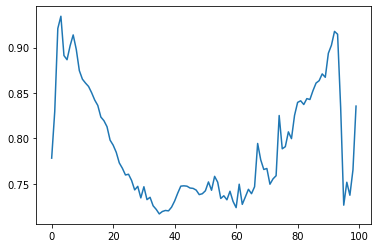

In [ ]:
re = []
for x,y in zip(Real_X, Surr_X):
    x = x.squeeze()
    y = y.squeeze()
    e = torch.norm(x - y)/torch.norm(x)
    re.append(e)
plt.plot(re)

### Make Movie

In [ ]:
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.animation as manimati
from matplotlib import animation, rc
def create_1_channel_movie(im,outfile='sim.mp4',title='surrogate            simulation'):
    ti = 0
    u_mx = 255 #np.max(np.abs(Xrgb))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    cmap = plt.cm.ocean
    img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
    #plt.show()
    
    # initialization function: plot the background of each frame
    def init():
        img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        return (fig,)

    # animation function. This is called sequentially
    def animate(i):
        img = ax.imshow(im[i].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        return (fig,)


    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(im), interval=20, blit=True)
    anim.save(outfile, fps=30, extra_args=['-vcodec', 'libx264'])

In [ ]:
Xrgb = torch.cat([Surr_X_img, Real_X_img], dim=3)
Xrgb.shape

torch.Size([100, 1, 128, 256])

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


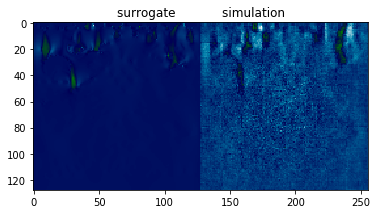

In [ ]:
outGif = '{}.gif'.format(versionName)
create_1_channel_movie(Xrgb.detach().numpy(),outfile=outGif)

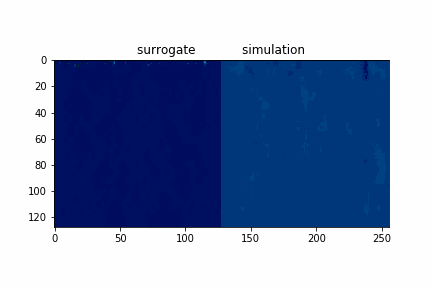

In [ ]:
from IPython.display import Image
Image(filename=outGif)